In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import tensorflow as tf
from tensorflow import keras

import pandas as pd
from pandas import read_csv

from sklearn.decomposition import PCA
import umap

import datetime

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers, initializers, regularizers, models
import tensorflow.keras.backend as K

# fix CUDNN_STATUS_INTERNAL_ERROR
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
# Convert from 64 to 32 bit floats
X_test = np.load("/home/alon/school/c247a/datasets/project_data/project/X_test.npy").astype(np.float32)
y_test = np.load("/home/alon/school/c247a/datasets/project_data/project/y_test.npy").astype(np.float32)
person_train_valid = np.load("/home/alon/school/c247a/datasets/project_data/project/person_train_valid.npy").astype(np.float32)
X_train_valid = np.load("/home/alon/school/c247a/datasets/project_data/project/X_train_valid.npy").astype(np.float32)
y_train_valid = np.load("/home/alon/school/c247a/datasets/project_data/project/y_train_valid.npy").astype(np.float32)
person_test = np.load("/home/alon/school/c247a/datasets/project_data/project/person_test.npy").astype(np.float32)

# adjust labels 
y_train_valid -= 769
y_test -= 769

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))
print('y_train_valid', y_train_valid[:10])

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)
y_train_valid [2. 3. 0. 0. 0. 0. 2. 1. 3. 3.]


In [4]:
def ksquare(x):
    return tf.pow(x, 2)

def klog(x):
    return tf.math.log(x)

In [5]:
def convert_to_one_hot(in_arr):
    in_arr = in_arr.reshape((in_arr.shape[0],))
    in_arr = in_arr.astype(int)
    in_arr_1h = np.zeros((in_arr.size, in_arr.max()+1))
    in_arr_1h[np.arange(in_arr.size),in_arr] = 1
    return in_arr_1h

In [6]:
#convert all vectors to one-hot
y_train_valid_1h = convert_to_one_hot(y_train_valid)
y_test_1h = convert_to_one_hot(y_test)

person_train_valid_1h = convert_to_one_hot(person_train_valid)
person_test_1h = convert_to_one_hot(person_test)

In [7]:
#normalizing and then adding noise to every single training input

X_train_valid_norm = np.zeros_like(X_train_valid)

for eeg_ix in range(X_train_valid.shape[0]):
    for i in range(22):
        #normalize the data
        y = X_train_valid[eeg_ix,i,:]
        mean = np.mean(y)
        std = np.std(y)
        z = (y-mean)/std
        X_train_valid_norm[eeg_ix,i,:] = z
        

#don't want to actually use the one with noise        
# mu, sigma = 0, 0.10
# s = np.random.normal(mu, sigma, X_train_valid_norm.shape)
# print("Noise shape: {}".format(s.shape))
# X_train_valid_norm_noised = X_train_valid_norm + s

In [8]:
#normalizing and then adding noise to every single test input

X_test_norm = np.zeros_like(X_test)

for eeg_ix in range(X_test.shape[0]):
    for i in range(22):
        #normalize the data
        y = X_test[eeg_ix,i,:]
        mean = np.mean(y)
        std = np.std(y)
        z = (y-mean)/std
        X_test_norm[eeg_ix,i,:] = z
        
# mu, sigma = 0, 0.10
# s = np.random.normal(mu, sigma, X_test_norm.shape)
# print("Noise shape: {}".format(s.shape))
# X_test_norm_noised = X_test_norm + s

In [9]:
#Crop for 12

X_train_valid_norm_cropped = X_train_valid_norm[:,:,:500]
X_test_norm_cropped = X_test_norm[:,:,:500]

## This is the preprocessing setup for the current best network done: standardized inputs and cropped.

## Now let's try dimensionality reduction, first using PCA, and then UMAP

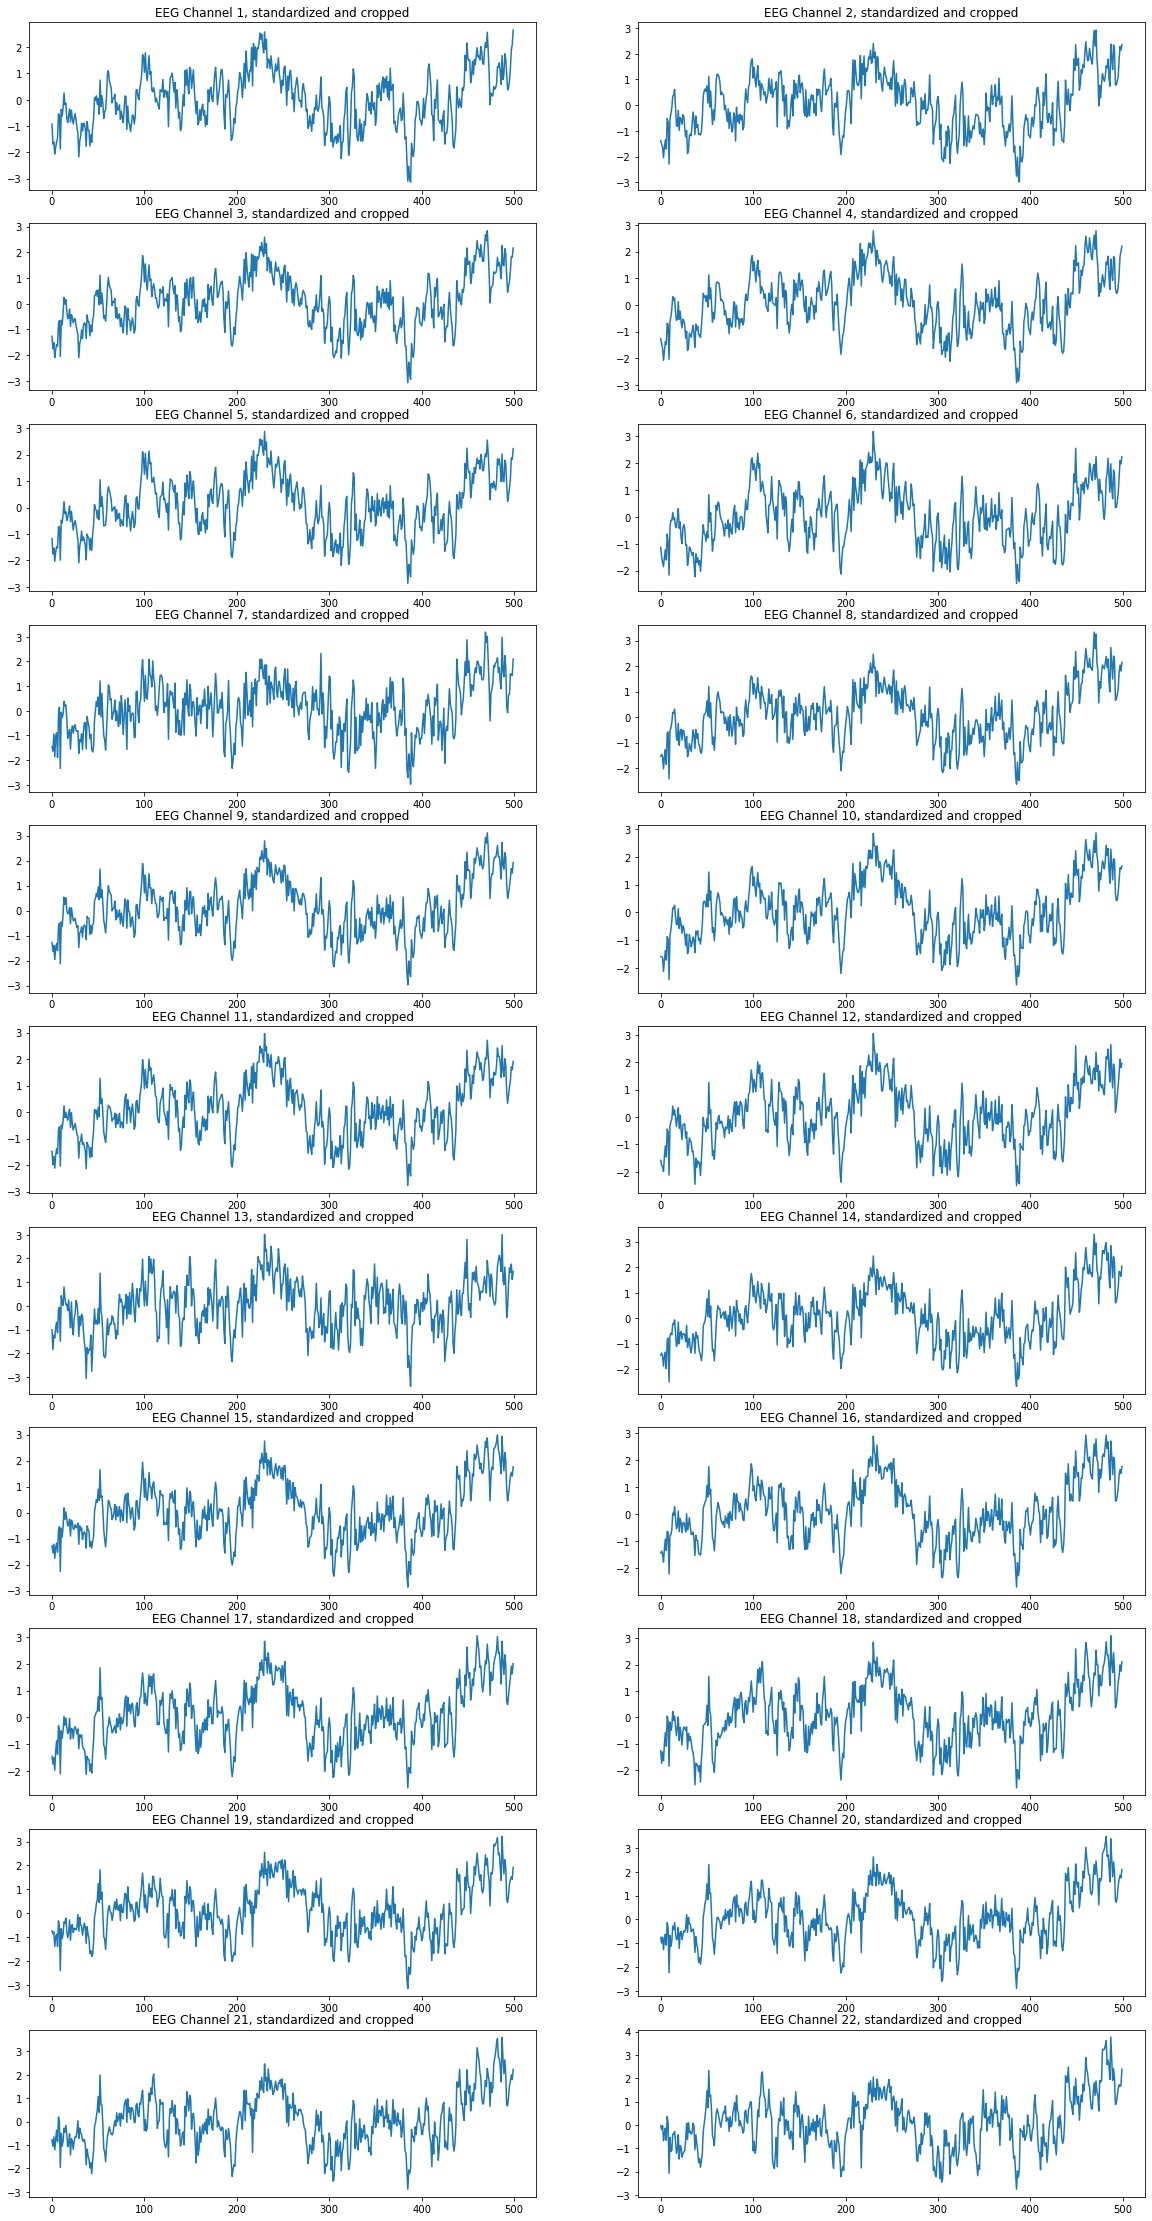

In [11]:
#Take a look at some random capture

fig, axs = plt.subplots(11,2,figsize=(20,40))

count = 0

eeg_ix = 10

for i in range(22):
    y = X_train_valid_norm_cropped[eeg_ix,i,:]
    
    axs[int(i/2),count].plot(y)
    axs[int(i/2),count].set_title('EEG Channel {}, standardized and cropped'.format(i+1))
    
    count += 1
    if (count>1):
        count=0

In [12]:
#need to flip the tensor so that it's (examples, timesteps, channels)
X_train_valid_flipped = np.transpose(X_train_valid_norm_cropped, (0,2,1))
print(X_train_valid_flipped.shape)

(2115, 500, 22)


In [21]:
n_comp=16   #This is the number of channels we want to reduce to


X_train_valid_reshaped = X_train_valid_flipped.reshape((X_train_valid_norm_cropped.shape[0]*X_train_valid_norm_cropped.shape[2], 22)) 
print(X_train_valid_reshaped.shape)
X_test_flipped = np.transpose(X_test_norm_cropped, (0,2,1))
X_test_reshaped = X_test_flipped.reshape((X_test_norm_cropped.shape[0]*X_test_norm_cropped.shape[2], 22)) 


#try a PCA on the data
#reshaped_data = X_train_valid_flipped.reshape((X_train_valid_cropped.shape[1]*X_train_valid_cropped.shape[2], 22))    # create one big data panel with 20 series and 300.000 datapoints
                                      #choose the number of features to have after dimensionality reduction
pca = PCA(n_components=n_comp)                  #create the pca object       
pca.fit(X_train_valid_reshaped)                               #fit it to your transformed data
X_train_valid_transformed=np.empty([X_train_valid_norm_cropped.shape[0],X_train_valid_norm_cropped.shape[2],n_comp])
for i in range(len(X_train_valid_flipped)):
    #print(X_train_valid_flipped[i].shape)
    X_train_valid_transformed[i]=pca.transform(X_train_valid_flipped[i])           #iteratively apply the transformation to each instance of the original dataset

        
print(X_train_valid_transformed.shape)    #we end up with examples*timesteps*channels
#now transpose back to examples*channels*timesteps
X_train_valid_transformed = np.transpose(X_train_valid_transformed, (0,2,1))

#n_comp=4                                      #choose the number of features to have after dimensionality reduction
pca = PCA(n_components=n_comp)                  #create the pca object       
pca.fit(X_test_reshaped)                               #fit it to your transformed data
X_test_transformed=np.empty([X_test_norm_cropped.shape[0],X_test_norm_cropped.shape[2],n_comp])
#print(X_test_transformed.shape)
for i in range(len(X_test_flipped)):
    #print(X_test_flipped[i].shape)
    X_test_transformed[i]=pca.transform(X_test_flipped[i])           #iteratively apply the transformation to each instance of the original dataset

print(X_test_transformed.shape)    #we end up with examples*timesteps*channels
#now transpose back to examples*channels*timesteps
X_test_transformed = np.transpose(X_test_transformed, (0,2,1))

(1057500, 22)
(2115, 500, 16)
(443, 500, 16)


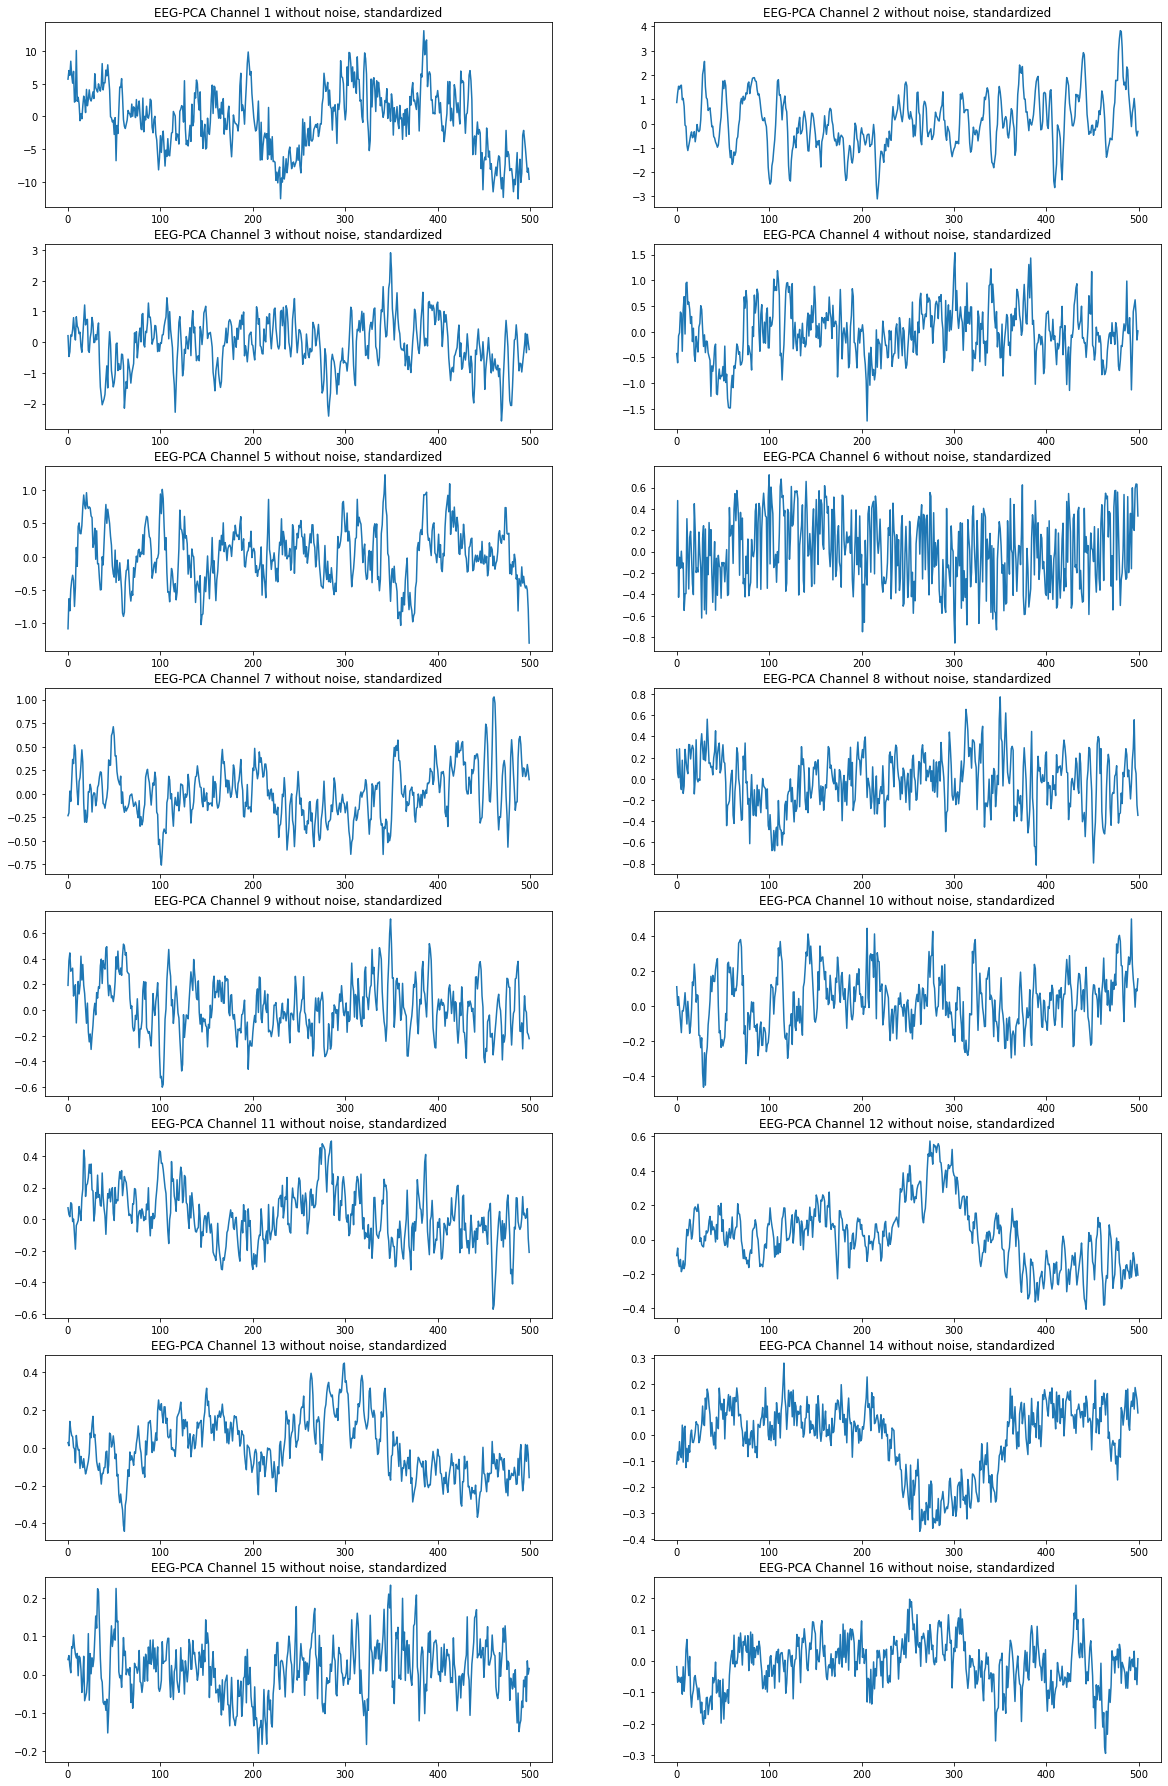

In [24]:
#This is to plot the new channels after PCA

fig, axs = plt.subplots(int(n_comp/2),2,figsize=(20,n_comp*2))

count = 0

eeg_ix = 10

for i in range(n_comp):
    y = X_train_valid_transformed[eeg_ix,i,:]
    
    axs[int(i/2),count].plot(y)
    axs[int(i/2),count].set_title('EEG-PCA Channel {} without noise, standardized'.format(i+1))
    
    count += 1
    if (count>1):
        count=0

Testing PCA Network for n_dims = 10
Model: "shallow_convnet_one_hot"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 10, 500)]         0         
_________________________________________________________________
reshape_14 (Reshape)         (None, 10, 500, 1)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 476, 40)       1040      
_________________________________________________________________
permute_7 (Permute)          (None, 476, 10, 40)       0         
_________________________________________________________________
reshape_15 (Reshape)         (None, 476, 400)          0         
_________________________________________________________________
dense_14 (Dense)             (None, 476, 40)           16040     
_________________________________________________________________
activat

53/53 [==============================] - 3s 63ms/step - loss: 0.6577 - acc: 0.7565 - val_loss: 0.8225 - val_acc: 0.6998
Epoch 49/75
53/53 [==============================] - 3s 64ms/step - loss: 0.6697 - acc: 0.7695 - val_loss: 0.8420 - val_acc: 0.6950
Epoch 50/75
53/53 [==============================] - 3s 64ms/step - loss: 0.6724 - acc: 0.7713 - val_loss: 0.8207 - val_acc: 0.7116
Epoch 51/75
53/53 [==============================] - 3s 63ms/step - loss: 0.6533 - acc: 0.7713 - val_loss: 0.8147 - val_acc: 0.7021
Epoch 52/75
53/53 [==============================] - 3s 64ms/step - loss: 0.6687 - acc: 0.7742 - val_loss: 0.8379 - val_acc: 0.6950
Epoch 53/75
53/53 [==============================] - 3s 64ms/step - loss: 0.6239 - acc: 0.7784 - val_loss: 0.8303 - val_acc: 0.6927
Epoch 54/75
53/53 [==============================] - 3s 63ms/step - loss: 0.6414 - acc: 0.7813 - val_loss: 0.8449 - val_acc: 0.6879
Epoch 55/75
53/53 [==============================] - 3s 65ms/step - loss: 0.6395 - acc: 

53/53 [==============================] - 4s 70ms/step - loss: 0.7922 - acc: 0.7139 - val_loss: 0.8629 - val_acc: 0.6879
Epoch 21/75
53/53 [==============================] - 4s 69ms/step - loss: 0.8276 - acc: 0.6939 - val_loss: 0.8608 - val_acc: 0.6738
Epoch 22/75
53/53 [==============================] - 4s 75ms/step - loss: 0.7870 - acc: 0.7145 - val_loss: 0.8484 - val_acc: 0.6950
Epoch 23/75
53/53 [==============================] - 4s 76ms/step - loss: 0.8201 - acc: 0.7063 - val_loss: 0.8479 - val_acc: 0.6927
Epoch 24/75
53/53 [==============================] - 4s 71ms/step - loss: 0.7774 - acc: 0.7163 - val_loss: 0.8384 - val_acc: 0.7116
Epoch 25/75
53/53 [==============================] - 4s 75ms/step - loss: 0.7965 - acc: 0.7175 - val_loss: 0.8343 - val_acc: 0.6950
Epoch 26/75
53/53 [==============================] - 4s 71ms/step - loss: 0.7903 - acc: 0.7157 - val_loss: 0.8333 - val_acc: 0.6950
Epoch 27/75
53/53 [==============================] - 4s 70ms/step - loss: 0.7574 - acc: 

Epoch 1/75
53/53 [==============================] - 4s 76ms/step - loss: 1.7359 - acc: 0.2819 - val_loss: 1.3481 - val_acc: 0.3830
Epoch 2/75
53/53 [==============================] - 4s 76ms/step - loss: 1.3819 - acc: 0.3765 - val_loss: 1.3015 - val_acc: 0.4043
Epoch 3/75
53/53 [==============================] - 4s 74ms/step - loss: 1.3055 - acc: 0.4161 - val_loss: 1.2352 - val_acc: 0.4610
Epoch 4/75
53/53 [==============================] - 4s 75ms/step - loss: 1.2169 - acc: 0.4775 - val_loss: 1.1410 - val_acc: 0.5059
Epoch 5/75
53/53 [==============================] - 4s 75ms/step - loss: 1.1440 - acc: 0.5278 - val_loss: 1.0870 - val_acc: 0.5319
Epoch 6/75
53/53 [==============================] - 4s 75ms/step - loss: 1.0924 - acc: 0.5597 - val_loss: 1.0540 - val_acc: 0.5532
Epoch 7/75
53/53 [==============================] - 4s 74ms/step - loss: 1.0247 - acc: 0.5993 - val_loss: 1.0206 - val_acc: 0.5816
Epoch 8/75
53/53 [==============================] - 4s 74ms/step - loss: 0.9969 - a

53/53 [==============================] - 4s 74ms/step - loss: 0.5847 - acc: 0.8050 - val_loss: 0.8294 - val_acc: 0.6998
Epoch 64/75
53/53 [==============================] - 4s 74ms/step - loss: 0.5934 - acc: 0.8056 - val_loss: 0.8206 - val_acc: 0.6856
Epoch 65/75
53/53 [==============================] - 4s 74ms/step - loss: 0.5823 - acc: 0.8032 - val_loss: 0.8648 - val_acc: 0.6879
Epoch 66/75
53/53 [==============================] - 4s 74ms/step - loss: 0.5740 - acc: 0.8026 - val_loss: 0.8475 - val_acc: 0.6927
Epoch 67/75
53/53 [==============================] - 4s 74ms/step - loss: 0.5547 - acc: 0.8150 - val_loss: 0.8382 - val_acc: 0.6998
Epoch 68/75
53/53 [==============================] - 4s 74ms/step - loss: 0.5629 - acc: 0.8126 - val_loss: 0.8422 - val_acc: 0.6903
Epoch 69/75
53/53 [==============================] - 4s 74ms/step - loss: 0.5618 - acc: 0.8044 - val_loss: 0.8633 - val_acc: 0.6927
Epoch 70/75
53/53 [==============================] - 4s 74ms/step - loss: 0.5681 - acc: 

53/53 [==============================] - 4s 84ms/step - loss: 0.6628 - acc: 0.7660 - val_loss: 0.7932 - val_acc: 0.7092
Epoch 36/75
53/53 [==============================] - 4s 82ms/step - loss: 0.6399 - acc: 0.7725 - val_loss: 0.7826 - val_acc: 0.7021
Epoch 37/75
53/53 [==============================] - 4s 79ms/step - loss: 0.6609 - acc: 0.7612 - val_loss: 0.7839 - val_acc: 0.7092
Epoch 38/75
53/53 [==============================] - 4s 80ms/step - loss: 0.6539 - acc: 0.7801 - val_loss: 0.7712 - val_acc: 0.7234
Epoch 39/75
53/53 [==============================] - 4s 80ms/step - loss: 0.6661 - acc: 0.7565 - val_loss: 0.7606 - val_acc: 0.7281
Epoch 40/75
53/53 [==============================] - 4s 80ms/step - loss: 0.6250 - acc: 0.7772 - val_loss: 0.7970 - val_acc: 0.7163
Epoch 41/75
53/53 [==============================] - 4s 80ms/step - loss: 0.6159 - acc: 0.7949 - val_loss: 0.7820 - val_acc: 0.7210
Epoch 42/75
53/53 [==============================] - 4s 81ms/step - loss: 0.6336 - acc: 

53/53 [==============================] - 5s 89ms/step - loss: 1.0518 - acc: 0.5851 - val_loss: 1.0209 - val_acc: 0.5626
Epoch 8/75
53/53 [==============================] - 5s 88ms/step - loss: 0.9989 - acc: 0.5916 - val_loss: 0.9872 - val_acc: 0.6217
Epoch 9/75
53/53 [==============================] - 5s 90ms/step - loss: 0.9796 - acc: 0.6188 - val_loss: 0.9467 - val_acc: 0.6288
Epoch 10/75
53/53 [==============================] - 5s 89ms/step - loss: 0.9053 - acc: 0.6513 - val_loss: 0.9433 - val_acc: 0.6265
Epoch 11/75
53/53 [==============================] - 5s 89ms/step - loss: 0.9071 - acc: 0.6543 - val_loss: 0.9251 - val_acc: 0.6147
Epoch 12/75
53/53 [==============================] - 5s 89ms/step - loss: 0.8671 - acc: 0.6814 - val_loss: 0.9212 - val_acc: 0.6596
Epoch 13/75
53/53 [==============================] - 5s 94ms/step - loss: 0.8525 - acc: 0.6779 - val_loss: 0.8884 - val_acc: 0.6525
Epoch 14/75
53/53 [==============================] - 5s 92ms/step - loss: 0.8352 - acc: 0.

53/53 [==============================] - 5s 89ms/step - loss: 0.5461 - acc: 0.8203 - val_loss: 0.8846 - val_acc: 0.6927
Epoch 70/75
53/53 [==============================] - 5s 89ms/step - loss: 0.5175 - acc: 0.8345 - val_loss: 0.8793 - val_acc: 0.6879
Epoch 71/75
53/53 [==============================] - 5s 89ms/step - loss: 0.5161 - acc: 0.8428 - val_loss: 0.8850 - val_acc: 0.6950
Epoch 72/75
53/53 [==============================] - 5s 89ms/step - loss: 0.5139 - acc: 0.8357 - val_loss: 0.8794 - val_acc: 0.6903
Epoch 73/75
53/53 [==============================] - 5s 88ms/step - loss: 0.5186 - acc: 0.8322 - val_loss: 0.8466 - val_acc: 0.6856
Epoch 74/75
53/53 [==============================] - 5s 89ms/step - loss: 0.5584 - acc: 0.8197 - val_loss: 0.8508 - val_acc: 0.7069
Epoch 75/75
53/53 [==============================] - 5s 90ms/step - loss: 0.5222 - acc: 0.8327 - val_loss: 0.8759 - val_acc: 0.6950
Testing PCA Network for n_dims = 15
Model: "shallow_convnet_one_hot"
___________________

53/53 [==============================] - 5s 95ms/step - loss: 0.5897 - acc: 0.8002 - val_loss: 0.8048 - val_acc: 0.7116
Epoch 42/75
53/53 [==============================] - 5s 96ms/step - loss: 0.6111 - acc: 0.7920 - val_loss: 0.8120 - val_acc: 0.7210
Epoch 43/75
53/53 [==============================] - 5s 95ms/step - loss: 0.5912 - acc: 0.7931 - val_loss: 0.8463 - val_acc: 0.7116
Epoch 44/75
53/53 [==============================] - 5s 95ms/step - loss: 0.6126 - acc: 0.7784 - val_loss: 0.8638 - val_acc: 0.7069
Epoch 45/75
53/53 [==============================] - 5s 96ms/step - loss: 0.6172 - acc: 0.7843 - val_loss: 0.8209 - val_acc: 0.7163
Epoch 46/75
53/53 [==============================] - 5s 95ms/step - loss: 0.5979 - acc: 0.8050 - val_loss: 0.8383 - val_acc: 0.7258
Epoch 47/75
53/53 [==============================] - 5s 95ms/step - loss: 0.5792 - acc: 0.8061 - val_loss: 0.8215 - val_acc: 0.7139
Epoch 48/75
53/53 [==============================] - 5s 96ms/step - loss: 0.5723 - acc: 

53/53 [==============================] - 5s 101ms/step - loss: 0.8714 - acc: 0.6625 - val_loss: 0.8560 - val_acc: 0.6785
Epoch 14/75
53/53 [==============================] - 5s 101ms/step - loss: 0.8583 - acc: 0.6862 - val_loss: 0.8406 - val_acc: 0.6643
Epoch 15/75
53/53 [==============================] - 5s 101ms/step - loss: 0.8276 - acc: 0.6874 - val_loss: 0.8577 - val_acc: 0.6761
Epoch 16/75
53/53 [==============================] - 5s 101ms/step - loss: 0.8087 - acc: 0.7004 - val_loss: 0.8277 - val_acc: 0.6927
Epoch 17/75
53/53 [==============================] - 5s 100ms/step - loss: 0.8033 - acc: 0.7015 - val_loss: 0.8495 - val_acc: 0.6643
Epoch 18/75
53/53 [==============================] - 5s 102ms/step - loss: 0.8148 - acc: 0.6897 - val_loss: 0.8119 - val_acc: 0.6856
Epoch 19/75
53/53 [==============================] - 5s 101ms/step - loss: 0.7833 - acc: 0.7116 - val_loss: 0.8075 - val_acc: 0.6879
Epoch 20/75
53/53 [==============================] - 5s 100ms/step - loss: 0.7810

Epoch 75/75
53/53 [==============================] - 6s 106ms/step - loss: 0.5090 - acc: 0.8363 - val_loss: 0.8676 - val_acc: 0.7163
Testing PCA Network for n_dims = 17
Model: "shallow_convnet_one_hot"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 17, 500)]         0         
_________________________________________________________________
reshape_28 (Reshape)         (None, 17, 500, 1)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 17, 476, 40)       1040      
_________________________________________________________________
permute_14 (Permute)         (None, 476, 17, 40)       0         
_________________________________________________________________
reshape_29 (Reshape)         (None, 476, 680)          0         
_________________________________________________________________
dense_

Epoch 47/75
53/53 [==============================] - 6s 104ms/step - loss: 0.5907 - acc: 0.7979 - val_loss: 0.8213 - val_acc: 0.7092
Epoch 48/75
53/53 [==============================] - 6s 105ms/step - loss: 0.5670 - acc: 0.7991 - val_loss: 0.8122 - val_acc: 0.7092
Epoch 49/75
53/53 [==============================] - 6s 105ms/step - loss: 0.5713 - acc: 0.7996 - val_loss: 0.8203 - val_acc: 0.6998
Epoch 50/75
53/53 [==============================] - 5s 104ms/step - loss: 0.5646 - acc: 0.8050 - val_loss: 0.8087 - val_acc: 0.7092
Epoch 51/75
53/53 [==============================] - 6s 104ms/step - loss: 0.5482 - acc: 0.8109 - val_loss: 0.8375 - val_acc: 0.6927
Epoch 52/75
53/53 [==============================] - 6s 104ms/step - loss: 0.5461 - acc: 0.8186 - val_loss: 0.8322 - val_acc: 0.6998
Epoch 53/75
53/53 [==============================] - 6s 106ms/step - loss: 0.6032 - acc: 0.7931 - val_loss: 0.8593 - val_acc: 0.6950
Epoch 54/75
53/53 [==============================] - 6s 107ms/step - 

Epoch 19/75
53/53 [==============================] - 6s 108ms/step - loss: 0.7055 - acc: 0.7423 - val_loss: 0.7979 - val_acc: 0.6998
Epoch 20/75
53/53 [==============================] - 6s 112ms/step - loss: 0.7502 - acc: 0.7264 - val_loss: 0.7927 - val_acc: 0.7163
Epoch 21/75
53/53 [==============================] - 6s 110ms/step - loss: 0.7395 - acc: 0.7281 - val_loss: 0.7918 - val_acc: 0.6903
Epoch 22/75
53/53 [==============================] - 6s 109ms/step - loss: 0.6990 - acc: 0.7547 - val_loss: 0.8001 - val_acc: 0.6903
Epoch 23/75
53/53 [==============================] - 6s 109ms/step - loss: 0.7256 - acc: 0.7411 - val_loss: 0.7790 - val_acc: 0.6974
Epoch 24/75
53/53 [==============================] - 6s 110ms/step - loss: 0.6854 - acc: 0.7612 - val_loss: 0.7893 - val_acc: 0.7163
Epoch 25/75
53/53 [==============================] - 6s 110ms/step - loss: 0.6810 - acc: 0.7524 - val_loss: 0.8114 - val_acc: 0.6998
Epoch 26/75
53/53 [==============================] - 6s 110ms/step - 

Epoch 1/75
53/53 [==============================] - 6s 116ms/step - loss: 1.8651 - acc: 0.2866 - val_loss: 1.3670 - val_acc: 0.3617
Epoch 2/75
53/53 [==============================] - 6s 115ms/step - loss: 1.4173 - acc: 0.3528 - val_loss: 1.3043 - val_acc: 0.3995
Epoch 3/75
53/53 [==============================] - 6s 115ms/step - loss: 1.3228 - acc: 0.4031 - val_loss: 1.2268 - val_acc: 0.4515
Epoch 4/75
53/53 [==============================] - 6s 116ms/step - loss: 1.2341 - acc: 0.4799 - val_loss: 1.1709 - val_acc: 0.4941
Epoch 5/75
53/53 [==============================] - 6s 115ms/step - loss: 1.1383 - acc: 0.5402 - val_loss: 1.0856 - val_acc: 0.5674
Epoch 6/75
53/53 [==============================] - 6s 116ms/step - loss: 1.0757 - acc: 0.5662 - val_loss: 1.0501 - val_acc: 0.5745
Epoch 7/75
53/53 [==============================] - 6s 115ms/step - loss: 1.0105 - acc: 0.6022 - val_loss: 1.0245 - val_acc: 0.5934
Epoch 8/75
53/53 [==============================] - 6s 114ms/step - loss: 1.

53/53 [==============================] - 6s 115ms/step - loss: 0.5185 - acc: 0.8245 - val_loss: 0.8682 - val_acc: 0.6879
Epoch 63/75
53/53 [==============================] - 6s 117ms/step - loss: 0.5037 - acc: 0.8410 - val_loss: 0.8744 - val_acc: 0.7021
Epoch 64/75
53/53 [==============================] - 6s 116ms/step - loss: 0.4898 - acc: 0.8475 - val_loss: 0.8725 - val_acc: 0.6903
Epoch 65/75
53/53 [==============================] - 6s 116ms/step - loss: 0.4951 - acc: 0.8316 - val_loss: 0.8799 - val_acc: 0.6856
Epoch 66/75
53/53 [==============================] - 6s 116ms/step - loss: 0.4876 - acc: 0.8511 - val_loss: 0.8850 - val_acc: 0.6974
Epoch 67/75
53/53 [==============================] - 6s 118ms/step - loss: 0.4850 - acc: 0.8422 - val_loss: 0.8831 - val_acc: 0.6879
Epoch 68/75
53/53 [==============================] - 6s 116ms/step - loss: 0.5052 - acc: 0.8381 - val_loss: 0.8841 - val_acc: 0.6998
Epoch 69/75
53/53 [==============================] - 6s 115ms/step - loss: 0.4967

Epoch 34/75
53/53 [==============================] - 7s 123ms/step - loss: 0.6327 - acc: 0.7725 - val_loss: 0.8086 - val_acc: 0.6927
Epoch 35/75
53/53 [==============================] - 6s 123ms/step - loss: 0.6493 - acc: 0.7689 - val_loss: 0.8419 - val_acc: 0.6832
Epoch 36/75
53/53 [==============================] - 6s 122ms/step - loss: 0.5893 - acc: 0.7902 - val_loss: 0.8252 - val_acc: 0.6974
Epoch 37/75
53/53 [==============================] - 6s 122ms/step - loss: 0.5748 - acc: 0.8079 - val_loss: 0.8296 - val_acc: 0.6974
Epoch 38/75
53/53 [==============================] - 6s 122ms/step - loss: 0.6303 - acc: 0.7837 - val_loss: 0.8400 - val_acc: 0.6950
Epoch 39/75
53/53 [==============================] - 6s 122ms/step - loss: 0.6123 - acc: 0.7784 - val_loss: 0.8337 - val_acc: 0.6998
Epoch 40/75
53/53 [==============================] - 6s 121ms/step - loss: 0.5866 - acc: 0.7902 - val_loss: 0.8547 - val_acc: 0.6998
Epoch 41/75
53/53 [==============================] - 6s 123ms/step - 

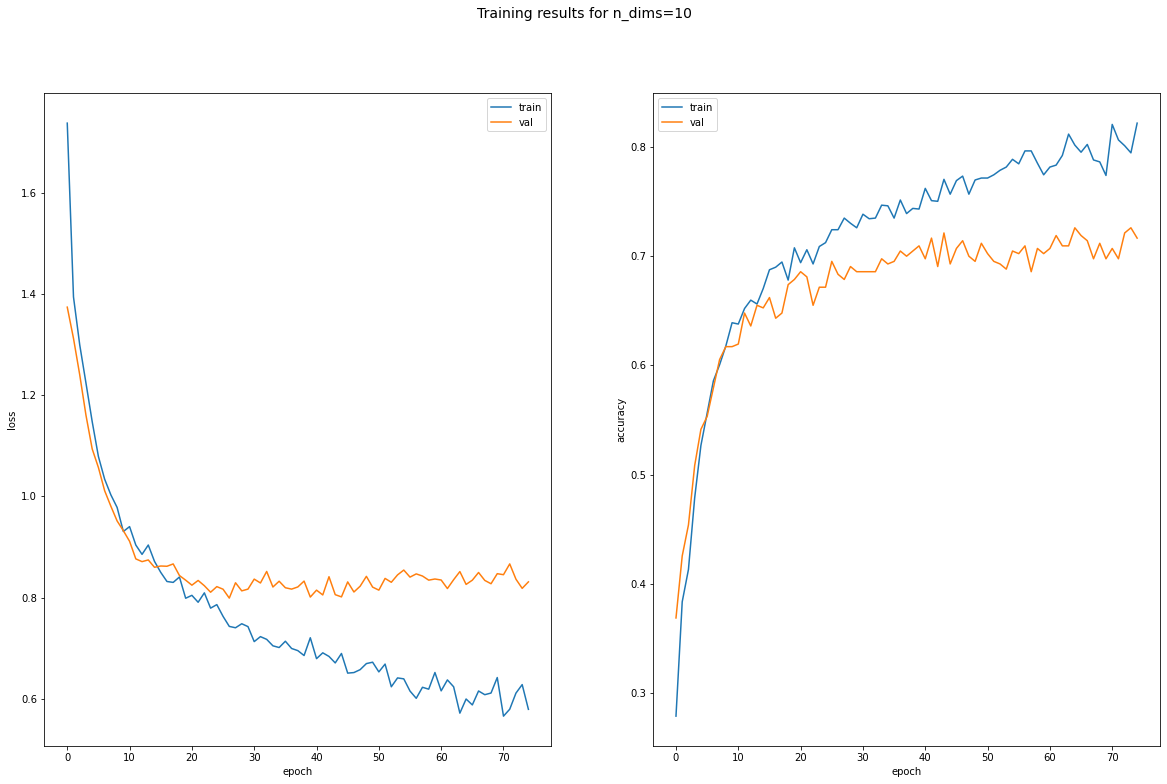

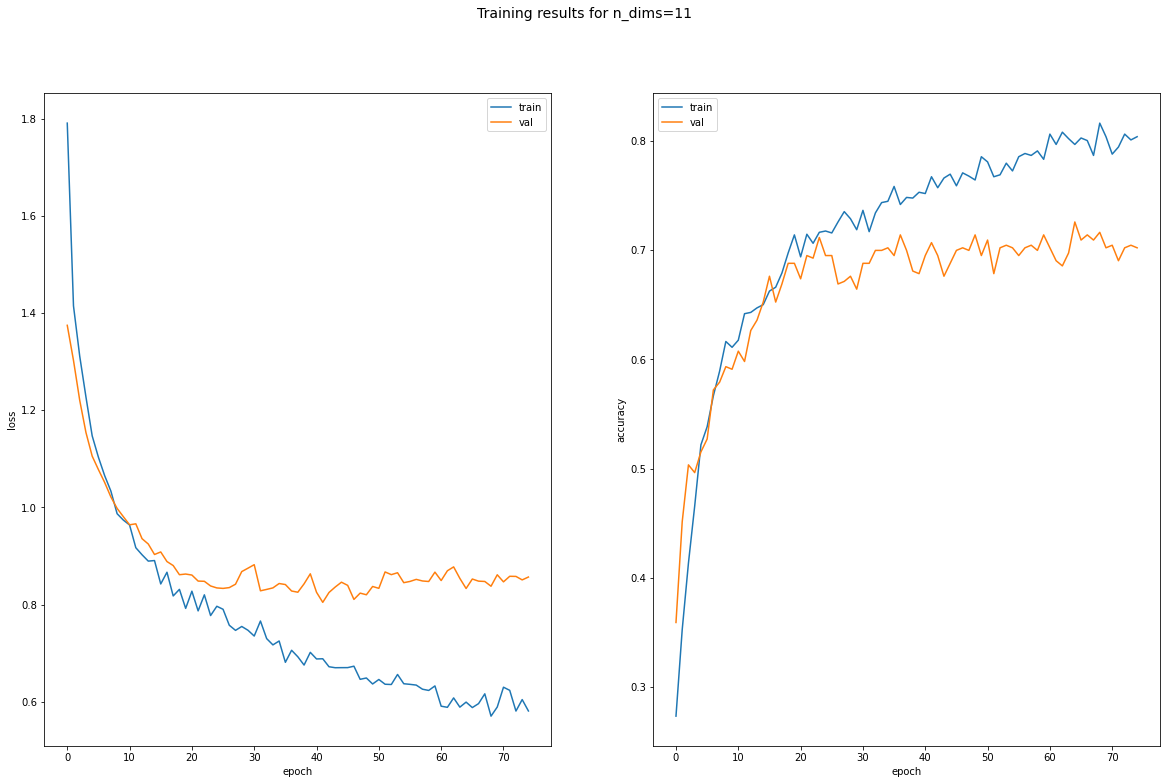

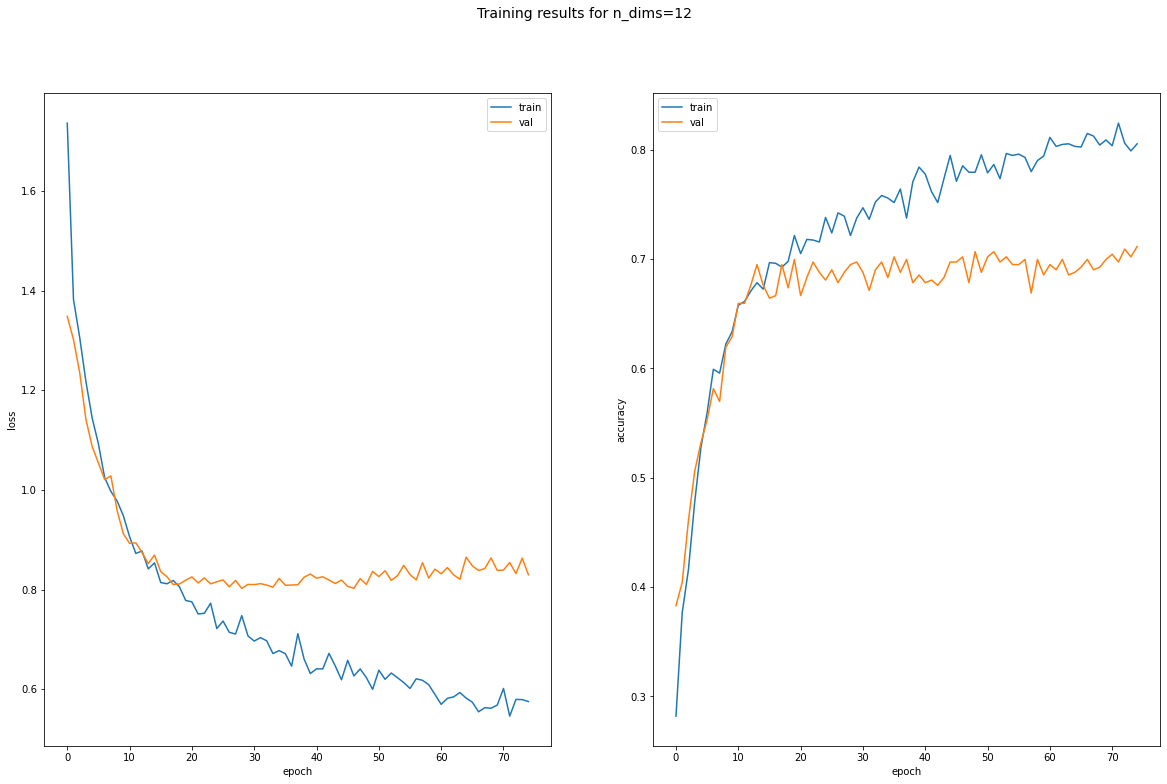

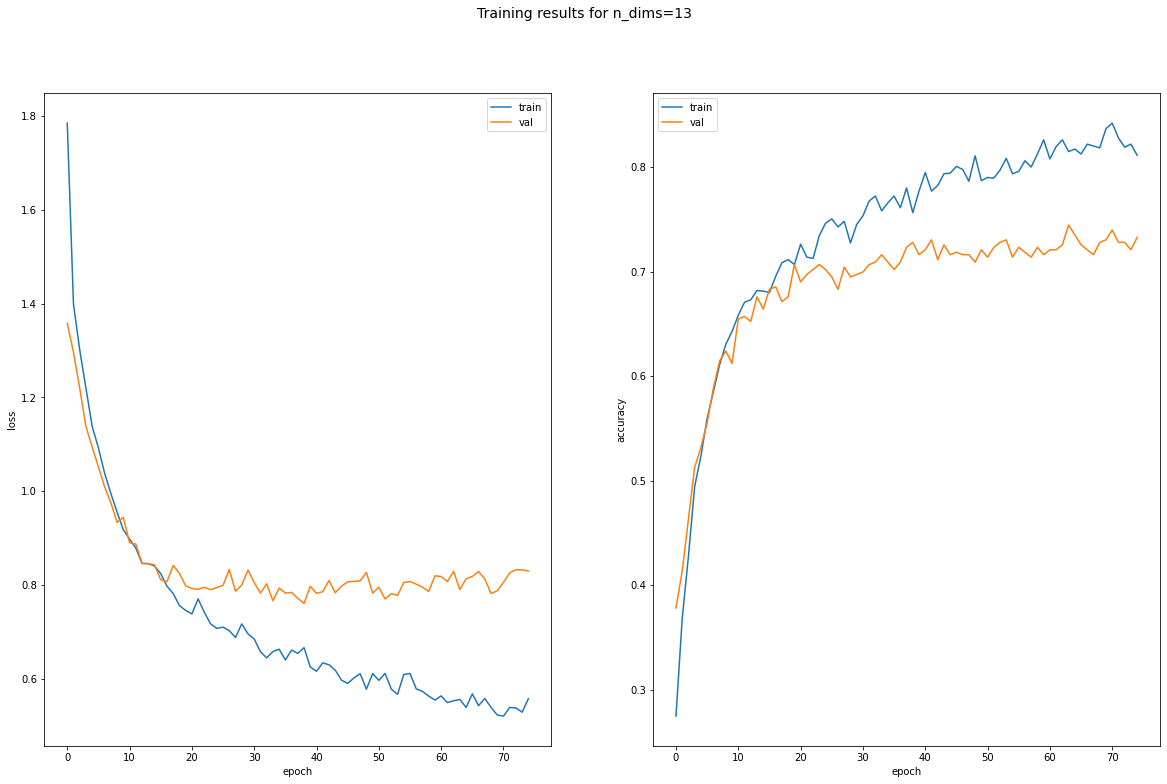

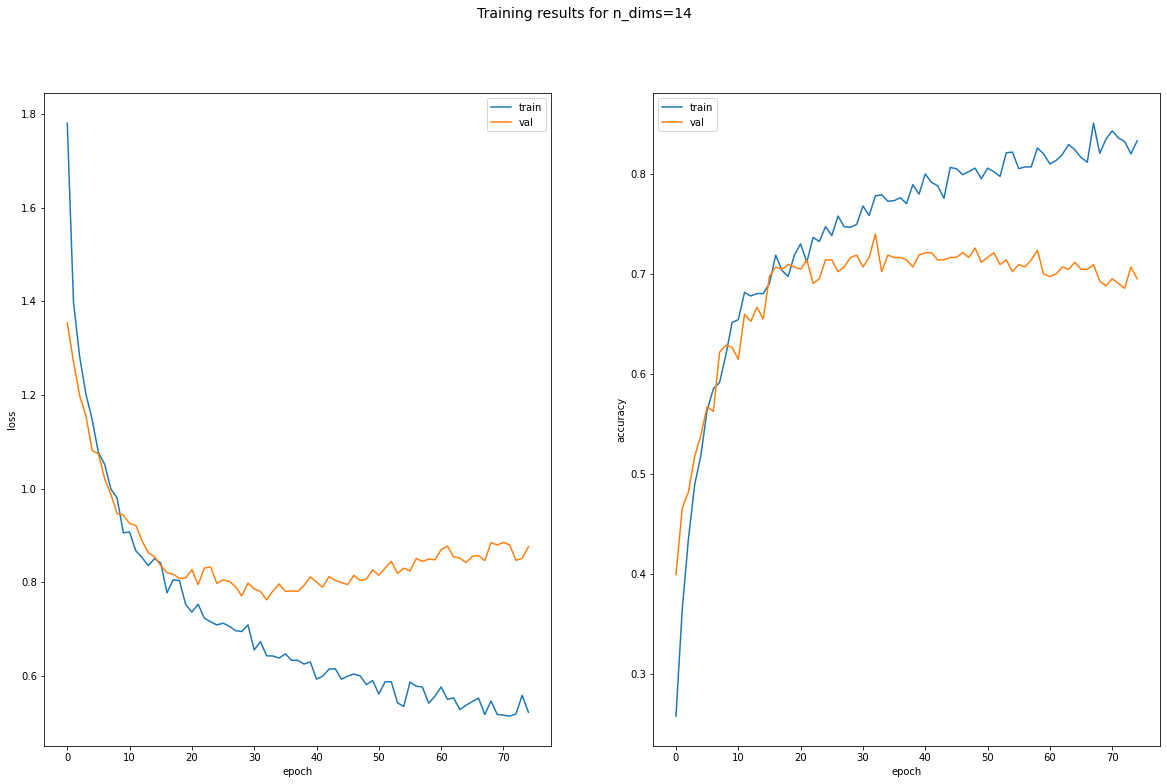

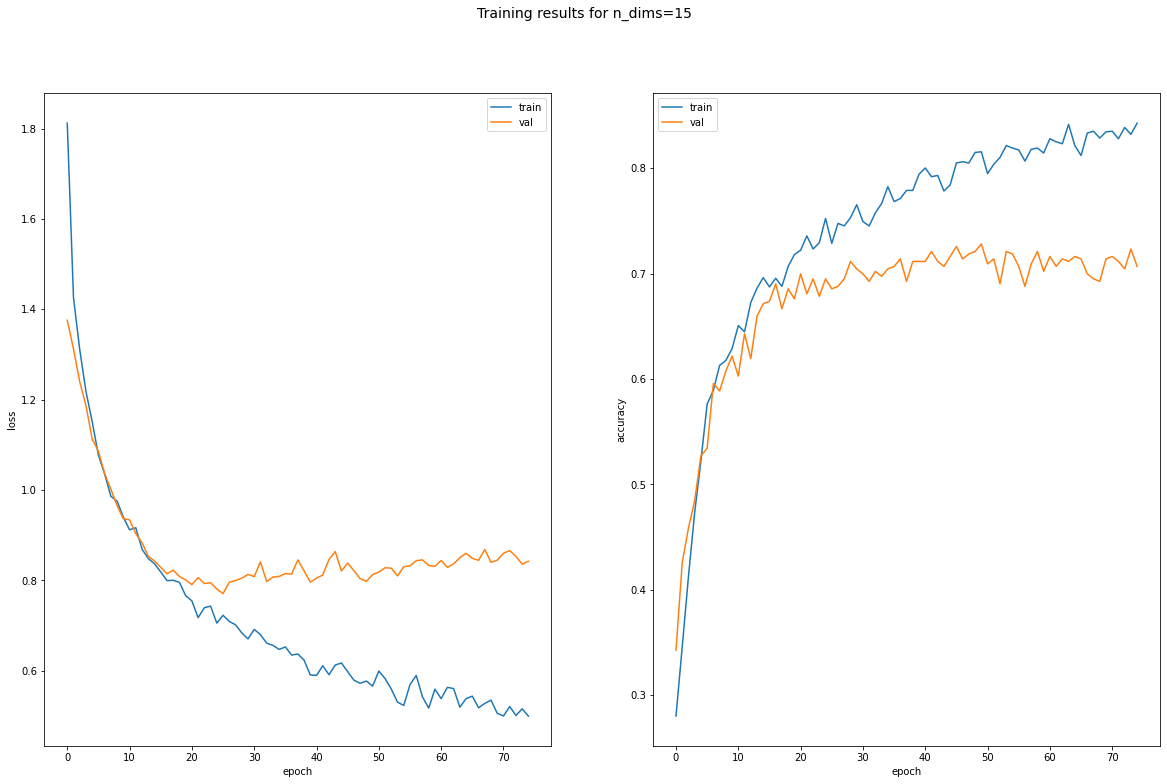

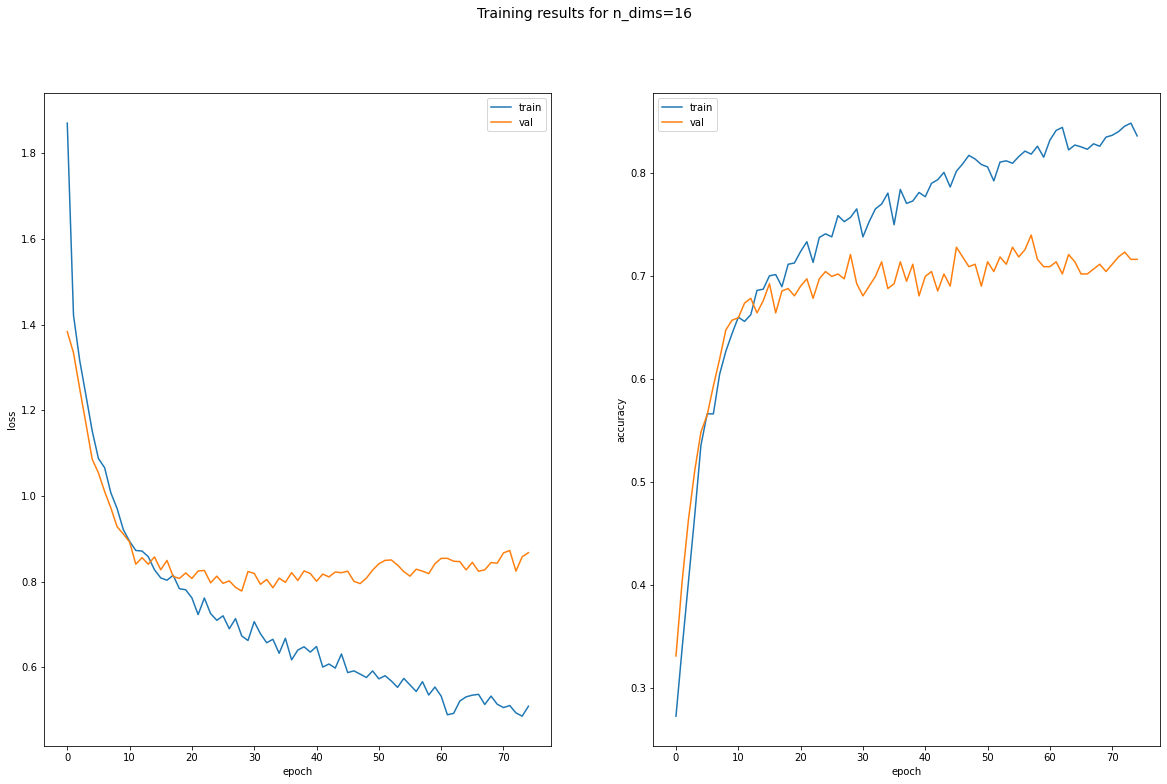

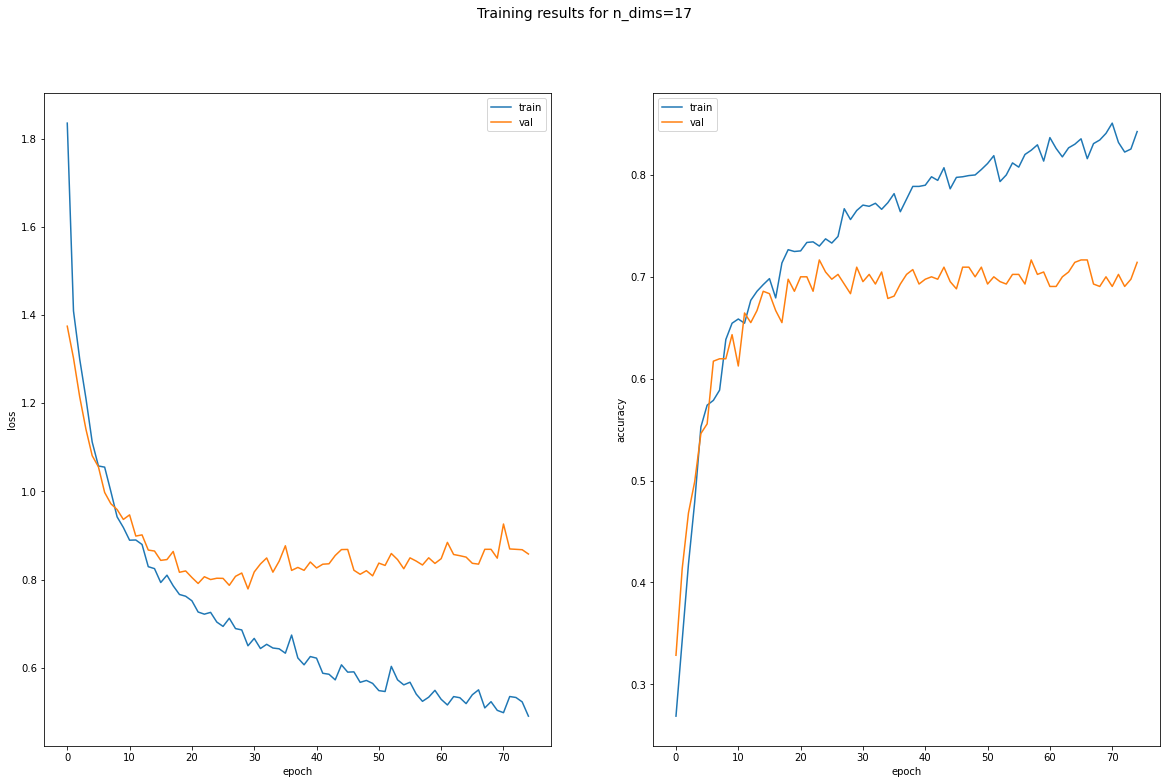

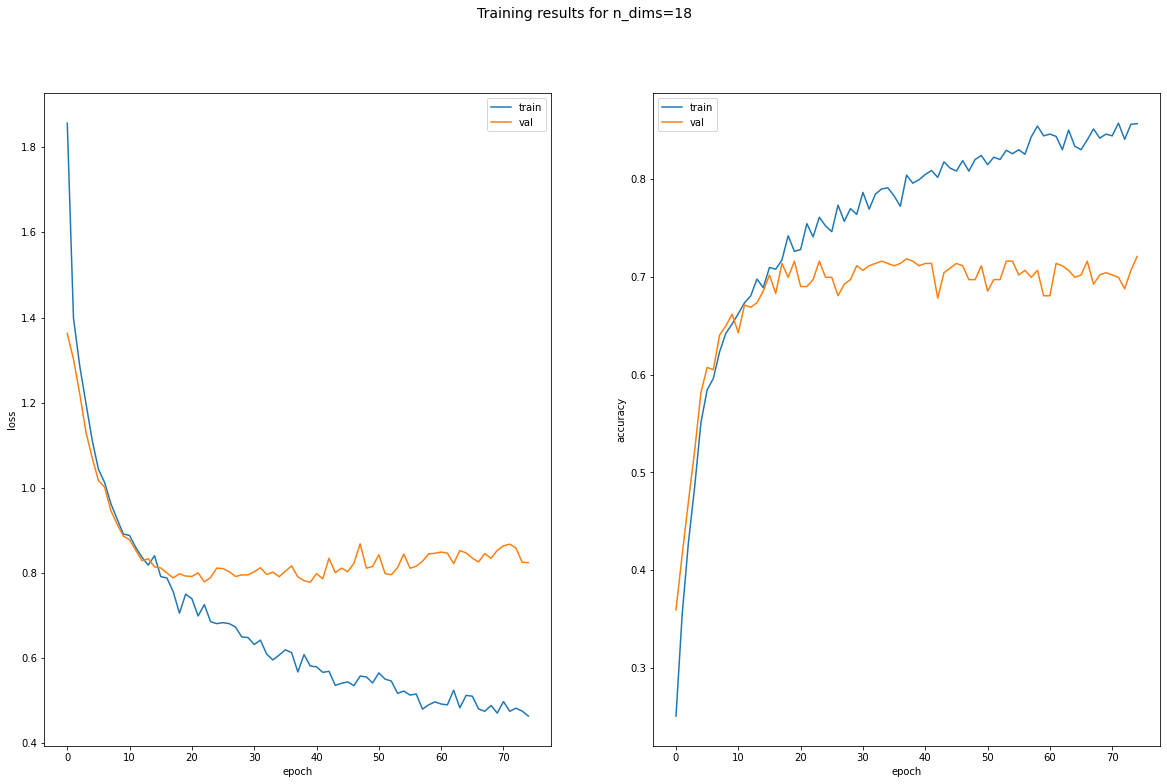

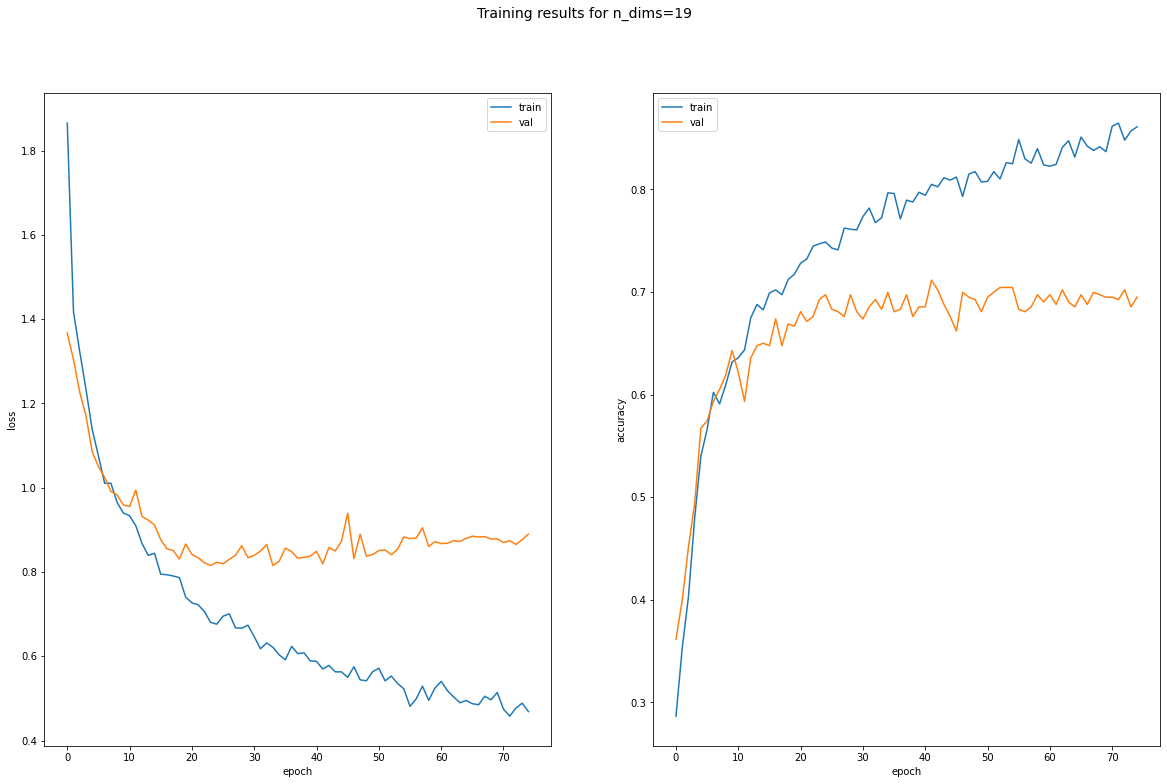

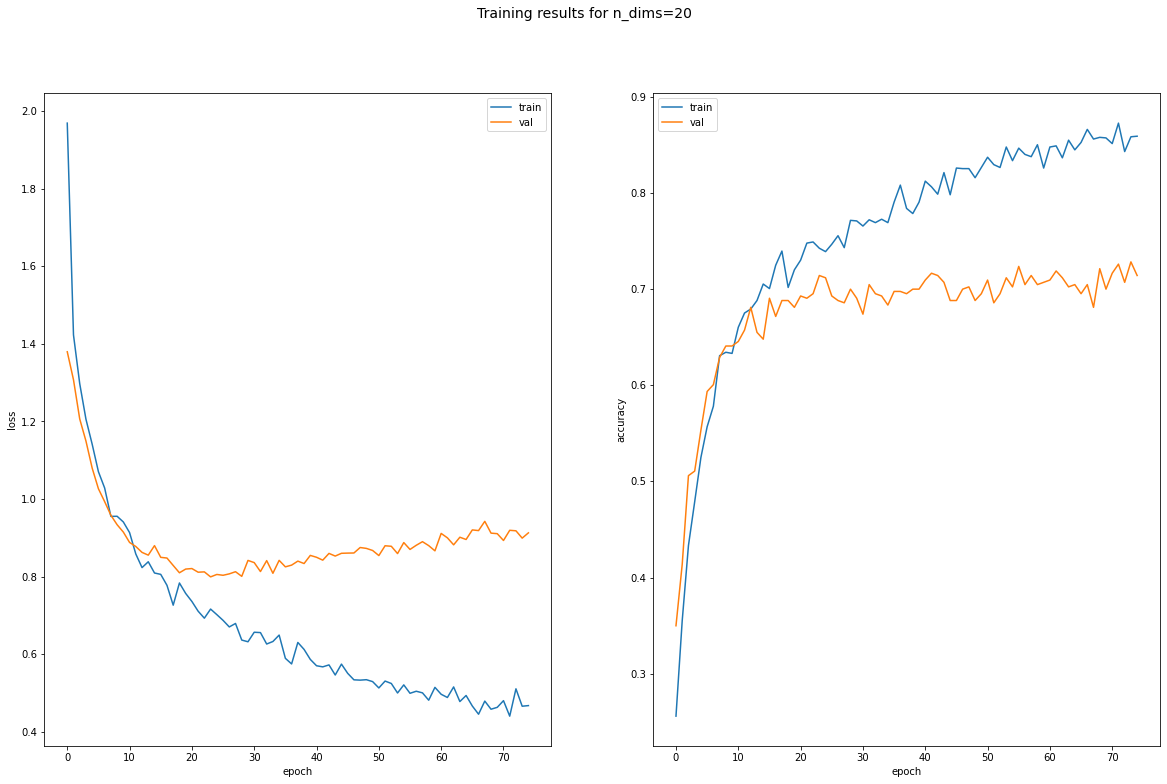

In [42]:
for n_comp in range(10, 21):
    print("Testing PCA Network for n_dims = {}".format(n_comp))
    
    X_train_valid_reshaped = X_train_valid_flipped.reshape((X_train_valid_norm_cropped.shape[0]*X_train_valid_norm_cropped.shape[2], 22)) 
    #print(X_train_valid_reshaped.shape)
    X_test_flipped = np.transpose(X_test_norm_cropped, (0,2,1))
    X_test_reshaped = X_test_flipped.reshape((X_test_norm_cropped.shape[0]*X_test_norm_cropped.shape[2], 22)) 


    #try a PCA on the data
    #reshaped_data = X_train_valid_flipped.reshape((X_train_valid_cropped.shape[1]*X_train_valid_cropped.shape[2], 22))    # create one big data panel with 20 series and 300.000 datapoints
                                          #choose the number of features to have after dimensionality reduction
    pca = PCA(n_components=n_comp)                  #create the pca object       
    pca.fit(X_train_valid_reshaped)                               #fit it to your transformed data
    X_train_valid_transformed=np.empty([X_train_valid_norm_cropped.shape[0],X_train_valid_norm_cropped.shape[2],n_comp])
    for i in range(len(X_train_valid_flipped)):
        #print(X_train_valid_flipped[i].shape)
        X_train_valid_transformed[i]=pca.transform(X_train_valid_flipped[i])           #iteratively apply the transformation to each instance of the original dataset


    #print(X_train_valid_transformed.shape)    #we end up with examples*timesteps*channels
    #now transpose back to examples*channels*timesteps
    X_train_valid_transformed = np.transpose(X_train_valid_transformed, (0,2,1))

    #n_comp=4                                      #choose the number of features to have after dimensionality reduction
    pca = PCA(n_components=n_comp)                  #create the pca object       
    pca.fit(X_test_reshaped)                               #fit it to your transformed data
    X_test_transformed=np.empty([X_test_norm_cropped.shape[0],X_test_norm_cropped.shape[2],n_comp])
    #print(X_test_transformed.shape)
    for i in range(len(X_test_flipped)):
        #print(X_test_flipped[i].shape)
        X_test_transformed[i]=pca.transform(X_test_flipped[i])           #iteratively apply the transformation to each instance of the original dataset

    #print(X_test_transformed.shape)    #we end up with examples*timesteps*channels
    #now transpose back to examples*channels*timesteps
    X_test_transformed = np.transpose(X_test_transformed, (0,2,1))
    
    input_ = layers.Input(shape=(n_comp, 500))
    r1 = layers.Reshape(target_shape=(n_comp, 500, 1))(input_)
    c1 = layers.Conv2D(filters=40, kernel_size=(1,25), data_format='channels_last',
                       activation='elu', kernel_regularizer='l2')(r1)
    p1 = layers.Permute(dims=(2,1,3))(c1)
    r2 = layers.Reshape((476, n_comp*40))(p1)
    d1 = layers.Dense(40, activation='elu')(r2)
    sq1 = layers.Activation(ksquare)(d1)
    ap1 = layers.AveragePooling1D(75, strides=15)(sq1)
    log1 = layers.Activation(klog)(ap1)
    f1 = layers.Flatten()(log1)
    d2 = layers.Dropout(0.80)(f1)
    output_ = layers.Dense(4, activation='softmax', kernel_regularizer='l2', kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01))(d2)
    
    model = models.Model(inputs=input_, outputs=output_, name='shallow_convnet_one_hot')
    #opt = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    model.summary()
    
    loss_hist = model.fit(X_train_valid_transformed, y_train_valid_1h, 
                      validation_split=0.2, epochs=75,
                      verbose=True)

    hist = loss_hist.history

    fig, axs = plt.subplots(1,2, figsize=(20, 12))

    fig.suptitle("Training results for n_dims={}".format(n_comp), fontsize=14)

    axs[0].plot(hist['loss'])
    axs[0].plot(hist['val_loss'])
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'])

    axs[1].plot(hist['acc'])
    axs[1].plot(hist['val_acc'])
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'])
    
    

Testing PCA Network for n_dims = 8
Model: "shallow_convnet_one_hot"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 8, 500)]          0         
_________________________________________________________________
reshape_36 (Reshape)         (None, 8, 500, 1)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 8, 476, 40)        1040      
_________________________________________________________________
permute_18 (Permute)         (None, 476, 8, 40)        0         
_________________________________________________________________
reshape_37 (Reshape)         (None, 476, 320)          0         
_________________________________________________________________
dense_36 (Dense)             (None, 476, 40)           12840     
_________________________________________________________________
activati

53/53 [==============================] - 2s 47ms/step - loss: 0.7668 - acc: 0.7281 - val_loss: 0.9266 - val_acc: 0.6596
Epoch 49/75
53/53 [==============================] - 3s 47ms/step - loss: 0.7861 - acc: 0.7122 - val_loss: 0.9598 - val_acc: 0.6572
Epoch 50/75
53/53 [==============================] - 3s 47ms/step - loss: 0.7767 - acc: 0.7287 - val_loss: 0.9464 - val_acc: 0.6430
Epoch 51/75
53/53 [==============================] - 3s 47ms/step - loss: 0.7649 - acc: 0.7228 - val_loss: 0.9182 - val_acc: 0.6714
Epoch 52/75
53/53 [==============================] - 3s 47ms/step - loss: 0.7586 - acc: 0.7270 - val_loss: 0.9176 - val_acc: 0.6548
Epoch 53/75
53/53 [==============================] - 3s 47ms/step - loss: 0.7326 - acc: 0.7441 - val_loss: 0.9199 - val_acc: 0.6572
Epoch 54/75
53/53 [==============================] - 3s 47ms/step - loss: 0.7328 - acc: 0.7323 - val_loss: 0.9182 - val_acc: 0.6998
Epoch 55/75
53/53 [==============================] - 3s 48ms/step - loss: 0.7447 - acc: 

53/53 [==============================] - 3s 53ms/step - loss: 0.8739 - acc: 0.6850 - val_loss: 0.8567 - val_acc: 0.6667
Epoch 21/75
53/53 [==============================] - 3s 53ms/step - loss: 0.8370 - acc: 0.6779 - val_loss: 0.8585 - val_acc: 0.6690
Epoch 22/75
53/53 [==============================] - 3s 53ms/step - loss: 0.8428 - acc: 0.6974 - val_loss: 0.8485 - val_acc: 0.6761
Epoch 23/75
53/53 [==============================] - 3s 53ms/step - loss: 0.8552 - acc: 0.6767 - val_loss: 0.8535 - val_acc: 0.6761
Epoch 24/75
53/53 [==============================] - 3s 53ms/step - loss: 0.8575 - acc: 0.6684 - val_loss: 0.8489 - val_acc: 0.6690
Epoch 25/75
53/53 [==============================] - 3s 53ms/step - loss: 0.8515 - acc: 0.6779 - val_loss: 0.8321 - val_acc: 0.6761
Epoch 26/75
53/53 [==============================] - 3s 53ms/step - loss: 0.8030 - acc: 0.6944 - val_loss: 0.8574 - val_acc: 0.6548
Epoch 27/75
53/53 [==============================] - 3s 53ms/step - loss: 0.7992 - acc: 

53/53 [==============================] - 3s 59ms/step - loss: 1.7032 - acc: 0.2719 - val_loss: 1.3626 - val_acc: 0.3735
Epoch 2/75
53/53 [==============================] - 3s 58ms/step - loss: 1.3983 - acc: 0.3517 - val_loss: 1.3063 - val_acc: 0.4137
Epoch 3/75
53/53 [==============================] - 3s 58ms/step - loss: 1.3039 - acc: 0.4297 - val_loss: 1.2275 - val_acc: 0.4846
Epoch 4/75
53/53 [==============================] - 3s 58ms/step - loss: 1.2026 - acc: 0.4965 - val_loss: 1.1466 - val_acc: 0.5106
Epoch 5/75
53/53 [==============================] - 3s 58ms/step - loss: 1.1180 - acc: 0.5272 - val_loss: 1.0986 - val_acc: 0.5296
Epoch 6/75
53/53 [==============================] - 3s 58ms/step - loss: 1.0864 - acc: 0.5733 - val_loss: 1.0657 - val_acc: 0.5556
Epoch 7/75
53/53 [==============================] - 3s 58ms/step - loss: 1.0688 - acc: 0.5774 - val_loss: 1.0485 - val_acc: 0.5626
Epoch 8/75
53/53 [==============================] - 3s 58ms/step - loss: 1.0271 - acc: 0.5981 

53/53 [==============================] - 3s 58ms/step - loss: 0.6277 - acc: 0.7849 - val_loss: 0.8151 - val_acc: 0.7210
Epoch 64/75
53/53 [==============================] - 3s 58ms/step - loss: 0.6147 - acc: 0.7837 - val_loss: 0.8138 - val_acc: 0.7376
Epoch 65/75
53/53 [==============================] - 3s 58ms/step - loss: 0.6288 - acc: 0.7849 - val_loss: 0.8515 - val_acc: 0.7139
Epoch 66/75
53/53 [==============================] - 3s 58ms/step - loss: 0.6203 - acc: 0.7920 - val_loss: 0.8033 - val_acc: 0.7258
Epoch 67/75
53/53 [==============================] - 3s 58ms/step - loss: 0.6397 - acc: 0.7866 - val_loss: 0.8214 - val_acc: 0.7163
Epoch 68/75
53/53 [==============================] - 3s 58ms/step - loss: 0.5916 - acc: 0.8085 - val_loss: 0.8183 - val_acc: 0.7305
Epoch 69/75
53/53 [==============================] - 3s 58ms/step - loss: 0.6113 - acc: 0.7949 - val_loss: 0.8196 - val_acc: 0.7281
Epoch 70/75
53/53 [==============================] - 3s 58ms/step - loss: 0.6369 - acc: 

53/53 [==============================] - 3s 63ms/step - loss: 0.7271 - acc: 0.7405 - val_loss: 0.8026 - val_acc: 0.7139
Epoch 36/75
53/53 [==============================] - 3s 63ms/step - loss: 0.7036 - acc: 0.7541 - val_loss: 0.7985 - val_acc: 0.7116
Epoch 37/75
53/53 [==============================] - 3s 63ms/step - loss: 0.6927 - acc: 0.7571 - val_loss: 0.8186 - val_acc: 0.6998
Epoch 38/75
53/53 [==============================] - 3s 63ms/step - loss: 0.7071 - acc: 0.7447 - val_loss: 0.7891 - val_acc: 0.7187
Epoch 39/75
53/53 [==============================] - 3s 63ms/step - loss: 0.6742 - acc: 0.7636 - val_loss: 0.8150 - val_acc: 0.7021
Epoch 40/75
53/53 [==============================] - 3s 64ms/step - loss: 0.6886 - acc: 0.7488 - val_loss: 0.8202 - val_acc: 0.7092
Epoch 41/75
53/53 [==============================] - 3s 63ms/step - loss: 0.6697 - acc: 0.7719 - val_loss: 0.7995 - val_acc: 0.7163
Epoch 42/75
53/53 [==============================] - 3s 63ms/step - loss: 0.7041 - acc: 

53/53 [==============================] - 4s 69ms/step - loss: 1.0248 - acc: 0.6005 - val_loss: 1.0430 - val_acc: 0.5957
Epoch 8/75
53/53 [==============================] - 4s 69ms/step - loss: 1.0041 - acc: 0.6011 - val_loss: 1.0013 - val_acc: 0.6123
Epoch 9/75
53/53 [==============================] - 4s 69ms/step - loss: 0.9983 - acc: 0.6087 - val_loss: 0.9869 - val_acc: 0.6123
Epoch 10/75
53/53 [==============================] - 4s 69ms/step - loss: 0.9532 - acc: 0.6241 - val_loss: 0.9611 - val_acc: 0.6288
Epoch 11/75
53/53 [==============================] - 4s 69ms/step - loss: 0.9392 - acc: 0.6413 - val_loss: 0.9677 - val_acc: 0.6288
Epoch 12/75
53/53 [==============================] - 4s 69ms/step - loss: 0.8890 - acc: 0.6560 - val_loss: 0.9247 - val_acc: 0.6336
Epoch 13/75
53/53 [==============================] - 4s 69ms/step - loss: 0.8910 - acc: 0.6649 - val_loss: 0.9253 - val_acc: 0.6430
Epoch 14/75
53/53 [==============================] - 4s 69ms/step - loss: 0.8626 - acc: 0.

53/53 [==============================] - 4s 68ms/step - loss: 0.5542 - acc: 0.8097 - val_loss: 0.8456 - val_acc: 0.6998
Epoch 70/75
53/53 [==============================] - 4s 69ms/step - loss: 0.5810 - acc: 0.8085 - val_loss: 0.8588 - val_acc: 0.7163
Epoch 71/75
53/53 [==============================] - 4s 68ms/step - loss: 0.5811 - acc: 0.8091 - val_loss: 0.8193 - val_acc: 0.7210
Epoch 72/75
53/53 [==============================] - 4s 68ms/step - loss: 0.5587 - acc: 0.8126 - val_loss: 0.8285 - val_acc: 0.7092
Epoch 73/75
53/53 [==============================] - 4s 69ms/step - loss: 0.5491 - acc: 0.8132 - val_loss: 0.8299 - val_acc: 0.7116
Epoch 74/75
53/53 [==============================] - 4s 69ms/step - loss: 0.5249 - acc: 0.8398 - val_loss: 0.8540 - val_acc: 0.7045
Epoch 75/75
53/53 [==============================] - 4s 68ms/step - loss: 0.5763 - acc: 0.8180 - val_loss: 0.8368 - val_acc: 0.7116
Testing PCA Network for n_dims = 13
Model: "shallow_convnet_one_hot"
___________________

53/53 [==============================] - 4s 75ms/step - loss: 0.6436 - acc: 0.7589 - val_loss: 0.8398 - val_acc: 0.6714
Epoch 42/75
53/53 [==============================] - 4s 75ms/step - loss: 0.6575 - acc: 0.7742 - val_loss: 0.8213 - val_acc: 0.6950
Epoch 43/75
53/53 [==============================] - 4s 74ms/step - loss: 0.6618 - acc: 0.7636 - val_loss: 0.8205 - val_acc: 0.7163
Epoch 44/75
53/53 [==============================] - 4s 74ms/step - loss: 0.6384 - acc: 0.7654 - val_loss: 0.8109 - val_acc: 0.6903
Epoch 45/75
53/53 [==============================] - 4s 74ms/step - loss: 0.6405 - acc: 0.7748 - val_loss: 0.8161 - val_acc: 0.7069
Epoch 46/75
53/53 [==============================] - 4s 74ms/step - loss: 0.6439 - acc: 0.7736 - val_loss: 0.8372 - val_acc: 0.6974
Epoch 47/75
53/53 [==============================] - 4s 74ms/step - loss: 0.6323 - acc: 0.7748 - val_loss: 0.8131 - val_acc: 0.7045
Epoch 48/75
53/53 [==============================] - 4s 74ms/step - loss: 0.6286 - acc: 

53/53 [==============================] - 4s 82ms/step - loss: 0.8598 - acc: 0.6702 - val_loss: 0.8982 - val_acc: 0.6619
Epoch 14/75
53/53 [==============================] - 4s 83ms/step - loss: 0.8519 - acc: 0.6649 - val_loss: 0.8636 - val_acc: 0.6761
Epoch 15/75
53/53 [==============================] - 4s 81ms/step - loss: 0.8293 - acc: 0.6844 - val_loss: 0.8597 - val_acc: 0.6832
Epoch 16/75
53/53 [==============================] - 4s 82ms/step - loss: 0.8425 - acc: 0.6797 - val_loss: 0.8519 - val_acc: 0.6761
Epoch 17/75
53/53 [==============================] - 4s 83ms/step - loss: 0.8195 - acc: 0.6844 - val_loss: 0.8646 - val_acc: 0.6667
Epoch 18/75
53/53 [==============================] - 4s 83ms/step - loss: 0.7967 - acc: 0.7039 - val_loss: 0.8211 - val_acc: 0.7092
Epoch 19/75
53/53 [==============================] - 4s 84ms/step - loss: 0.8102 - acc: 0.6903 - val_loss: 0.8321 - val_acc: 0.6856
Epoch 20/75
53/53 [==============================] - 4s 83ms/step - loss: 0.7713 - acc: 

53/53 [==============================] - 4s 83ms/step - loss: 0.5505 - acc: 0.8150 - val_loss: 0.8146 - val_acc: 0.7281
Testing PCA Network for n_dims = 15
Model: "shallow_convnet_one_hot"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 15, 500)]         0         
_________________________________________________________________
reshape_50 (Reshape)         (None, 15, 500, 1)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 15, 476, 40)       1040      
_________________________________________________________________
permute_25 (Permute)         (None, 476, 15, 40)       0         
_________________________________________________________________
reshape_51 (Reshape)         (None, 476, 600)          0         
_________________________________________________________________
dense_50 (Dense)   

53/53 [==============================] - 5s 89ms/step - loss: 0.5902 - acc: 0.7985 - val_loss: 0.8265 - val_acc: 0.7234
Epoch 48/75
53/53 [==============================] - 5s 91ms/step - loss: 0.5768 - acc: 0.8103 - val_loss: 0.7967 - val_acc: 0.7187
Epoch 49/75
53/53 [==============================] - 5s 89ms/step - loss: 0.5878 - acc: 0.7991 - val_loss: 0.8145 - val_acc: 0.7305
Epoch 50/75
53/53 [==============================] - 5s 89ms/step - loss: 0.5693 - acc: 0.8008 - val_loss: 0.8010 - val_acc: 0.7258
Epoch 51/75
53/53 [==============================] - 5s 91ms/step - loss: 0.5713 - acc: 0.7973 - val_loss: 0.7956 - val_acc: 0.7352
Epoch 52/75
53/53 [==============================] - 5s 89ms/step - loss: 0.5916 - acc: 0.8038 - val_loss: 0.8045 - val_acc: 0.7329
Epoch 53/75
53/53 [==============================] - 5s 89ms/step - loss: 0.5683 - acc: 0.8191 - val_loss: 0.8022 - val_acc: 0.7281
Epoch 54/75
53/53 [==============================] - 5s 90ms/step - loss: 0.5562 - acc: 

53/53 [==============================] - 5s 95ms/step - loss: 0.7787 - acc: 0.7027 - val_loss: 0.8249 - val_acc: 0.6809
Epoch 20/75
53/53 [==============================] - 5s 94ms/step - loss: 0.7749 - acc: 0.7145 - val_loss: 0.8159 - val_acc: 0.7116
Epoch 21/75
53/53 [==============================] - 5s 94ms/step - loss: 0.7585 - acc: 0.7157 - val_loss: 0.8135 - val_acc: 0.7139
Epoch 22/75
53/53 [==============================] - 5s 94ms/step - loss: 0.7350 - acc: 0.7358 - val_loss: 0.8142 - val_acc: 0.7187
Epoch 23/75
53/53 [==============================] - 5s 94ms/step - loss: 0.7333 - acc: 0.7405 - val_loss: 0.8261 - val_acc: 0.6879
Epoch 24/75
53/53 [==============================] - 5s 95ms/step - loss: 0.7100 - acc: 0.7281 - val_loss: 0.8038 - val_acc: 0.7116
Epoch 25/75
53/53 [==============================] - 5s 94ms/step - loss: 0.7291 - acc: 0.7281 - val_loss: 0.8006 - val_acc: 0.6903
Epoch 26/75
53/53 [==============================] - 5s 94ms/step - loss: 0.7349 - acc: 

Epoch 1/75
53/53 [==============================] - 5s 103ms/step - loss: 1.8831 - acc: 0.2796 - val_loss: 1.3884 - val_acc: 0.3333
Epoch 2/75
53/53 [==============================] - 5s 101ms/step - loss: 1.4117 - acc: 0.3416 - val_loss: 1.3071 - val_acc: 0.3972
Epoch 3/75
53/53 [==============================] - 5s 102ms/step - loss: 1.3009 - acc: 0.4344 - val_loss: 1.2185 - val_acc: 0.4846
Epoch 4/75
53/53 [==============================] - 5s 101ms/step - loss: 1.2040 - acc: 0.4793 - val_loss: 1.1777 - val_acc: 0.4728
Epoch 5/75
53/53 [==============================] - 5s 101ms/step - loss: 1.1434 - acc: 0.5242 - val_loss: 1.1157 - val_acc: 0.5366
Epoch 6/75
53/53 [==============================] - 5s 102ms/step - loss: 1.1049 - acc: 0.5496 - val_loss: 1.0720 - val_acc: 0.5390
Epoch 7/75
53/53 [==============================] - 5s 102ms/step - loss: 1.0653 - acc: 0.5757 - val_loss: 1.0622 - val_acc: 0.5508
Epoch 8/75
53/53 [==============================] - 5s 102ms/step - loss: 1.

53/53 [==============================] - 5s 102ms/step - loss: 0.5687 - acc: 0.8056 - val_loss: 0.8394 - val_acc: 0.6998
Epoch 63/75
53/53 [==============================] - 5s 103ms/step - loss: 0.5270 - acc: 0.8274 - val_loss: 0.8177 - val_acc: 0.7163
Epoch 64/75
53/53 [==============================] - 5s 102ms/step - loss: 0.5080 - acc: 0.8351 - val_loss: 0.8517 - val_acc: 0.7092
Epoch 65/75
53/53 [==============================] - 5s 102ms/step - loss: 0.5085 - acc: 0.8422 - val_loss: 0.8268 - val_acc: 0.6927
Epoch 66/75
53/53 [==============================] - 5s 103ms/step - loss: 0.5051 - acc: 0.8381 - val_loss: 0.8594 - val_acc: 0.7045
Epoch 67/75
53/53 [==============================] - 5s 102ms/step - loss: 0.5479 - acc: 0.8245 - val_loss: 0.8225 - val_acc: 0.7092
Epoch 68/75
53/53 [==============================] - 5s 102ms/step - loss: 0.4933 - acc: 0.8481 - val_loss: 0.8402 - val_acc: 0.6879
Epoch 69/75
53/53 [==============================] - 5s 102ms/step - loss: 0.5147

Epoch 34/75
53/53 [==============================] - 6s 109ms/step - loss: 0.6149 - acc: 0.7742 - val_loss: 0.7992 - val_acc: 0.7021
Epoch 35/75
53/53 [==============================] - 6s 111ms/step - loss: 0.6353 - acc: 0.7671 - val_loss: 0.8224 - val_acc: 0.6950
Epoch 36/75
53/53 [==============================] - 6s 110ms/step - loss: 0.6345 - acc: 0.7766 - val_loss: 0.8113 - val_acc: 0.6950
Epoch 37/75
53/53 [==============================] - 6s 109ms/step - loss: 0.6145 - acc: 0.7801 - val_loss: 0.8192 - val_acc: 0.6974
Epoch 38/75
53/53 [==============================] - 6s 110ms/step - loss: 0.6365 - acc: 0.7813 - val_loss: 0.8182 - val_acc: 0.7069
Epoch 39/75
53/53 [==============================] - 6s 110ms/step - loss: 0.5994 - acc: 0.7961 - val_loss: 0.8169 - val_acc: 0.7092
Epoch 40/75
53/53 [==============================] - 6s 110ms/step - loss: 0.6396 - acc: 0.7819 - val_loss: 0.8044 - val_acc: 0.7045
Epoch 41/75
53/53 [==============================] - 6s 111ms/step - 

Epoch 6/75
53/53 [==============================] - 6s 117ms/step - loss: 1.0769 - acc: 0.5626 - val_loss: 1.0505 - val_acc: 0.5461
Epoch 7/75
53/53 [==============================] - 6s 117ms/step - loss: 1.0152 - acc: 0.5963 - val_loss: 1.0039 - val_acc: 0.6170
Epoch 8/75
53/53 [==============================] - 6s 117ms/step - loss: 0.9481 - acc: 0.6300 - val_loss: 1.0145 - val_acc: 0.5839
Epoch 9/75
53/53 [==============================] - 6s 115ms/step - loss: 0.9450 - acc: 0.6259 - val_loss: 0.9593 - val_acc: 0.6170
Epoch 10/75
53/53 [==============================] - 6s 118ms/step - loss: 0.8981 - acc: 0.6436 - val_loss: 0.9384 - val_acc: 0.6123
Epoch 11/75
53/53 [==============================] - 6s 118ms/step - loss: 0.8845 - acc: 0.6678 - val_loss: 0.8974 - val_acc: 0.6525
Epoch 12/75
53/53 [==============================] - 6s 120ms/step - loss: 0.8683 - acc: 0.6755 - val_loss: 0.8907 - val_acc: 0.6407
Epoch 13/75
53/53 [==============================] - 6s 118ms/step - loss

53/53 [==============================] - 6s 117ms/step - loss: 0.4731 - acc: 0.8558 - val_loss: 0.8650 - val_acc: 0.7045
Epoch 68/75
53/53 [==============================] - 6s 117ms/step - loss: 0.4864 - acc: 0.8410 - val_loss: 0.8747 - val_acc: 0.7139
Epoch 69/75
53/53 [==============================] - 6s 119ms/step - loss: 0.5212 - acc: 0.8239 - val_loss: 0.8327 - val_acc: 0.7045
Epoch 70/75
53/53 [==============================] - 6s 118ms/step - loss: 0.4973 - acc: 0.8375 - val_loss: 0.8457 - val_acc: 0.7234
Epoch 71/75
53/53 [==============================] - 6s 116ms/step - loss: 0.4673 - acc: 0.8717 - val_loss: 0.8520 - val_acc: 0.7092
Epoch 72/75
53/53 [==============================] - 6s 118ms/step - loss: 0.4520 - acc: 0.8723 - val_loss: 0.8818 - val_acc: 0.6974
Epoch 73/75
53/53 [==============================] - 6s 118ms/step - loss: 0.4683 - acc: 0.8552 - val_loss: 0.8629 - val_acc: 0.7163
Epoch 74/75
53/53 [==============================] - 6s 120ms/step - loss: 0.4607

Epoch 39/75
53/53 [==============================] - 7s 123ms/step - loss: 0.5729 - acc: 0.8056 - val_loss: 0.8171 - val_acc: 0.7210
Epoch 40/75
53/53 [==============================] - 7s 125ms/step - loss: 0.5785 - acc: 0.8162 - val_loss: 0.8272 - val_acc: 0.7092
Epoch 41/75
53/53 [==============================] - 6s 122ms/step - loss: 0.5649 - acc: 0.8038 - val_loss: 0.7943 - val_acc: 0.7163
Epoch 42/75
53/53 [==============================] - 6s 122ms/step - loss: 0.5394 - acc: 0.8203 - val_loss: 0.8282 - val_acc: 0.7092
Epoch 43/75
53/53 [==============================] - 7s 124ms/step - loss: 0.5493 - acc: 0.8186 - val_loss: 0.8265 - val_acc: 0.7069
Epoch 44/75
53/53 [==============================] - 7s 123ms/step - loss: 0.5342 - acc: 0.8227 - val_loss: 0.8221 - val_acc: 0.7139
Epoch 45/75
53/53 [==============================] - 7s 123ms/step - loss: 0.5241 - acc: 0.8280 - val_loss: 0.8234 - val_acc: 0.7116
Epoch 46/75
53/53 [==============================] - 7s 125ms/step - 

Epoch 11/75
53/53 [==============================] - 7s 127ms/step - loss: 0.9086 - acc: 0.6543 - val_loss: 0.9481 - val_acc: 0.6123
Epoch 12/75
53/53 [==============================] - 7s 127ms/step - loss: 0.8983 - acc: 0.6454 - val_loss: 0.9404 - val_acc: 0.6123
Epoch 13/75
53/53 [==============================] - 7s 129ms/step - loss: 0.8570 - acc: 0.6743 - val_loss: 0.9126 - val_acc: 0.6501
Epoch 14/75
53/53 [==============================] - 7s 128ms/step - loss: 0.8213 - acc: 0.6980 - val_loss: 0.9096 - val_acc: 0.6548
Epoch 15/75
53/53 [==============================] - 7s 129ms/step - loss: 0.8326 - acc: 0.6962 - val_loss: 0.9172 - val_acc: 0.6501
Epoch 16/75
53/53 [==============================] - 7s 129ms/step - loss: 0.7974 - acc: 0.6950 - val_loss: 0.8887 - val_acc: 0.6619
Epoch 17/75
53/53 [==============================] - 7s 129ms/step - loss: 0.7690 - acc: 0.7187 - val_loss: 0.8775 - val_acc: 0.6572
Epoch 18/75
53/53 [==============================] - 7s 128ms/step - 

53/53 [==============================] - 7s 128ms/step - loss: 0.4832 - acc: 0.8375 - val_loss: 0.9096 - val_acc: 0.6974
Epoch 73/75
53/53 [==============================] - 7s 129ms/step - loss: 0.4766 - acc: 0.8487 - val_loss: 0.9032 - val_acc: 0.6974
Epoch 74/75
53/53 [==============================] - 7s 128ms/step - loss: 0.4693 - acc: 0.8457 - val_loss: 0.8839 - val_acc: 0.6832
Epoch 75/75
53/53 [==============================] - 7s 128ms/step - loss: 0.4652 - acc: 0.8599 - val_loss: 0.9086 - val_acc: 0.6832


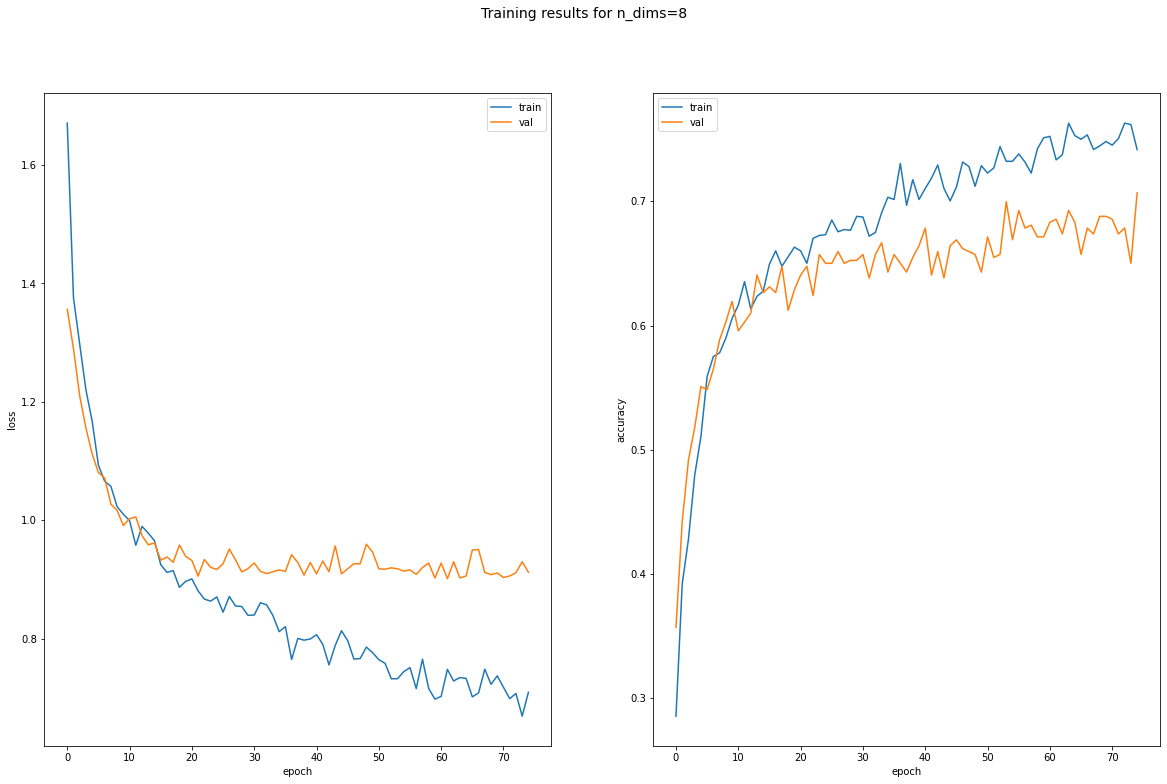

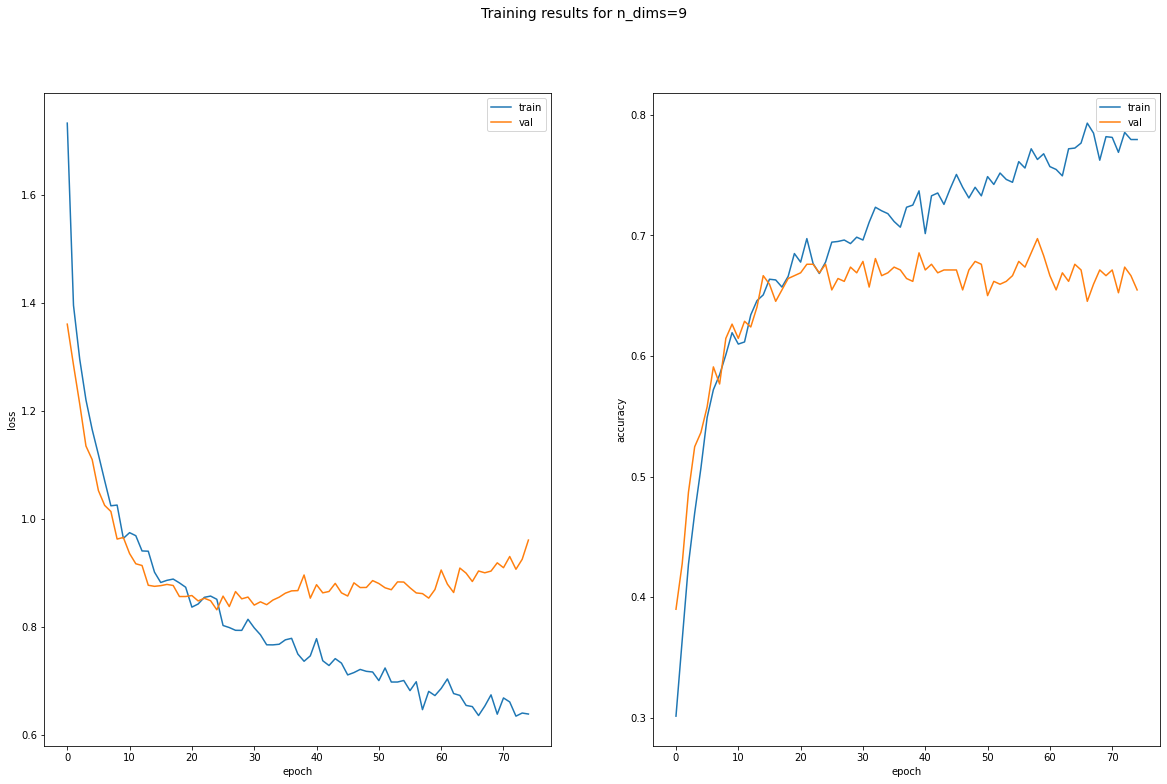

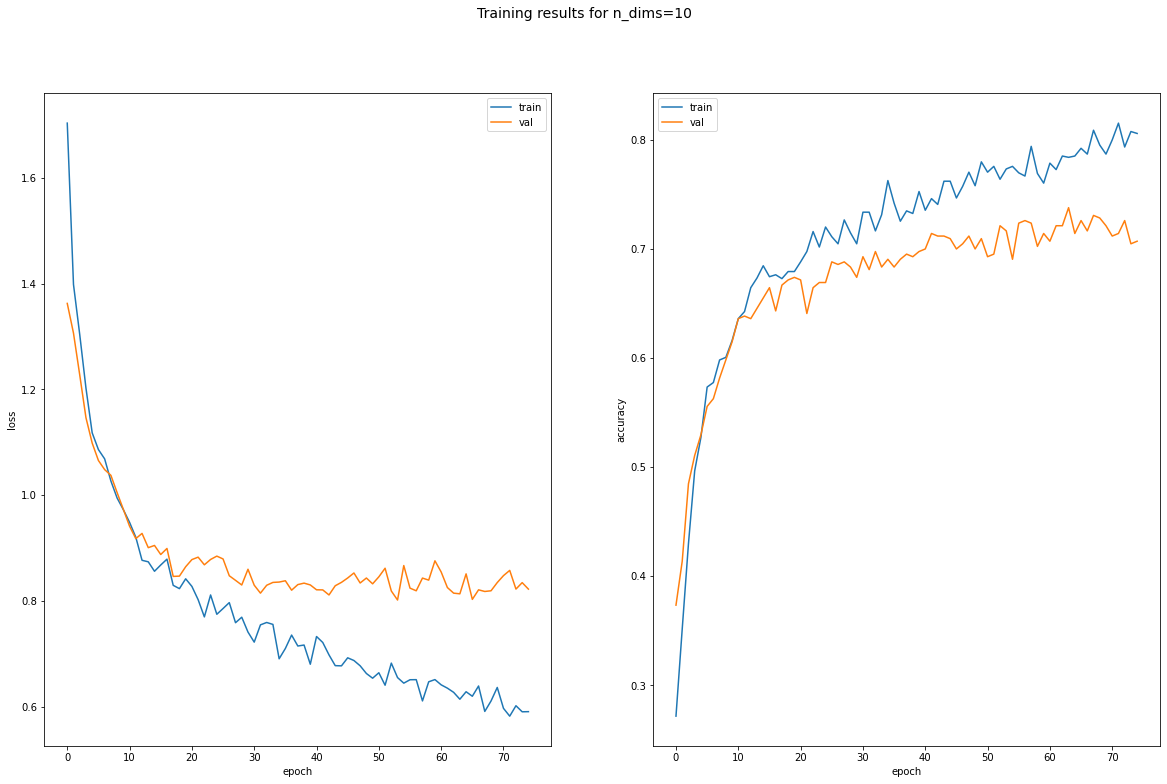

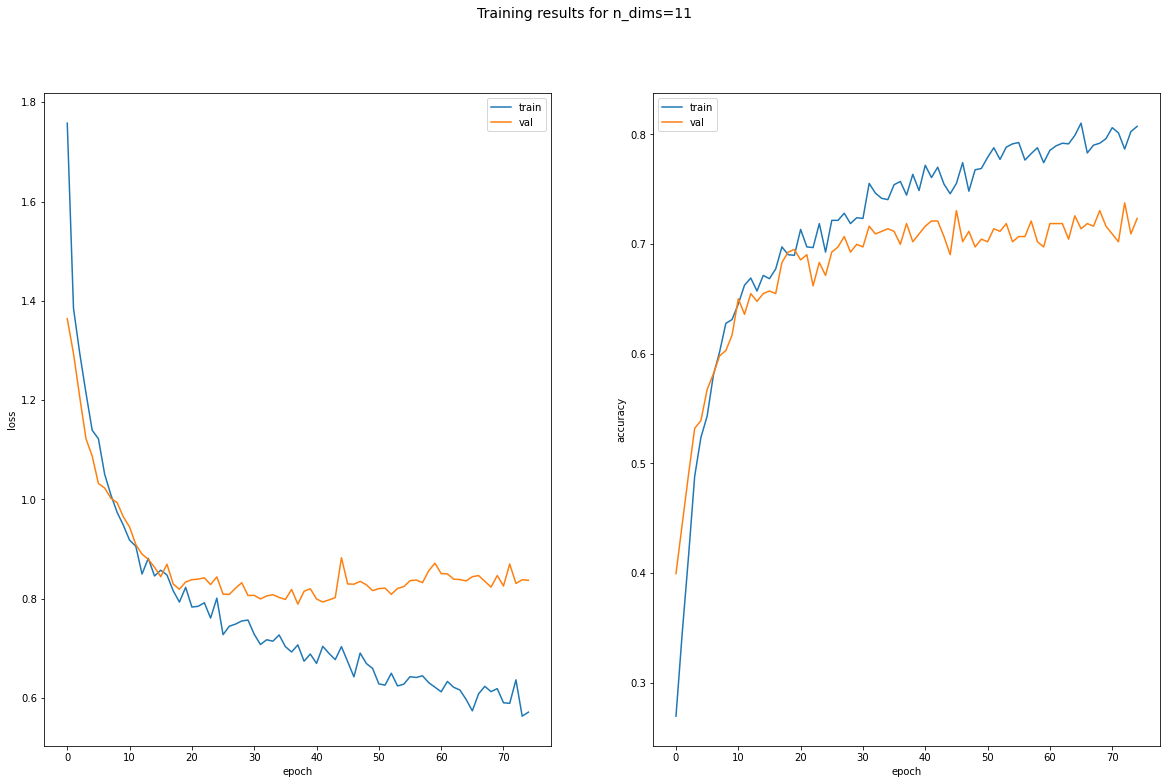

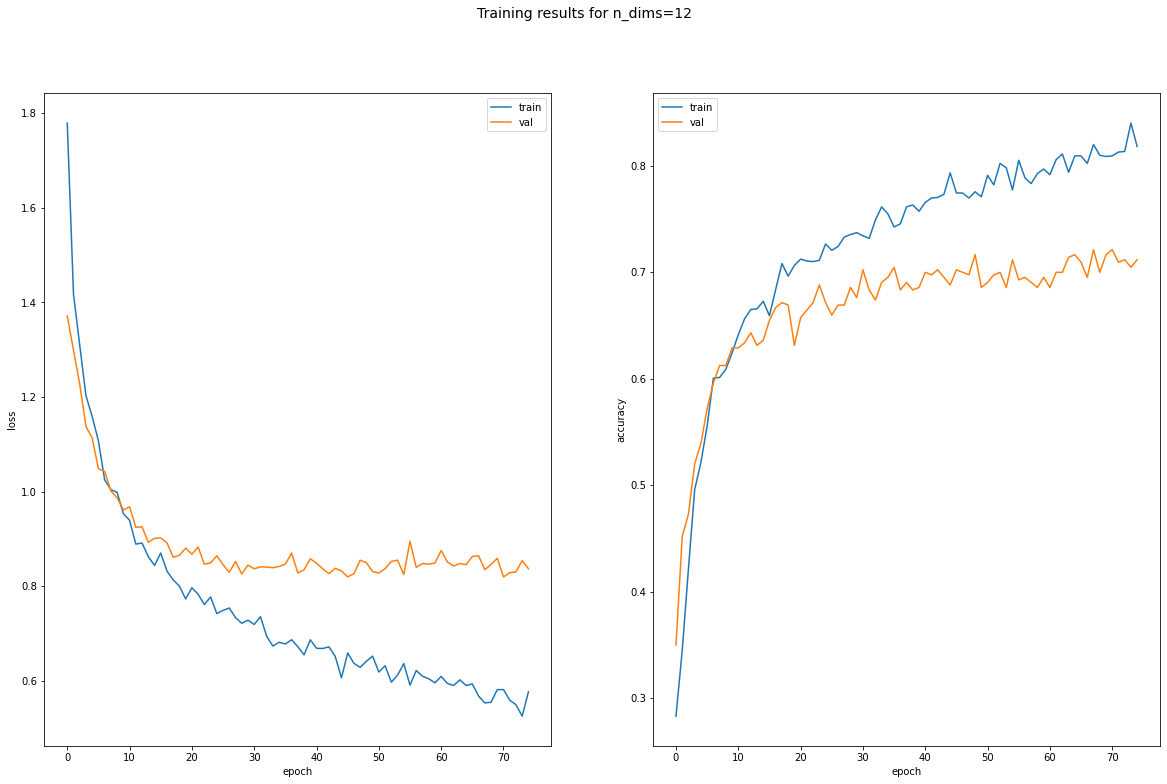

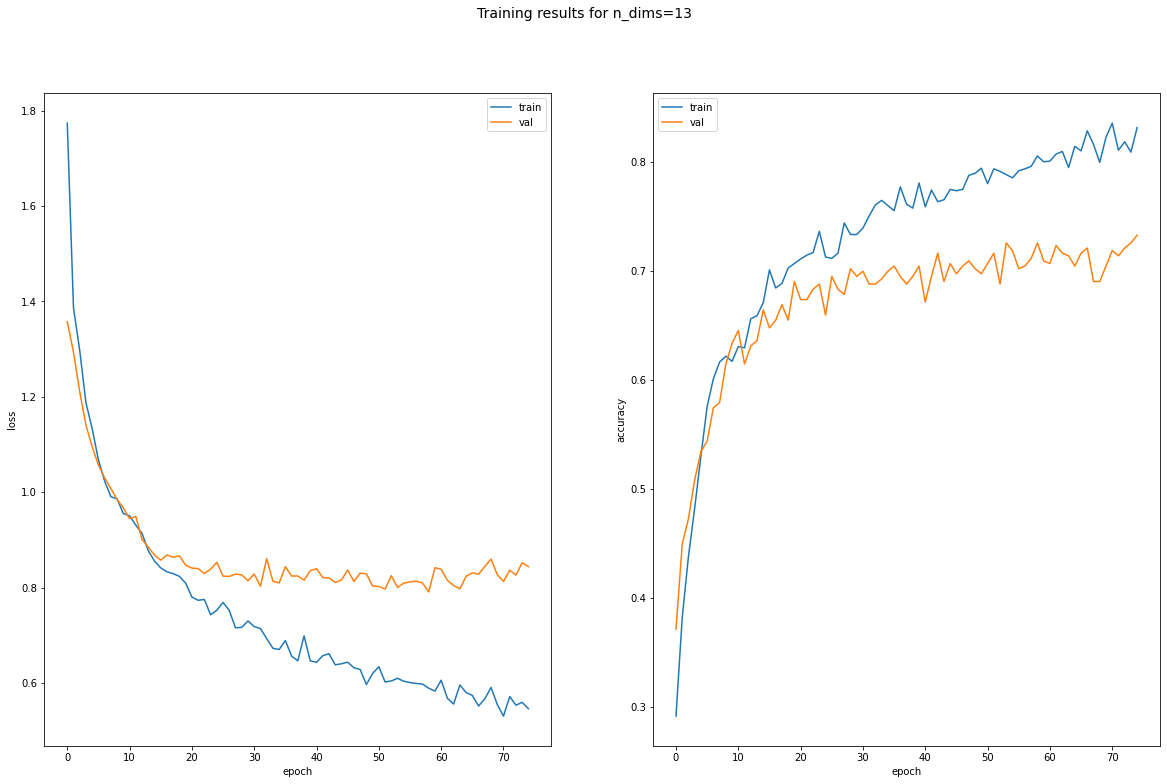

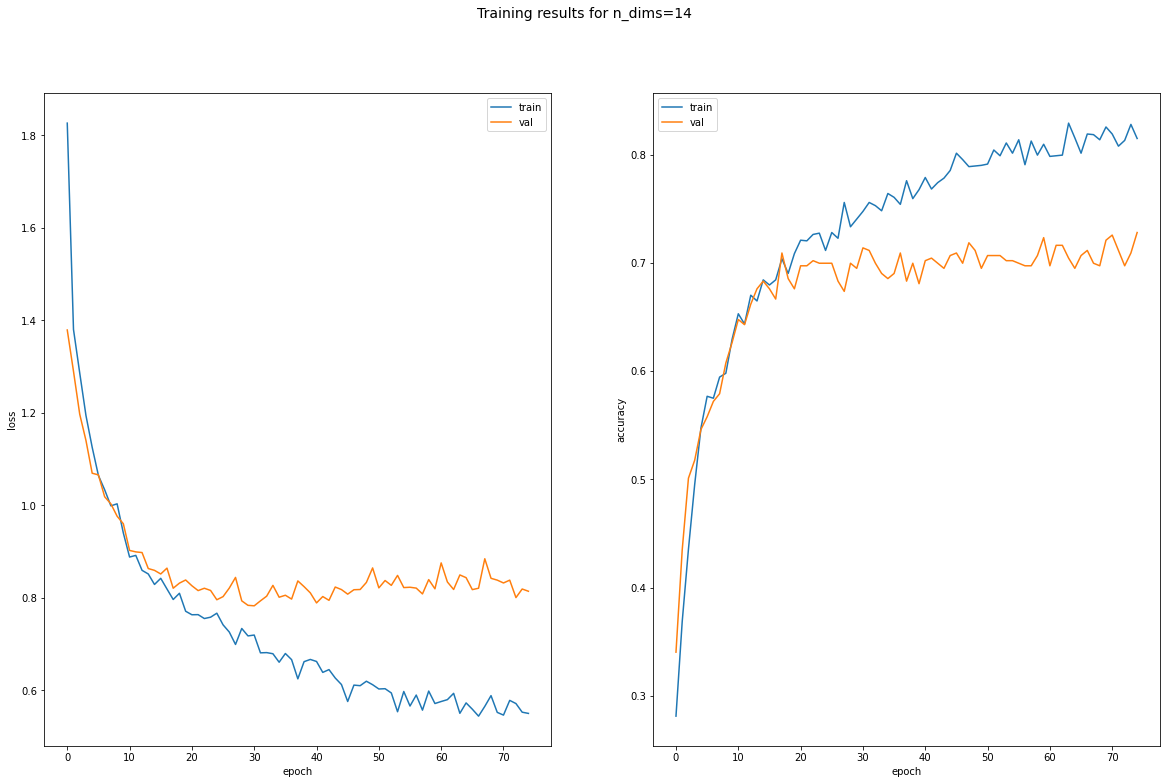

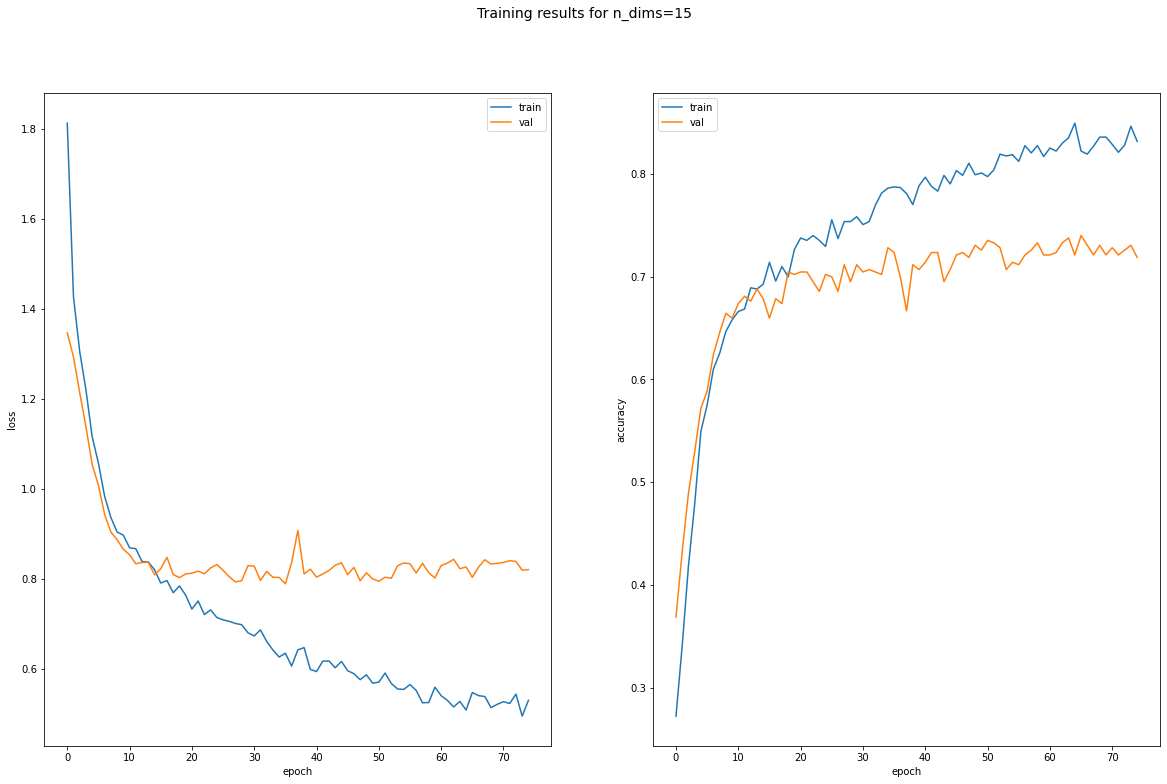

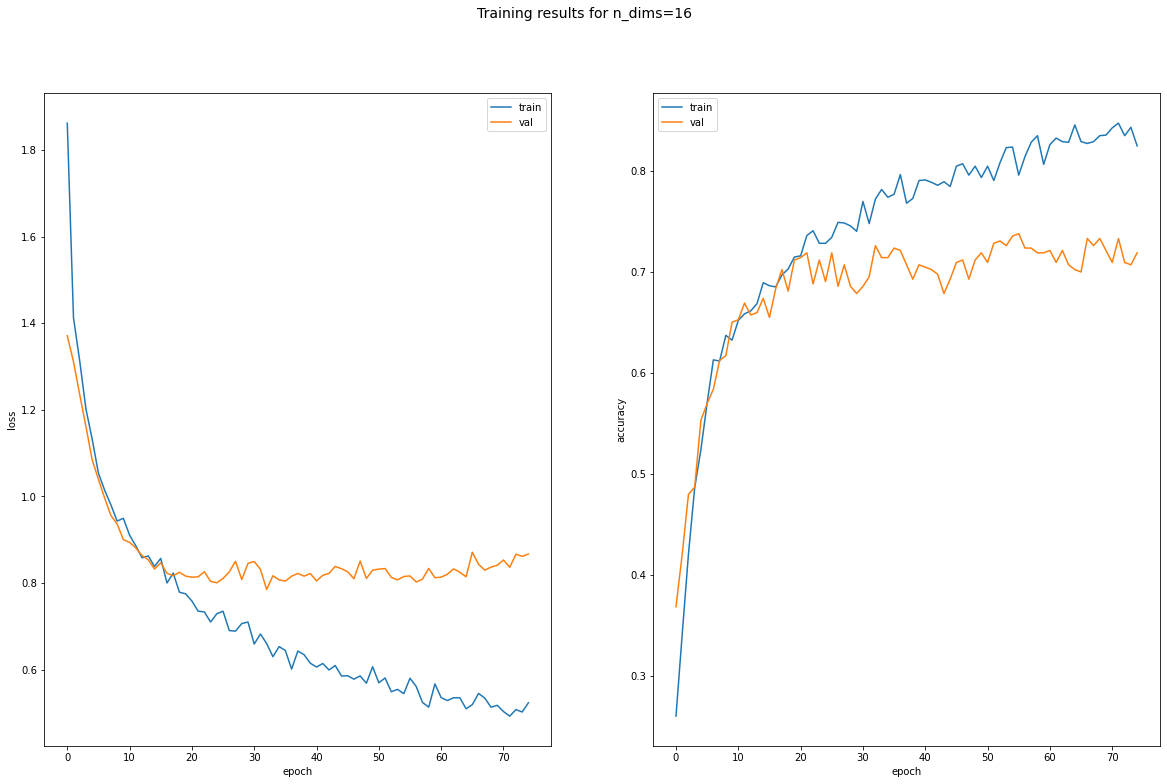

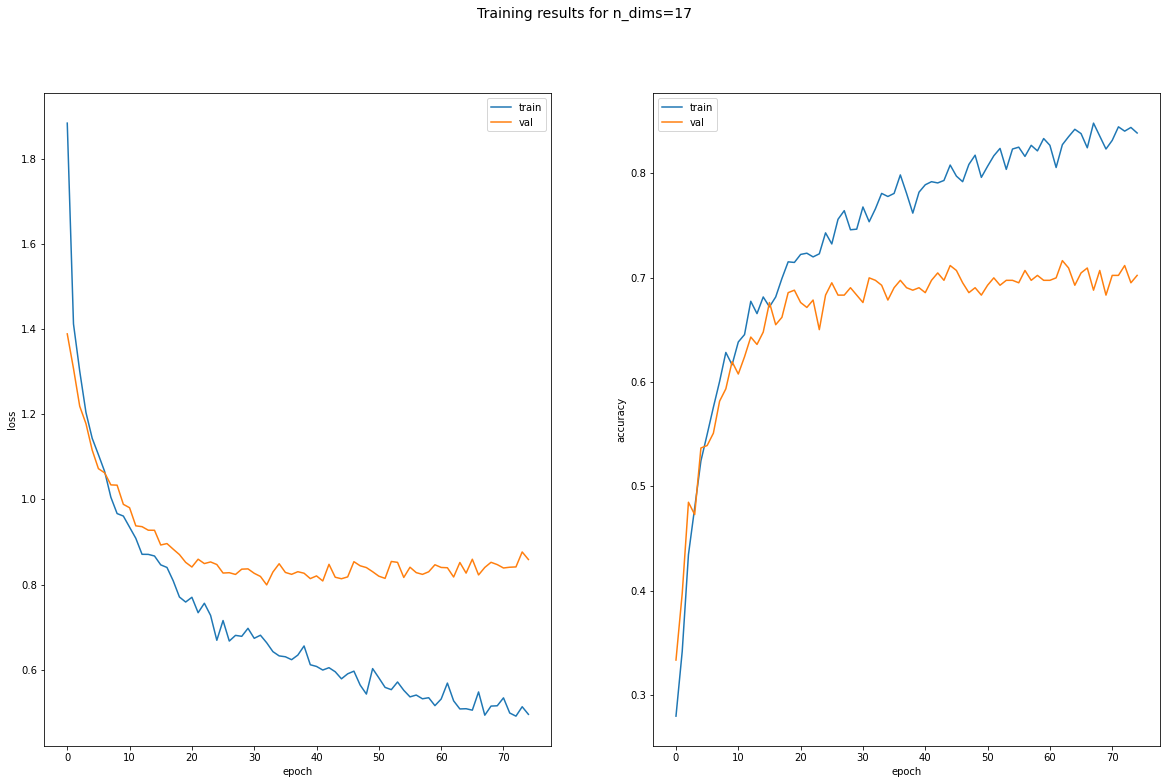

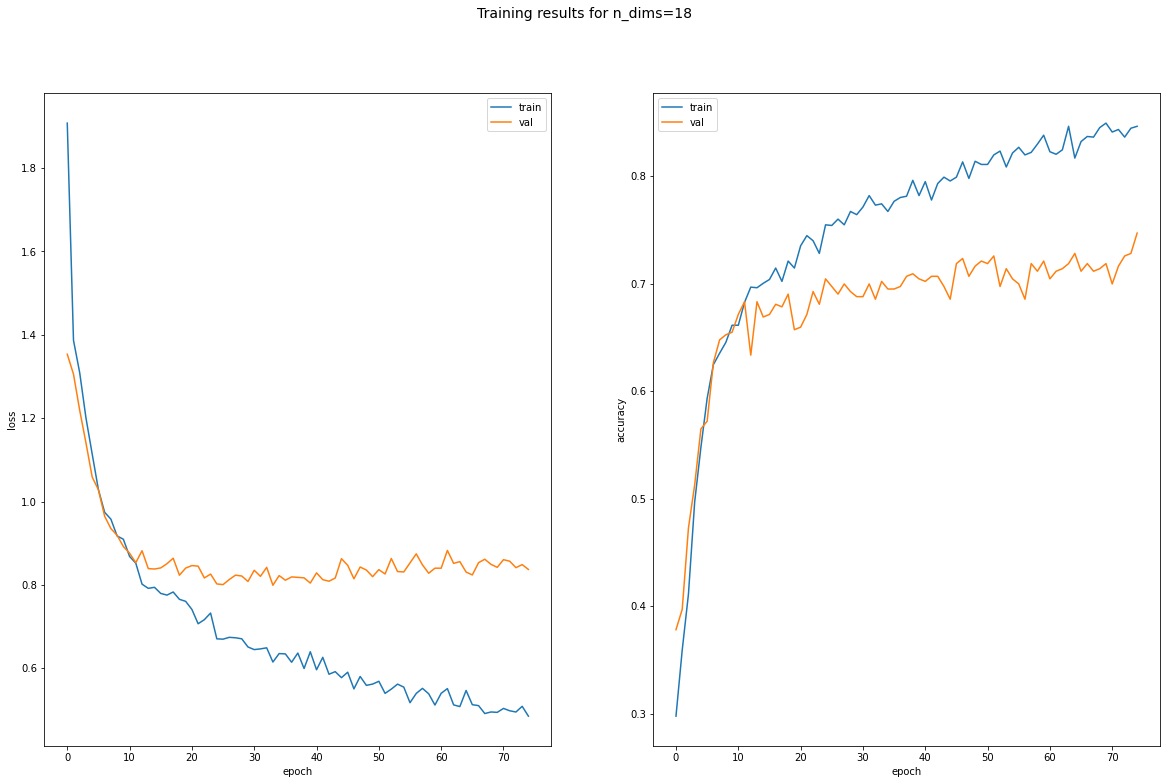

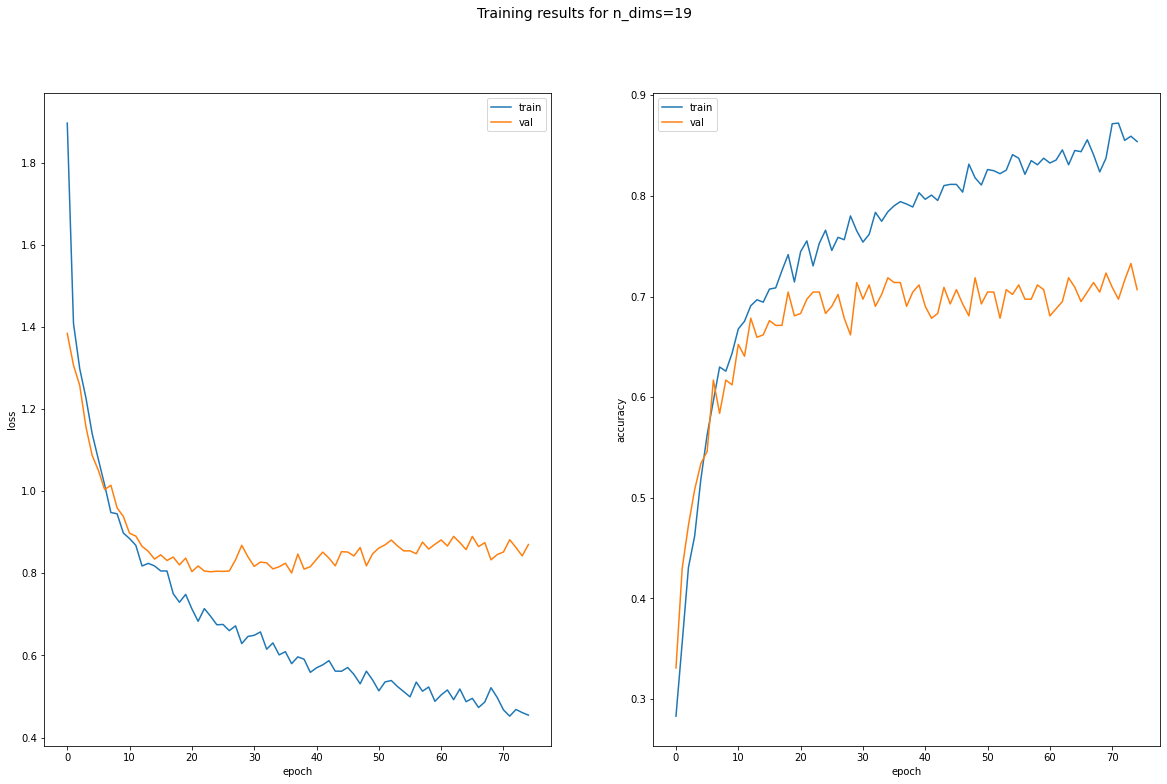

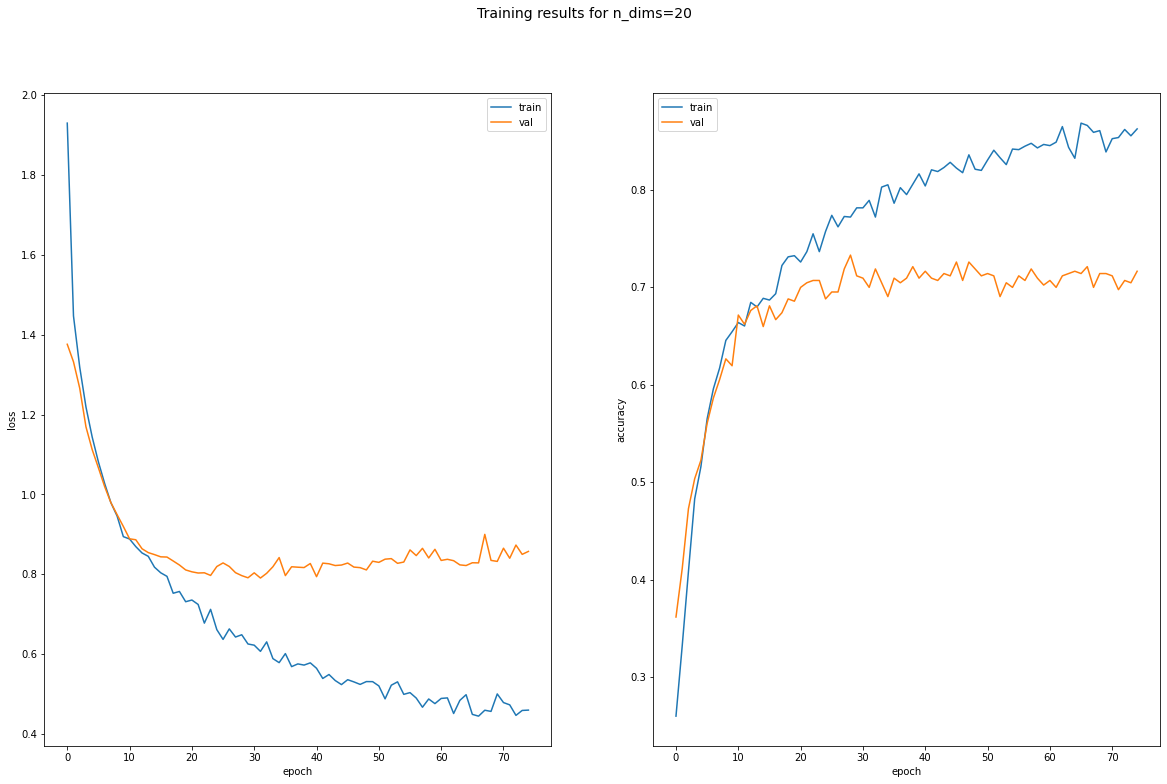

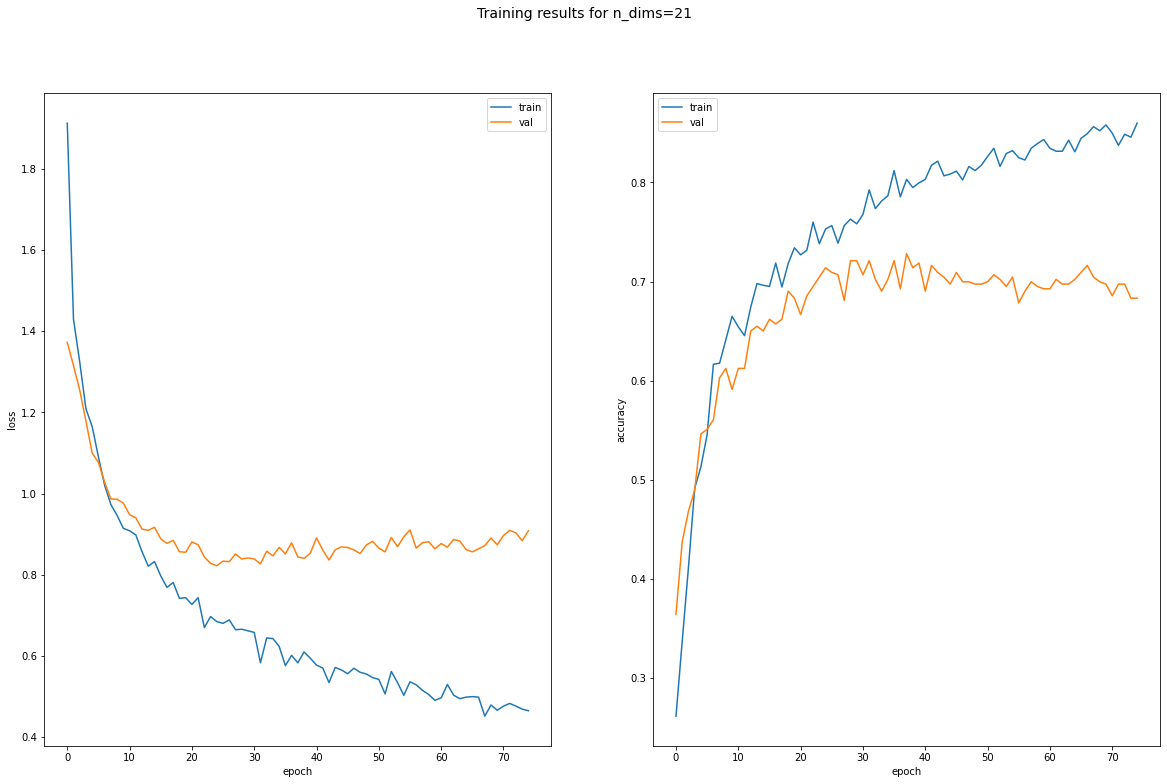

In [43]:
for n_comp in range(8, 22):
    print("Testing PCA Network for n_dims = {}".format(n_comp))
    
    X_train_valid_reshaped = X_train_valid_flipped.reshape((X_train_valid_norm_cropped.shape[0]*X_train_valid_norm_cropped.shape[2], 22)) 
    #print(X_train_valid_reshaped.shape)
    X_test_flipped = np.transpose(X_test_norm_cropped, (0,2,1))
    X_test_reshaped = X_test_flipped.reshape((X_test_norm_cropped.shape[0]*X_test_norm_cropped.shape[2], 22)) 


    #try a PCA on the data
    #reshaped_data = X_train_valid_flipped.reshape((X_train_valid_cropped.shape[1]*X_train_valid_cropped.shape[2], 22))    # create one big data panel with 20 series and 300.000 datapoints
                                          #choose the number of features to have after dimensionality reduction
    pca = PCA(n_components=n_comp)                  #create the pca object       
    pca.fit(X_train_valid_reshaped)                               #fit it to your transformed data
    X_train_valid_transformed=np.empty([X_train_valid_norm_cropped.shape[0],X_train_valid_norm_cropped.shape[2],n_comp])
    for i in range(len(X_train_valid_flipped)):
        #print(X_train_valid_flipped[i].shape)
        X_train_valid_transformed[i]=pca.transform(X_train_valid_flipped[i])           #iteratively apply the transformation to each instance of the original dataset


    #print(X_train_valid_transformed.shape)    #we end up with examples*timesteps*channels
    #now transpose back to examples*channels*timesteps
    X_train_valid_transformed = np.transpose(X_train_valid_transformed, (0,2,1))

    #n_comp=4                                      #choose the number of features to have after dimensionality reduction
    pca = PCA(n_components=n_comp)                  #create the pca object       
    pca.fit(X_test_reshaped)                               #fit it to your transformed data
    X_test_transformed=np.empty([X_test_norm_cropped.shape[0],X_test_norm_cropped.shape[2],n_comp])
    #print(X_test_transformed.shape)
    for i in range(len(X_test_flipped)):
        #print(X_test_flipped[i].shape)
        X_test_transformed[i]=pca.transform(X_test_flipped[i])           #iteratively apply the transformation to each instance of the original dataset

    #print(X_test_transformed.shape)    #we end up with examples*timesteps*channels
    #now transpose back to examples*channels*timesteps
    X_test_transformed = np.transpose(X_test_transformed, (0,2,1))
    
    input_ = layers.Input(shape=(n_comp, 500))
    r1 = layers.Reshape(target_shape=(n_comp, 500, 1))(input_)
    c1 = layers.Conv2D(filters=40, kernel_size=(1,25), data_format='channels_last',
                       activation='elu', kernel_regularizer='l2')(r1)
    p1 = layers.Permute(dims=(2,1,3))(c1)
    r2 = layers.Reshape((476, n_comp*40))(p1)
    d1 = layers.Dense(40, activation='elu')(r2)
    sq1 = layers.Activation(ksquare)(d1)
    ap1 = layers.AveragePooling1D(75, strides=15)(sq1)
    log1 = layers.Activation(klog)(ap1)
    f1 = layers.Flatten()(log1)
    d2 = layers.Dropout(0.80)(f1)
    output_ = layers.Dense(4, activation='softmax', kernel_regularizer='l2', kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01))(d2)
    
    model = models.Model(inputs=input_, outputs=output_, name='shallow_convnet_one_hot')
    #opt = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    model.summary()
    
    loss_hist = model.fit(X_train_valid_transformed, y_train_valid_1h, 
                      validation_split=0.2, epochs=75,
                      verbose=True)

    hist = loss_hist.history

    fig, axs = plt.subplots(1,2, figsize=(20, 12))

    fig.suptitle("Training results for n_dims={}".format(n_comp), fontsize=14)

    axs[0].plot(hist['loss'])
    axs[0].plot(hist['val_loss'])
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'])

    axs[1].plot(hist['acc'])
    axs[1].plot(hist['val_acc'])
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'])

Testing PCA Network for n_dims = 8
Model: "shallow_convnet_one_hot"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 8, 500)]          0         
_________________________________________________________________
reshape_64 (Reshape)         (None, 8, 500, 1)         0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 8, 476, 40)        1040      
_________________________________________________________________
permute_32 (Permute)         (None, 476, 8, 40)        0         
_________________________________________________________________
reshape_65 (Reshape)         (None, 476, 320)          0         
_________________________________________________________________
dense_64 (Dense)             (None, 476, 40)           12840     
_________________________________________________________________
activati

53/53 [==============================] - 3s 47ms/step - loss: 0.7391 - acc: 0.7169 - val_loss: 0.8709 - val_acc: 0.6832
Epoch 49/75
53/53 [==============================] - 3s 48ms/step - loss: 0.7437 - acc: 0.7323 - val_loss: 0.8756 - val_acc: 0.6856
Epoch 50/75
53/53 [==============================] - 3s 48ms/step - loss: 0.7803 - acc: 0.7139 - val_loss: 0.8863 - val_acc: 0.6714
Epoch 51/75
53/53 [==============================] - 3s 47ms/step - loss: 0.7386 - acc: 0.7364 - val_loss: 0.9009 - val_acc: 0.6690
Epoch 52/75
53/53 [==============================] - 3s 47ms/step - loss: 0.7150 - acc: 0.7541 - val_loss: 0.9057 - val_acc: 0.6596
Epoch 53/75
53/53 [==============================] - 3s 47ms/step - loss: 0.7392 - acc: 0.7340 - val_loss: 0.8941 - val_acc: 0.6832
Epoch 54/75
53/53 [==============================] - 3s 48ms/step - loss: 0.7376 - acc: 0.7394 - val_loss: 0.9054 - val_acc: 0.6596
Epoch 55/75
53/53 [==============================] - 2s 47ms/step - loss: 0.7207 - acc: 

53/53 [==============================] - 3s 53ms/step - loss: 0.8686 - acc: 0.6678 - val_loss: 0.8473 - val_acc: 0.6525
Epoch 21/75
53/53 [==============================] - 3s 53ms/step - loss: 0.8567 - acc: 0.6891 - val_loss: 0.8494 - val_acc: 0.6572
Epoch 22/75
53/53 [==============================] - 3s 53ms/step - loss: 0.8654 - acc: 0.6702 - val_loss: 0.8514 - val_acc: 0.6643
Epoch 23/75
53/53 [==============================] - 3s 53ms/step - loss: 0.8632 - acc: 0.6714 - val_loss: 0.8518 - val_acc: 0.6619
Epoch 24/75
53/53 [==============================] - 3s 53ms/step - loss: 0.8523 - acc: 0.6797 - val_loss: 0.8355 - val_acc: 0.6714
Epoch 25/75
53/53 [==============================] - 3s 53ms/step - loss: 0.8322 - acc: 0.6980 - val_loss: 0.8600 - val_acc: 0.6714
Epoch 26/75
53/53 [==============================] - 3s 53ms/step - loss: 0.8097 - acc: 0.6986 - val_loss: 0.8318 - val_acc: 0.6619
Epoch 27/75
53/53 [==============================] - 3s 52ms/step - loss: 0.8251 - acc: 

53/53 [==============================] - 3s 59ms/step - loss: 1.7524 - acc: 0.2612 - val_loss: 1.3594 - val_acc: 0.3593
Epoch 2/75
53/53 [==============================] - 3s 58ms/step - loss: 1.3904 - acc: 0.3522 - val_loss: 1.2853 - val_acc: 0.4303
Epoch 3/75
53/53 [==============================] - 3s 58ms/step - loss: 1.2594 - acc: 0.4533 - val_loss: 1.1993 - val_acc: 0.4657
Epoch 4/75
53/53 [==============================] - 3s 58ms/step - loss: 1.1890 - acc: 0.4982 - val_loss: 1.1469 - val_acc: 0.5035
Epoch 5/75
53/53 [==============================] - 3s 58ms/step - loss: 1.1402 - acc: 0.5284 - val_loss: 1.0915 - val_acc: 0.5437
Epoch 6/75
53/53 [==============================] - 3s 58ms/step - loss: 1.0973 - acc: 0.5479 - val_loss: 1.0515 - val_acc: 0.5816
Epoch 7/75
53/53 [==============================] - 3s 58ms/step - loss: 1.0524 - acc: 0.5757 - val_loss: 1.0067 - val_acc: 0.5934
Epoch 8/75
53/53 [==============================] - 3s 58ms/step - loss: 1.0237 - acc: 0.5816 

53/53 [==============================] - 3s 58ms/step - loss: 0.6117 - acc: 0.7819 - val_loss: 0.8608 - val_acc: 0.6832
Epoch 64/75
53/53 [==============================] - 3s 58ms/step - loss: 0.6197 - acc: 0.7890 - val_loss: 0.8327 - val_acc: 0.6998
Epoch 65/75
53/53 [==============================] - 3s 58ms/step - loss: 0.5973 - acc: 0.8121 - val_loss: 0.8373 - val_acc: 0.7092
Epoch 66/75
53/53 [==============================] - 3s 58ms/step - loss: 0.6138 - acc: 0.7902 - val_loss: 0.8424 - val_acc: 0.7092
Epoch 67/75
53/53 [==============================] - 3s 58ms/step - loss: 0.5972 - acc: 0.7979 - val_loss: 0.8615 - val_acc: 0.7045
Epoch 68/75
53/53 [==============================] - 3s 58ms/step - loss: 0.6091 - acc: 0.7902 - val_loss: 0.8424 - val_acc: 0.7069
Epoch 69/75
53/53 [==============================] - 3s 58ms/step - loss: 0.6136 - acc: 0.7843 - val_loss: 0.8369 - val_acc: 0.7021
Epoch 70/75
53/53 [==============================] - 3s 58ms/step - loss: 0.6020 - acc: 

53/53 [==============================] - 3s 63ms/step - loss: 0.7148 - acc: 0.7506 - val_loss: 0.8122 - val_acc: 0.6832
Epoch 36/75
53/53 [==============================] - 3s 63ms/step - loss: 0.6863 - acc: 0.7547 - val_loss: 0.8178 - val_acc: 0.6738
Epoch 37/75
53/53 [==============================] - 3s 63ms/step - loss: 0.7006 - acc: 0.7441 - val_loss: 0.8044 - val_acc: 0.6785
Epoch 38/75
53/53 [==============================] - 3s 63ms/step - loss: 0.6855 - acc: 0.7571 - val_loss: 0.8169 - val_acc: 0.7069
Epoch 39/75
53/53 [==============================] - 3s 63ms/step - loss: 0.6592 - acc: 0.7725 - val_loss: 0.8138 - val_acc: 0.6927
Epoch 40/75
53/53 [==============================] - 3s 63ms/step - loss: 0.6991 - acc: 0.7506 - val_loss: 0.8158 - val_acc: 0.7021
Epoch 41/75
53/53 [==============================] - 3s 64ms/step - loss: 0.6838 - acc: 0.7512 - val_loss: 0.8450 - val_acc: 0.6809
Epoch 42/75
53/53 [==============================] - 3s 63ms/step - loss: 0.7012 - acc: 

53/53 [==============================] - 4s 69ms/step - loss: 1.0036 - acc: 0.6158 - val_loss: 0.9915 - val_acc: 0.6028
Epoch 8/75
53/53 [==============================] - 4s 69ms/step - loss: 0.9917 - acc: 0.6123 - val_loss: 0.9457 - val_acc: 0.5934
Epoch 9/75
53/53 [==============================] - 4s 70ms/step - loss: 0.9449 - acc: 0.6306 - val_loss: 0.9187 - val_acc: 0.6288
Epoch 10/75
53/53 [==============================] - 4s 69ms/step - loss: 0.9059 - acc: 0.6353 - val_loss: 0.8992 - val_acc: 0.6525
Epoch 11/75
53/53 [==============================] - 4s 69ms/step - loss: 0.9101 - acc: 0.6513 - val_loss: 0.8791 - val_acc: 0.6667
Epoch 12/75
53/53 [==============================] - 4s 69ms/step - loss: 0.8746 - acc: 0.6619 - val_loss: 0.8859 - val_acc: 0.6667
Epoch 13/75
53/53 [==============================] - 4s 70ms/step - loss: 0.8429 - acc: 0.6826 - val_loss: 0.8539 - val_acc: 0.6596
Epoch 14/75
53/53 [==============================] - 4s 69ms/step - loss: 0.8497 - acc: 0.

53/53 [==============================] - 4s 69ms/step - loss: 0.5908 - acc: 0.7943 - val_loss: 0.8526 - val_acc: 0.7187
Epoch 70/75
53/53 [==============================] - 4s 69ms/step - loss: 0.6050 - acc: 0.8050 - val_loss: 0.8483 - val_acc: 0.7258
Epoch 71/75
53/53 [==============================] - 4s 69ms/step - loss: 0.5957 - acc: 0.8050 - val_loss: 0.8515 - val_acc: 0.7163
Epoch 72/75
53/53 [==============================] - 4s 68ms/step - loss: 0.5566 - acc: 0.8156 - val_loss: 0.8666 - val_acc: 0.7163
Epoch 73/75
53/53 [==============================] - 4s 69ms/step - loss: 0.5751 - acc: 0.8150 - val_loss: 0.8355 - val_acc: 0.7258
Epoch 74/75
53/53 [==============================] - 4s 69ms/step - loss: 0.5489 - acc: 0.8239 - val_loss: 0.8449 - val_acc: 0.7139
Epoch 75/75
53/53 [==============================] - 4s 68ms/step - loss: 0.5670 - acc: 0.8203 - val_loss: 0.8423 - val_acc: 0.7187
Testing PCA Network for n_dims = 13
Model: "shallow_convnet_one_hot"
___________________

53/53 [==============================] - 4s 73ms/step - loss: 0.6505 - acc: 0.7612 - val_loss: 0.8079 - val_acc: 0.6950
Epoch 42/75
53/53 [==============================] - 4s 72ms/step - loss: 0.6511 - acc: 0.7683 - val_loss: 0.7845 - val_acc: 0.6974
Epoch 43/75
53/53 [==============================] - 4s 73ms/step - loss: 0.6390 - acc: 0.7861 - val_loss: 0.8117 - val_acc: 0.7021
Epoch 44/75
53/53 [==============================] - 4s 73ms/step - loss: 0.6427 - acc: 0.7825 - val_loss: 0.8211 - val_acc: 0.6974
Epoch 45/75
53/53 [==============================] - 4s 73ms/step - loss: 0.6244 - acc: 0.7843 - val_loss: 0.8234 - val_acc: 0.6903
Epoch 46/75
53/53 [==============================] - 4s 73ms/step - loss: 0.6441 - acc: 0.7730 - val_loss: 0.8053 - val_acc: 0.7163
Epoch 47/75
53/53 [==============================] - 4s 73ms/step - loss: 0.6143 - acc: 0.7843 - val_loss: 0.8063 - val_acc: 0.7139
Epoch 48/75
53/53 [==============================] - 4s 73ms/step - loss: 0.6242 - acc: 

53/53 [==============================] - 4s 83ms/step - loss: 0.8627 - acc: 0.6755 - val_loss: 0.8817 - val_acc: 0.6619
Epoch 14/75
53/53 [==============================] - 4s 83ms/step - loss: 0.8549 - acc: 0.6714 - val_loss: 0.8976 - val_acc: 0.6619
Epoch 15/75
53/53 [==============================] - 4s 83ms/step - loss: 0.8670 - acc: 0.6608 - val_loss: 0.8700 - val_acc: 0.6548
Epoch 16/75
53/53 [==============================] - 5s 85ms/step - loss: 0.7986 - acc: 0.6891 - val_loss: 0.8579 - val_acc: 0.6714
Epoch 17/75
53/53 [==============================] - 4s 84ms/step - loss: 0.8021 - acc: 0.6844 - val_loss: 0.8666 - val_acc: 0.6738
Epoch 18/75
53/53 [==============================] - 4s 83ms/step - loss: 0.8184 - acc: 0.6874 - val_loss: 0.8550 - val_acc: 0.6856
Epoch 19/75
53/53 [==============================] - 4s 84ms/step - loss: 0.7779 - acc: 0.7080 - val_loss: 0.8472 - val_acc: 0.6738
Epoch 20/75
53/53 [==============================] - 4s 83ms/step - loss: 0.7947 - acc: 

53/53 [==============================] - 5s 85ms/step - loss: 0.5254 - acc: 0.8369 - val_loss: 0.8063 - val_acc: 0.7305
Testing PCA Network for n_dims = 15
Model: "shallow_convnet_one_hot"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        [(None, 15, 500)]         0         
_________________________________________________________________
reshape_78 (Reshape)         (None, 15, 500, 1)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 15, 476, 40)       1040      
_________________________________________________________________
permute_39 (Permute)         (None, 476, 15, 40)       0         
_________________________________________________________________
reshape_79 (Reshape)         (None, 476, 600)          0         
_________________________________________________________________
dense_78 (Dense)   

53/53 [==============================] - 5s 90ms/step - loss: 0.5863 - acc: 0.7979 - val_loss: 0.7699 - val_acc: 0.6974
Epoch 48/75
53/53 [==============================] - 5s 91ms/step - loss: 0.5907 - acc: 0.7943 - val_loss: 0.7809 - val_acc: 0.7163
Epoch 49/75
53/53 [==============================] - 5s 90ms/step - loss: 0.5596 - acc: 0.8097 - val_loss: 0.7903 - val_acc: 0.6998
Epoch 50/75
53/53 [==============================] - 5s 90ms/step - loss: 0.5563 - acc: 0.8067 - val_loss: 0.7992 - val_acc: 0.7045
Epoch 51/75
53/53 [==============================] - 5s 90ms/step - loss: 0.6043 - acc: 0.7973 - val_loss: 0.7839 - val_acc: 0.7069
Epoch 52/75
53/53 [==============================] - 5s 90ms/step - loss: 0.5702 - acc: 0.8056 - val_loss: 0.8045 - val_acc: 0.7139
Epoch 53/75
53/53 [==============================] - 5s 90ms/step - loss: 0.5778 - acc: 0.7931 - val_loss: 0.7940 - val_acc: 0.7234
Epoch 54/75
53/53 [==============================] - 5s 90ms/step - loss: 0.6123 - acc: 

53/53 [==============================] - 5s 95ms/step - loss: 0.7712 - acc: 0.7092 - val_loss: 0.7998 - val_acc: 0.6927
Epoch 20/75
53/53 [==============================] - 5s 97ms/step - loss: 0.7430 - acc: 0.7335 - val_loss: 0.8121 - val_acc: 0.6903
Epoch 21/75
53/53 [==============================] - 5s 95ms/step - loss: 0.7490 - acc: 0.7210 - val_loss: 0.7976 - val_acc: 0.7021
Epoch 22/75
53/53 [==============================] - 5s 95ms/step - loss: 0.7106 - acc: 0.7317 - val_loss: 0.8098 - val_acc: 0.7045
Epoch 23/75
53/53 [==============================] - 5s 96ms/step - loss: 0.7360 - acc: 0.7352 - val_loss: 0.7964 - val_acc: 0.6974
Epoch 24/75
53/53 [==============================] - 5s 96ms/step - loss: 0.7130 - acc: 0.7459 - val_loss: 0.8271 - val_acc: 0.6809
Epoch 25/75
53/53 [==============================] - 5s 96ms/step - loss: 0.6882 - acc: 0.7541 - val_loss: 0.8085 - val_acc: 0.6832
Epoch 26/75
53/53 [==============================] - 5s 95ms/step - loss: 0.7131 - acc: 

Epoch 1/75
53/53 [==============================] - 5s 103ms/step - loss: 1.8319 - acc: 0.2624 - val_loss: 1.3837 - val_acc: 0.3688
Epoch 2/75
53/53 [==============================] - 5s 101ms/step - loss: 1.4309 - acc: 0.3422 - val_loss: 1.3246 - val_acc: 0.4019
Epoch 3/75
53/53 [==============================] - 5s 103ms/step - loss: 1.3342 - acc: 0.4102 - val_loss: 1.2612 - val_acc: 0.4634
Epoch 4/75
53/53 [==============================] - 6s 104ms/step - loss: 1.2415 - acc: 0.4710 - val_loss: 1.1801 - val_acc: 0.5035
Epoch 5/75
53/53 [==============================] - 5s 103ms/step - loss: 1.1608 - acc: 0.5065 - val_loss: 1.1024 - val_acc: 0.5626
Epoch 6/75
53/53 [==============================] - 5s 102ms/step - loss: 1.1156 - acc: 0.5426 - val_loss: 1.0786 - val_acc: 0.5366
Epoch 7/75
53/53 [==============================] - 5s 103ms/step - loss: 1.0683 - acc: 0.5632 - val_loss: 1.0392 - val_acc: 0.5650
Epoch 8/75
53/53 [==============================] - 6s 105ms/step - loss: 1.

53/53 [==============================] - 5s 102ms/step - loss: 0.5481 - acc: 0.8168 - val_loss: 0.8932 - val_acc: 0.7069
Epoch 63/75
53/53 [==============================] - 5s 103ms/step - loss: 0.5526 - acc: 0.8168 - val_loss: 0.8889 - val_acc: 0.7092
Epoch 64/75
53/53 [==============================] - 5s 103ms/step - loss: 0.5355 - acc: 0.8203 - val_loss: 0.8732 - val_acc: 0.6974
Epoch 65/75
53/53 [==============================] - 5s 102ms/step - loss: 0.5144 - acc: 0.8327 - val_loss: 0.8815 - val_acc: 0.7163
Epoch 66/75
53/53 [==============================] - 5s 103ms/step - loss: 0.5144 - acc: 0.8339 - val_loss: 0.8658 - val_acc: 0.7045
Epoch 67/75
53/53 [==============================] - 5s 103ms/step - loss: 0.5269 - acc: 0.8345 - val_loss: 0.8729 - val_acc: 0.7092
Epoch 68/75
53/53 [==============================] - 5s 102ms/step - loss: 0.5284 - acc: 0.8292 - val_loss: 0.8564 - val_acc: 0.7139
Epoch 69/75
53/53 [==============================] - 5s 103ms/step - loss: 0.5358

Epoch 34/75
53/53 [==============================] - 6s 108ms/step - loss: 0.6493 - acc: 0.7677 - val_loss: 0.8220 - val_acc: 0.6903
Epoch 35/75
53/53 [==============================] - 6s 108ms/step - loss: 0.6316 - acc: 0.7701 - val_loss: 0.8236 - val_acc: 0.7045
Epoch 36/75
53/53 [==============================] - 6s 108ms/step - loss: 0.6300 - acc: 0.7884 - val_loss: 0.8423 - val_acc: 0.7045
Epoch 37/75
53/53 [==============================] - 6s 109ms/step - loss: 0.6219 - acc: 0.7790 - val_loss: 0.8155 - val_acc: 0.6998
Epoch 38/75
53/53 [==============================] - 6s 109ms/step - loss: 0.6317 - acc: 0.7778 - val_loss: 0.8150 - val_acc: 0.6974
Epoch 39/75
53/53 [==============================] - 6s 109ms/step - loss: 0.6299 - acc: 0.7855 - val_loss: 0.8013 - val_acc: 0.6950
Epoch 40/75
53/53 [==============================] - 6s 108ms/step - loss: 0.6411 - acc: 0.7665 - val_loss: 0.8508 - val_acc: 0.6761
Epoch 41/75
53/53 [==============================] - 6s 109ms/step - 

Epoch 6/75
53/53 [==============================] - 6s 115ms/step - loss: 1.0864 - acc: 0.5449 - val_loss: 1.0430 - val_acc: 0.5650
Epoch 7/75
53/53 [==============================] - 6s 120ms/step - loss: 1.0067 - acc: 0.6034 - val_loss: 0.9706 - val_acc: 0.5934
Epoch 8/75
53/53 [==============================] - 6s 116ms/step - loss: 0.9605 - acc: 0.6312 - val_loss: 0.9412 - val_acc: 0.6076
Epoch 9/75
53/53 [==============================] - 6s 115ms/step - loss: 0.9685 - acc: 0.6129 - val_loss: 0.9077 - val_acc: 0.6407
Epoch 10/75
53/53 [==============================] - 6s 115ms/step - loss: 0.8895 - acc: 0.6625 - val_loss: 0.8822 - val_acc: 0.6525
Epoch 11/75
53/53 [==============================] - 6s 115ms/step - loss: 0.8847 - acc: 0.6631 - val_loss: 0.8660 - val_acc: 0.6738
Epoch 12/75
53/53 [==============================] - 6s 116ms/step - loss: 0.8574 - acc: 0.6791 - val_loss: 0.8722 - val_acc: 0.6478
Epoch 13/75
53/53 [==============================] - 6s 116ms/step - loss

53/53 [==============================] - 6s 116ms/step - loss: 0.4940 - acc: 0.8339 - val_loss: 0.8066 - val_acc: 0.7021
Epoch 68/75
53/53 [==============================] - 6s 116ms/step - loss: 0.4960 - acc: 0.8416 - val_loss: 0.7909 - val_acc: 0.7163
Epoch 69/75
53/53 [==============================] - 6s 115ms/step - loss: 0.4565 - acc: 0.8647 - val_loss: 0.8054 - val_acc: 0.7139
Epoch 70/75
53/53 [==============================] - 6s 115ms/step - loss: 0.4859 - acc: 0.8552 - val_loss: 0.8196 - val_acc: 0.7210
Epoch 71/75
53/53 [==============================] - 6s 116ms/step - loss: 0.4909 - acc: 0.8452 - val_loss: 0.8180 - val_acc: 0.7092
Epoch 72/75
53/53 [==============================] - 6s 116ms/step - loss: 0.4522 - acc: 0.8670 - val_loss: 0.8543 - val_acc: 0.7021
Epoch 73/75
53/53 [==============================] - 6s 115ms/step - loss: 0.4778 - acc: 0.8576 - val_loss: 0.8293 - val_acc: 0.6998
Epoch 74/75
53/53 [==============================] - 6s 116ms/step - loss: 0.4581

Epoch 39/75
53/53 [==============================] - 7s 123ms/step - loss: 0.6125 - acc: 0.7884 - val_loss: 0.8559 - val_acc: 0.6998
Epoch 40/75
53/53 [==============================] - 7s 124ms/step - loss: 0.5633 - acc: 0.8150 - val_loss: 0.8459 - val_acc: 0.7163
Epoch 41/75
53/53 [==============================] - 7s 125ms/step - loss: 0.6265 - acc: 0.7825 - val_loss: 0.8496 - val_acc: 0.7139
Epoch 42/75
53/53 [==============================] - 7s 124ms/step - loss: 0.5934 - acc: 0.7855 - val_loss: 0.8689 - val_acc: 0.7021
Epoch 43/75
53/53 [==============================] - 7s 124ms/step - loss: 0.5756 - acc: 0.7967 - val_loss: 0.8487 - val_acc: 0.7116
Epoch 44/75
53/53 [==============================] - 7s 124ms/step - loss: 0.5603 - acc: 0.7979 - val_loss: 0.8861 - val_acc: 0.6974
Epoch 45/75
53/53 [==============================] - 7s 124ms/step - loss: 0.6050 - acc: 0.7890 - val_loss: 0.8646 - val_acc: 0.7021
Epoch 46/75
53/53 [==============================] - 7s 123ms/step - 

Epoch 11/75
53/53 [==============================] - 7s 129ms/step - loss: 0.8816 - acc: 0.6608 - val_loss: 0.9506 - val_acc: 0.6099
Epoch 12/75
53/53 [==============================] - 7s 128ms/step - loss: 0.8708 - acc: 0.6696 - val_loss: 0.9208 - val_acc: 0.6288
Epoch 13/75
53/53 [==============================] - 7s 129ms/step - loss: 0.8375 - acc: 0.6702 - val_loss: 0.8927 - val_acc: 0.6336
Epoch 14/75
53/53 [==============================] - 7s 129ms/step - loss: 0.8230 - acc: 0.6844 - val_loss: 0.9074 - val_acc: 0.6454
Epoch 15/75
53/53 [==============================] - 7s 129ms/step - loss: 0.8413 - acc: 0.6903 - val_loss: 0.8746 - val_acc: 0.6572
Epoch 16/75
53/53 [==============================] - 7s 128ms/step - loss: 0.7988 - acc: 0.6974 - val_loss: 0.8881 - val_acc: 0.6643
Epoch 17/75
53/53 [==============================] - 7s 129ms/step - loss: 0.7743 - acc: 0.7009 - val_loss: 0.8343 - val_acc: 0.6809
Epoch 18/75
53/53 [==============================] - 7s 128ms/step - 

53/53 [==============================] - 7s 129ms/step - loss: 0.4643 - acc: 0.8493 - val_loss: 0.8806 - val_acc: 0.7092
Epoch 73/75
53/53 [==============================] - 7s 128ms/step - loss: 0.4785 - acc: 0.8387 - val_loss: 0.8802 - val_acc: 0.7092
Epoch 74/75
53/53 [==============================] - 7s 129ms/step - loss: 0.4607 - acc: 0.8576 - val_loss: 0.8829 - val_acc: 0.7139
Epoch 75/75
53/53 [==============================] - 7s 129ms/step - loss: 0.4598 - acc: 0.8564 - val_loss: 0.9142 - val_acc: 0.6809


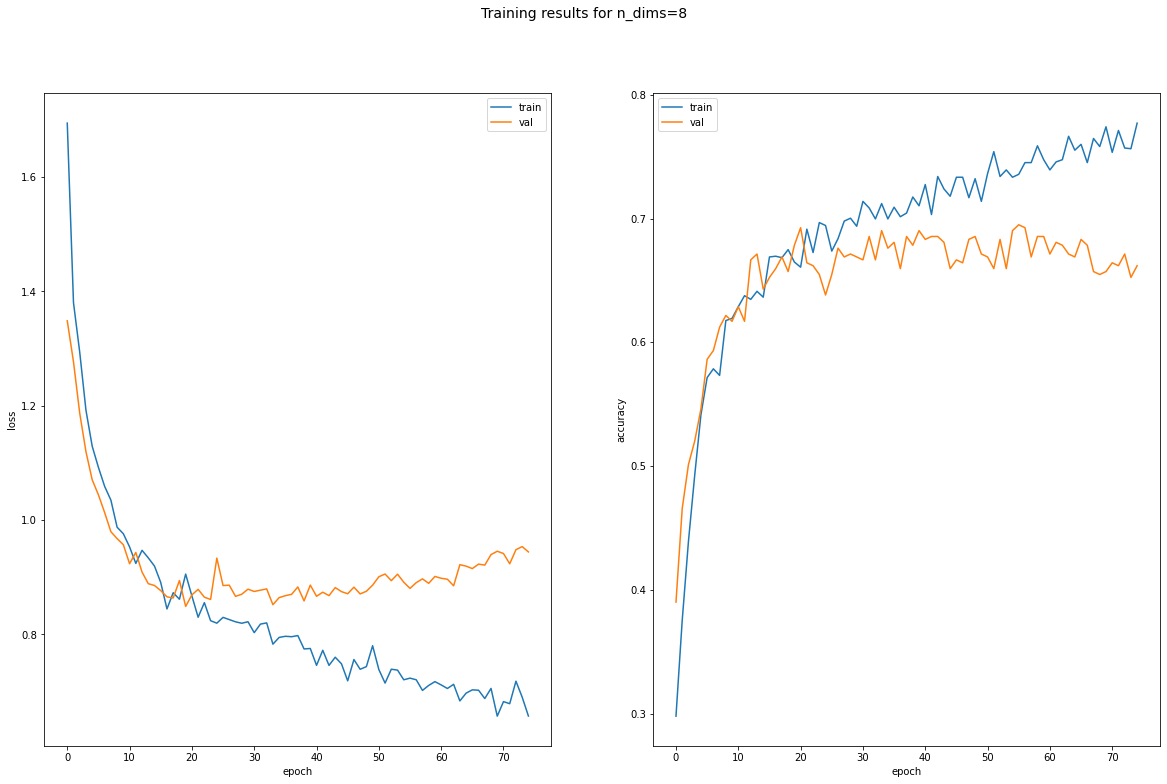

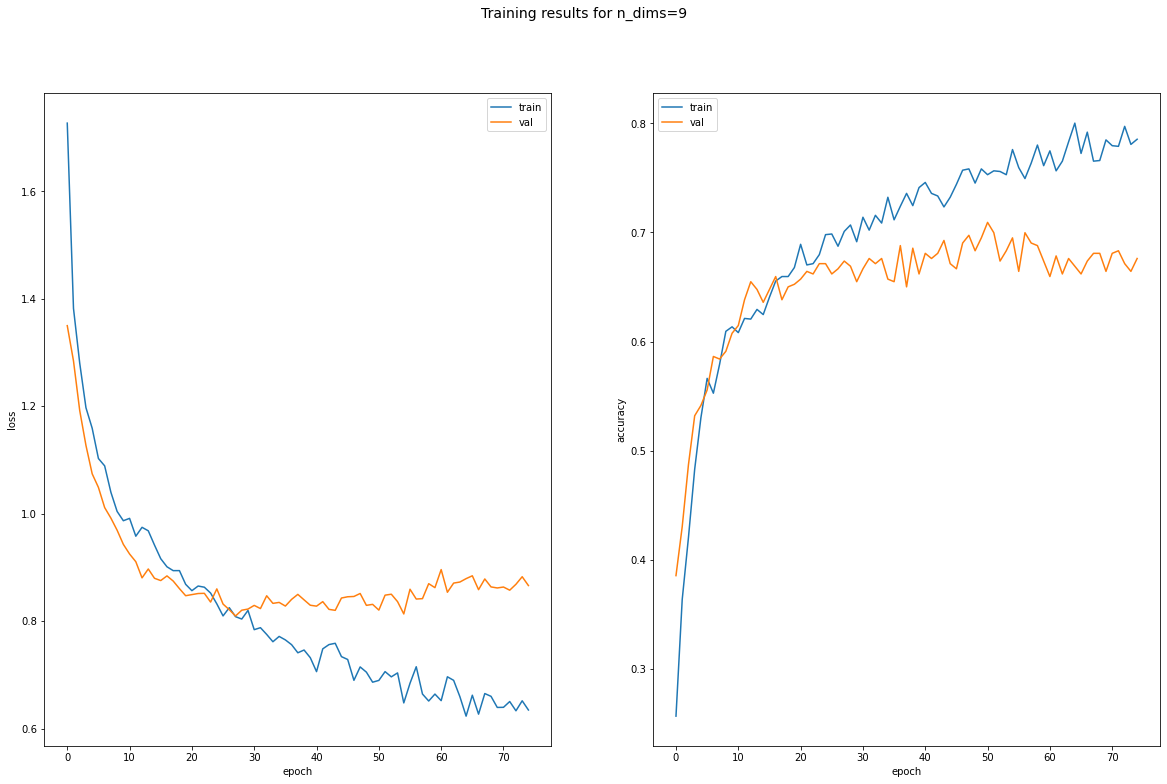

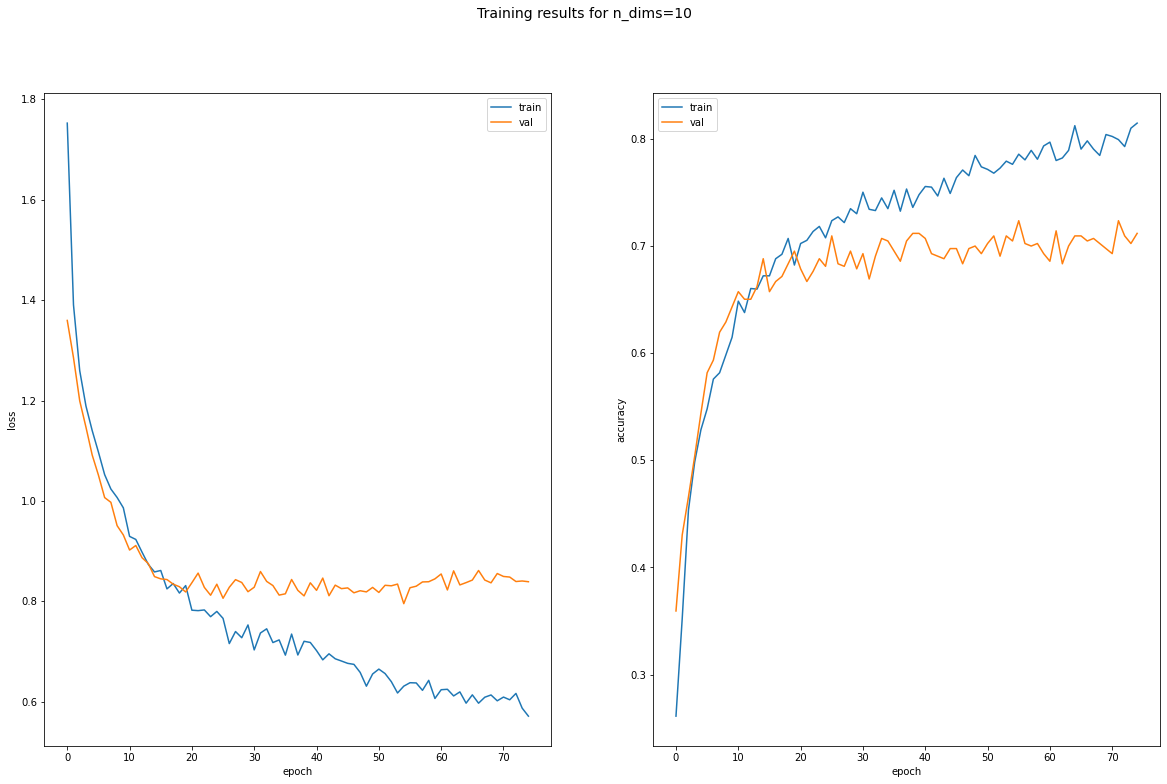

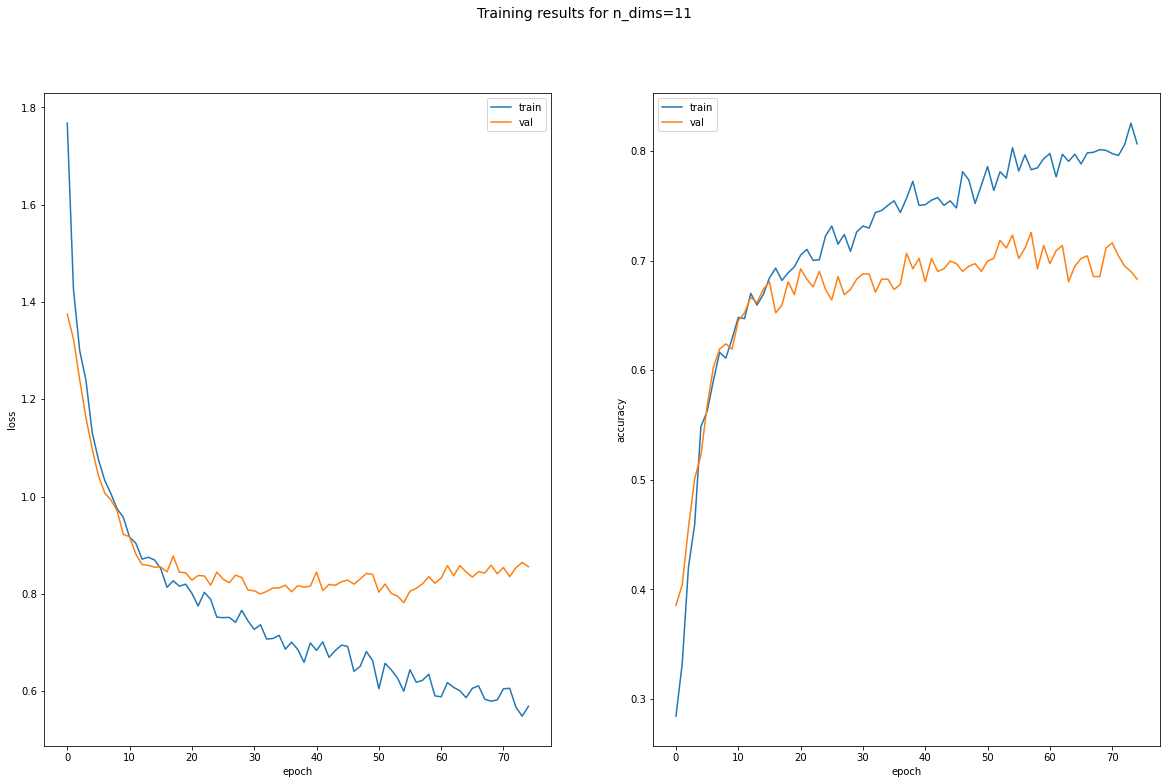

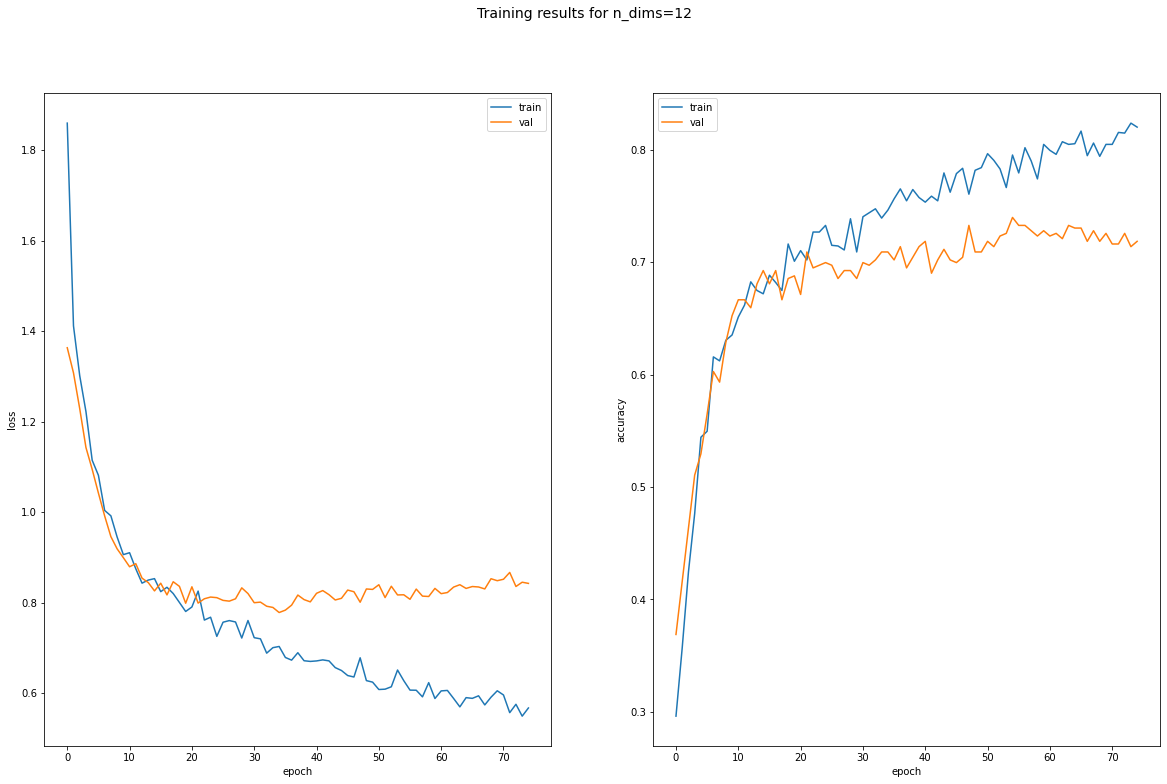

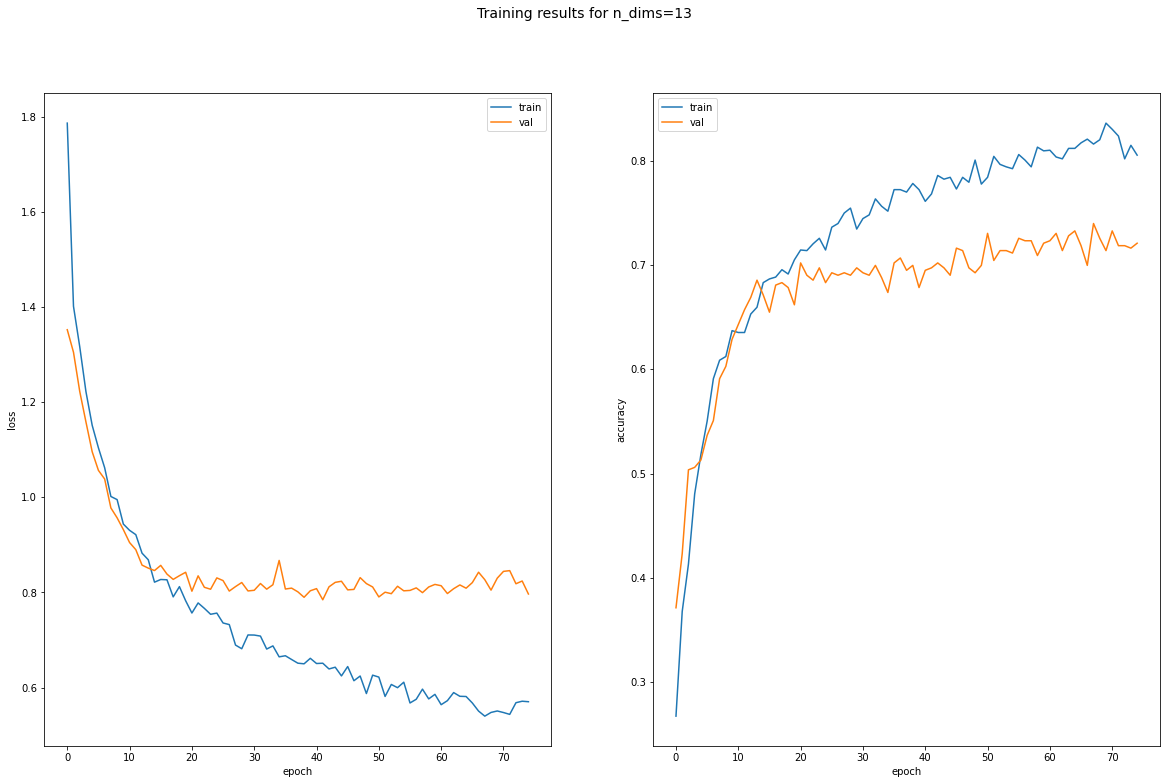

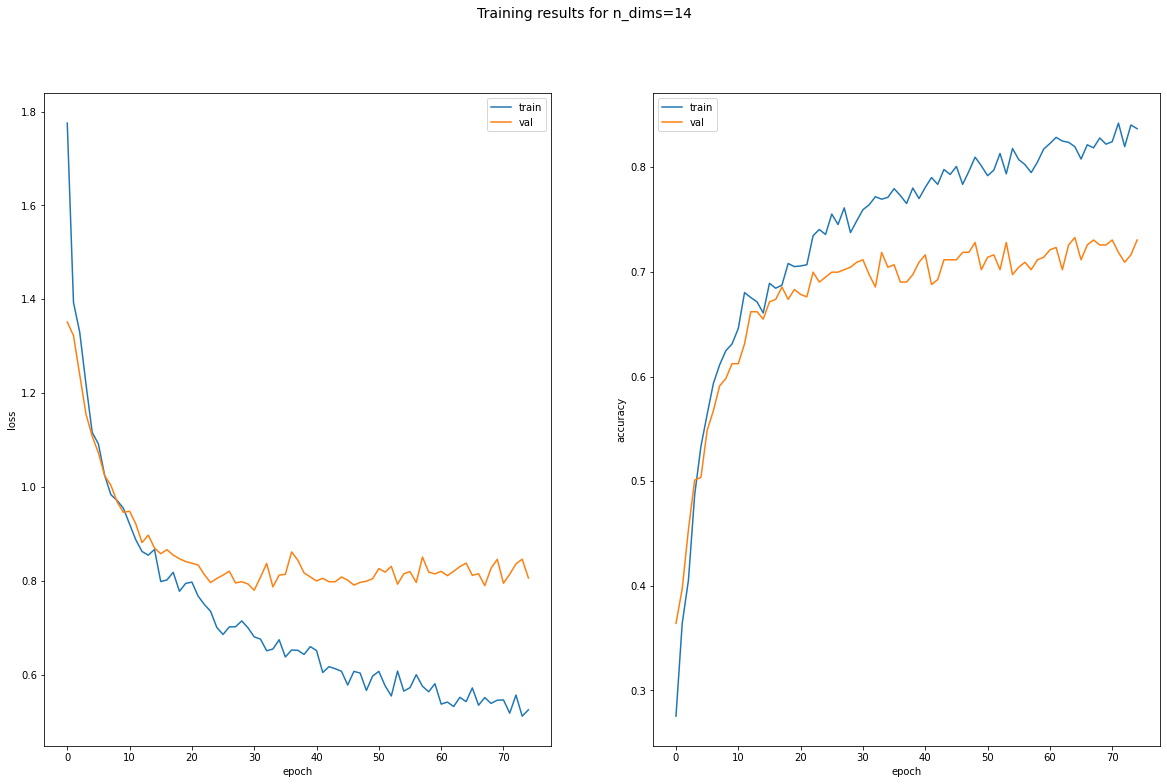

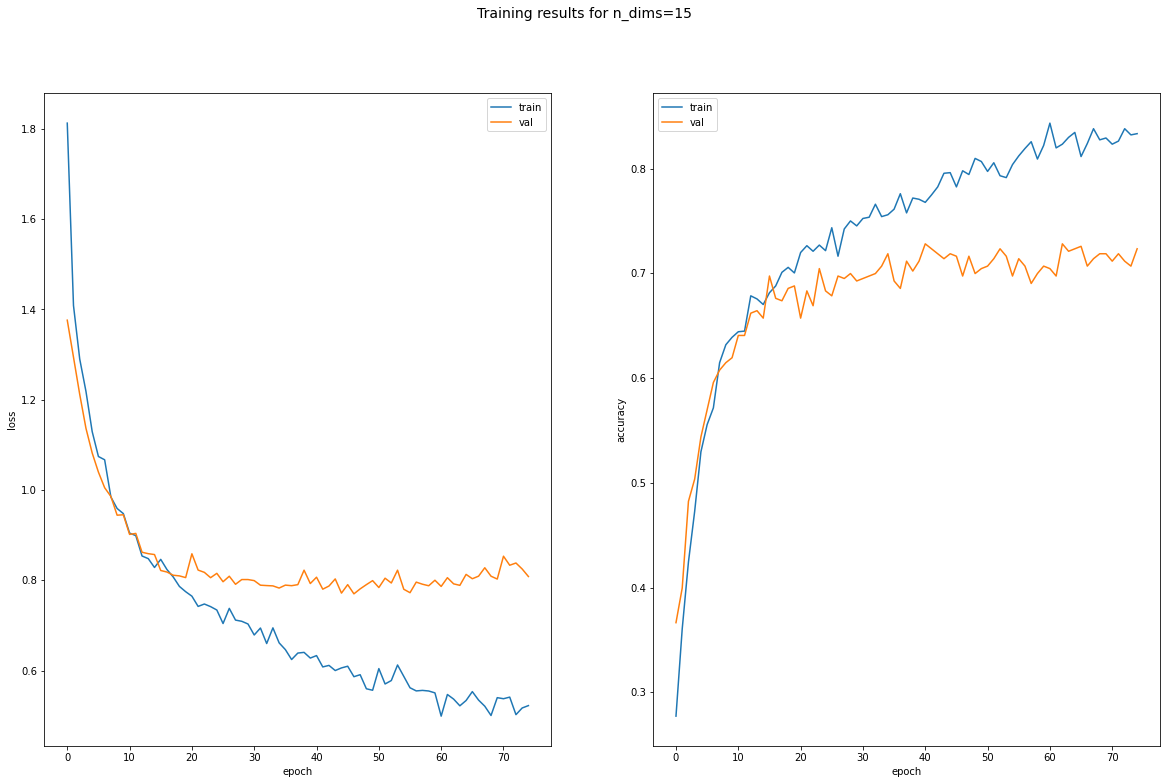

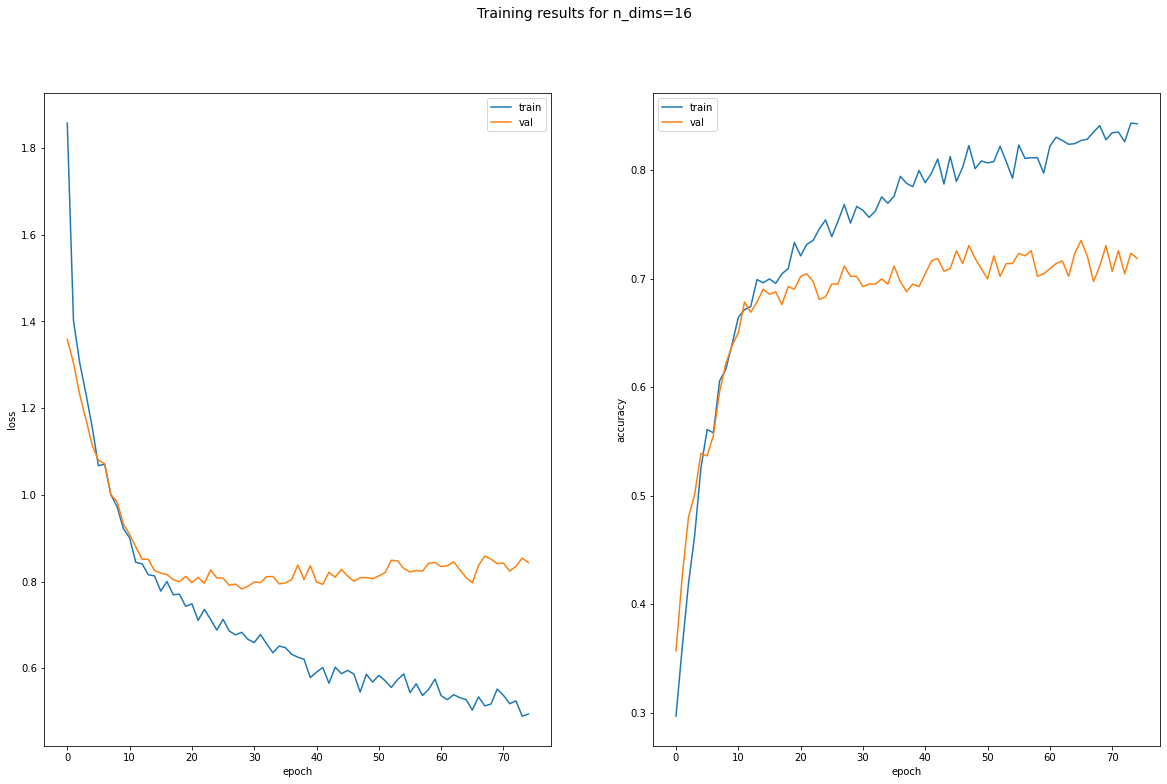

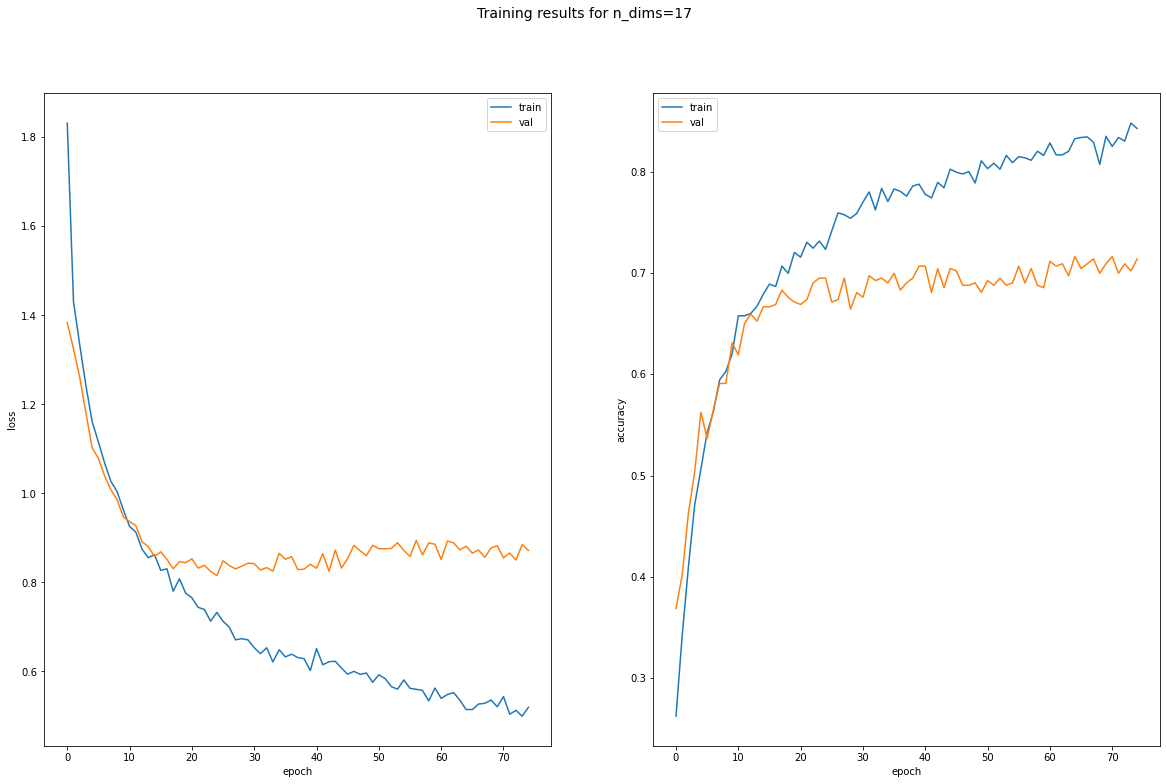

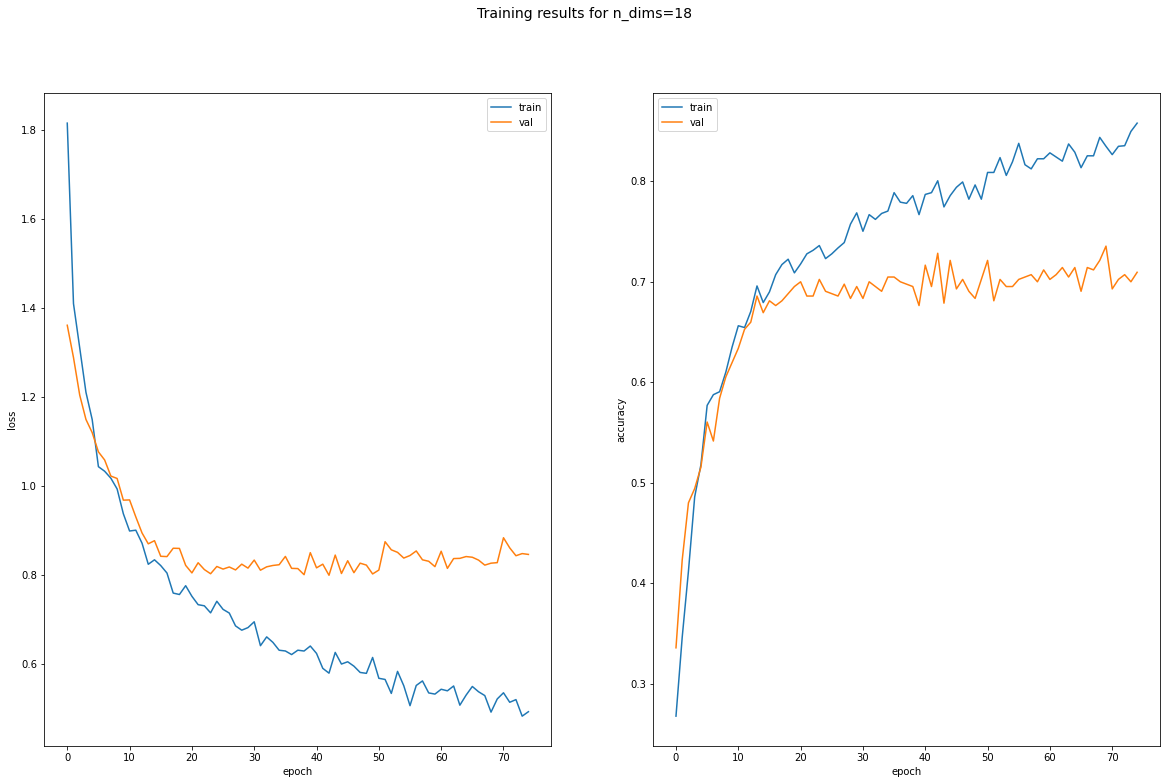

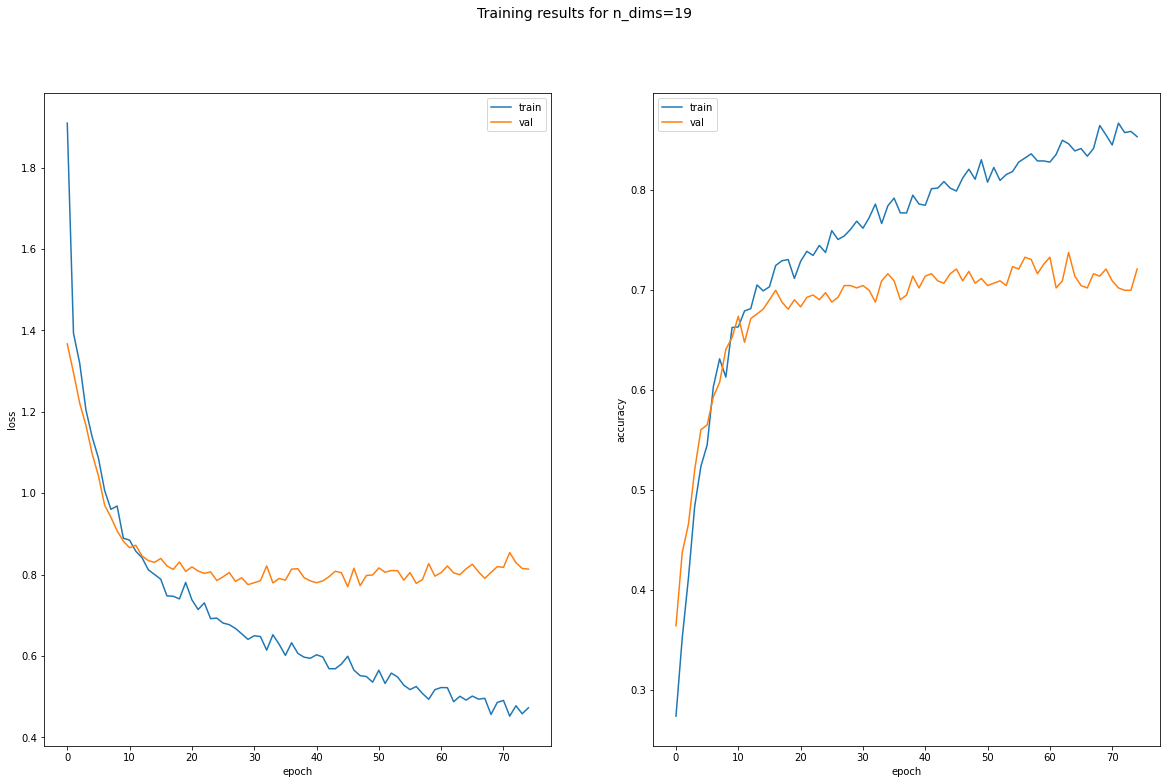

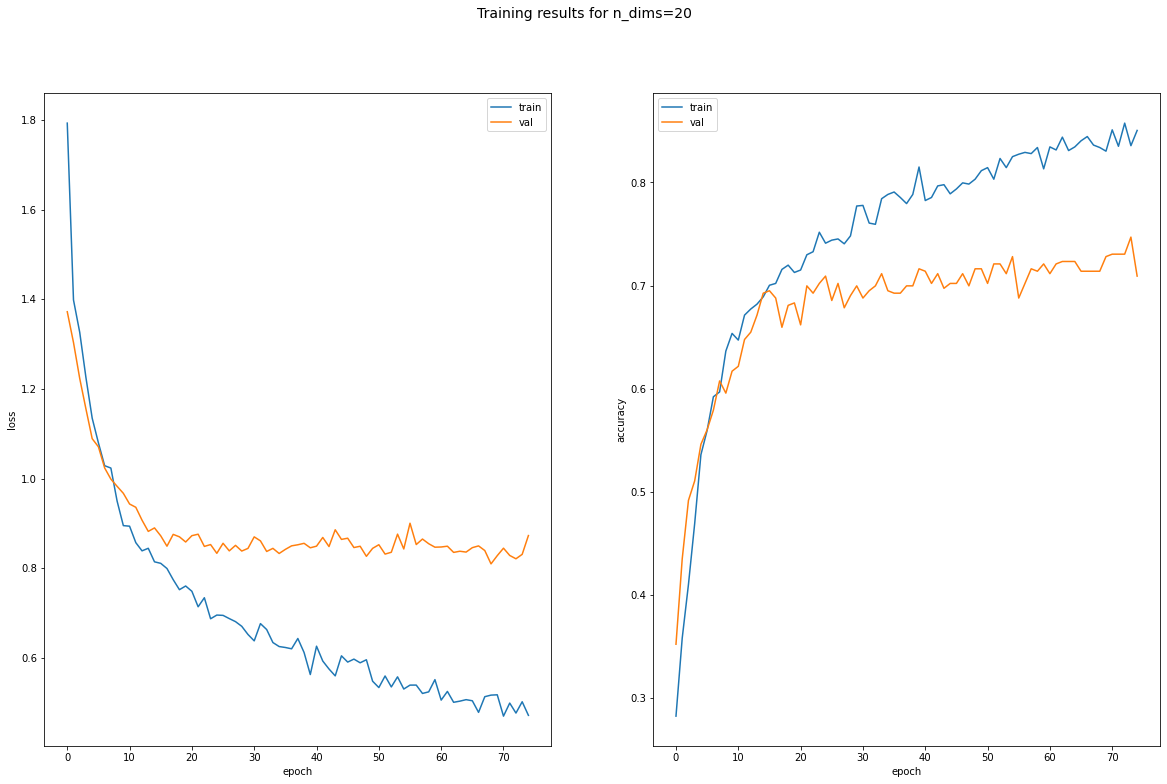

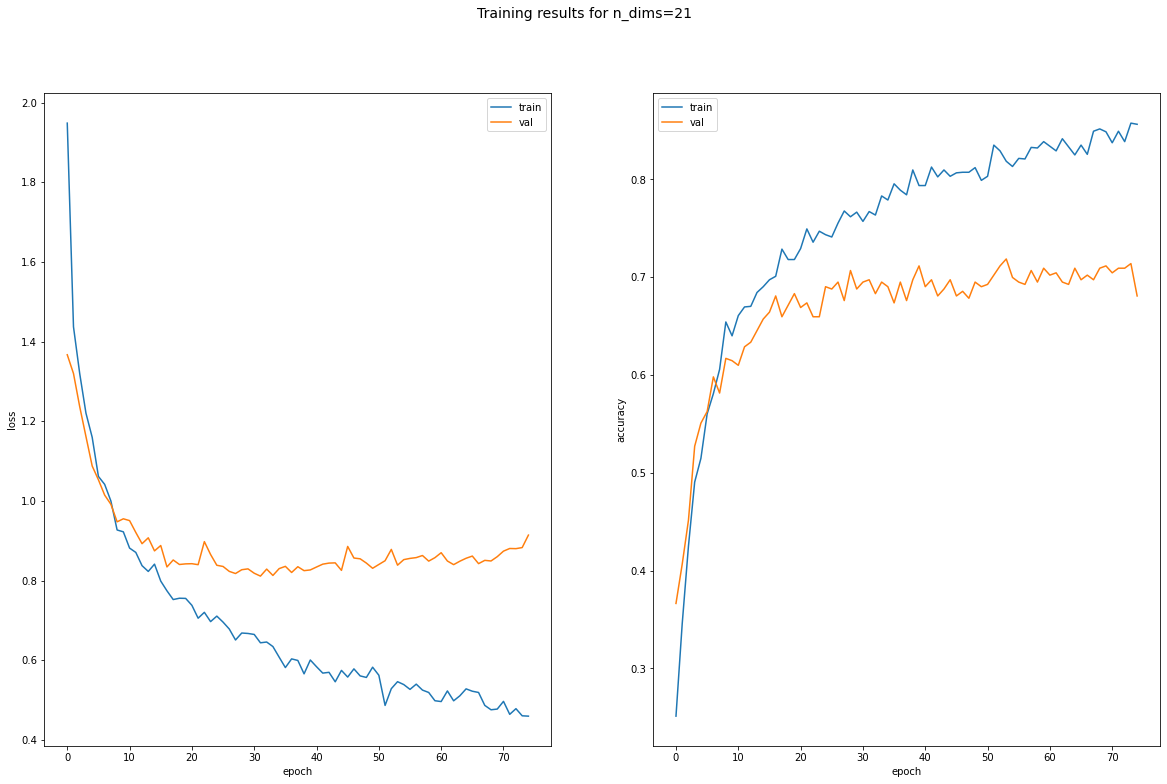

In [44]:
for n_comp in range(8, 22):
    print("Testing PCA Network for n_dims = {}".format(n_comp))
    
    X_train_valid_reshaped = X_train_valid_flipped.reshape((X_train_valid_norm_cropped.shape[0]*X_train_valid_norm_cropped.shape[2], 22)) 
    #print(X_train_valid_reshaped.shape)
    X_test_flipped = np.transpose(X_test_norm_cropped, (0,2,1))
    X_test_reshaped = X_test_flipped.reshape((X_test_norm_cropped.shape[0]*X_test_norm_cropped.shape[2], 22)) 


    #try a PCA on the data
    #reshaped_data = X_train_valid_flipped.reshape((X_train_valid_cropped.shape[1]*X_train_valid_cropped.shape[2], 22))    # create one big data panel with 20 series and 300.000 datapoints
                                          #choose the number of features to have after dimensionality reduction
    pca = PCA(n_components=n_comp)                  #create the pca object       
    pca.fit(X_train_valid_reshaped)                               #fit it to your transformed data
    X_train_valid_transformed=np.empty([X_train_valid_norm_cropped.shape[0],X_train_valid_norm_cropped.shape[2],n_comp])
    for i in range(len(X_train_valid_flipped)):
        #print(X_train_valid_flipped[i].shape)
        X_train_valid_transformed[i]=pca.transform(X_train_valid_flipped[i])           #iteratively apply the transformation to each instance of the original dataset


    #print(X_train_valid_transformed.shape)    #we end up with examples*timesteps*channels
    #now transpose back to examples*channels*timesteps
    X_train_valid_transformed = np.transpose(X_train_valid_transformed, (0,2,1))

    #n_comp=4                                      #choose the number of features to have after dimensionality reduction
    pca = PCA(n_components=n_comp)                  #create the pca object       
    pca.fit(X_test_reshaped)                               #fit it to your transformed data
    X_test_transformed=np.empty([X_test_norm_cropped.shape[0],X_test_norm_cropped.shape[2],n_comp])
    #print(X_test_transformed.shape)
    for i in range(len(X_test_flipped)):
        #print(X_test_flipped[i].shape)
        X_test_transformed[i]=pca.transform(X_test_flipped[i])           #iteratively apply the transformation to each instance of the original dataset

    #print(X_test_transformed.shape)    #we end up with examples*timesteps*channels
    #now transpose back to examples*channels*timesteps
    X_test_transformed = np.transpose(X_test_transformed, (0,2,1))
    
    input_ = layers.Input(shape=(n_comp, 500))
    r1 = layers.Reshape(target_shape=(n_comp, 500, 1))(input_)
    c1 = layers.Conv2D(filters=40, kernel_size=(1,25), data_format='channels_last',
                       activation='elu', kernel_regularizer='l2')(r1)
    p1 = layers.Permute(dims=(2,1,3))(c1)
    r2 = layers.Reshape((476, n_comp*40))(p1)
    d1 = layers.Dense(40, activation='elu')(r2)
    sq1 = layers.Activation(ksquare)(d1)
    ap1 = layers.AveragePooling1D(75, strides=15)(sq1)
    log1 = layers.Activation(klog)(ap1)
    f1 = layers.Flatten()(log1)
    d2 = layers.Dropout(0.80)(f1)
    output_ = layers.Dense(4, activation='softmax', kernel_regularizer='l2', kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01))(d2)
    
    model = models.Model(inputs=input_, outputs=output_, name='shallow_convnet_one_hot')
    #opt = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    model.summary()
    
    loss_hist = model.fit(X_train_valid_transformed, y_train_valid_1h, 
                      validation_split=0.2, epochs=75,
                      verbose=True)

    hist = loss_hist.history

    fig, axs = plt.subplots(1,2, figsize=(20, 12))

    fig.suptitle("Training results for n_dims={}".format(n_comp), fontsize=14)

    axs[0].plot(hist['loss'])
    axs[0].plot(hist['val_loss'])
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'])

    axs[1].plot(hist['acc'])
    axs[1].plot(hist['val_acc'])
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'])

In [25]:
input_ = layers.Input(shape=(n_comp, 500))
r1 = layers.Reshape(target_shape=(n_comp, 500, 1))(input_)
c1 = layers.Conv2D(filters=40, kernel_size=(1,25), data_format='channels_last',
                   activation='elu', kernel_regularizer='l2')(r1)
p1 = layers.Permute(dims=(2,1,3))(c1)
r2 = layers.Reshape((476, n_comp*40))(p1)
d1 = layers.Dense(40, activation='elu')(r2)
sq1 = layers.Activation(ksquare)(d1)
ap1 = layers.AveragePooling1D(75, strides=15)(sq1)
log1 = layers.Activation(klog)(ap1)
f1 = layers.Flatten()(log1)
d2 = layers.Dropout(0.80)(f1)
output_ = layers.Dense(4, activation='softmax', kernel_regularizer='l2', kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01))(d2)

In [26]:
model = models.Model(inputs=input_, outputs=output_, name='shallow_convnet_one_hot')
#opt = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "shallow_convnet_one_hot"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 16, 500)]         0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 16, 500, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 476, 40)       1040      
_________________________________________________________________
permute_1 (Permute)          (None, 476, 16, 40)       0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 476, 640)          0         
_________________________________________________________________
dense_2 (Dense)              (None, 476, 40)           25640     
_________________________________________________________________
activation_2 (Activation)    (None, 476, 40

Epoch 1/75
53/53 [==============================] - 5s 86ms/step - loss: 1.8369 - acc: 0.2801 - val_loss: 1.3619 - val_acc: 0.3853
Epoch 2/75
53/53 [==============================] - 4s 82ms/step - loss: 1.4106 - acc: 0.3493 - val_loss: 1.3095 - val_acc: 0.4279
Epoch 3/75
53/53 [==============================] - 4s 82ms/step - loss: 1.3040 - acc: 0.4125 - val_loss: 1.2292 - val_acc: 0.4752
Epoch 4/75
53/53 [==============================] - 5s 90ms/step - loss: 1.2330 - acc: 0.4557 - val_loss: 1.1723 - val_acc: 0.5106
Epoch 5/75
53/53 [==============================] - 6s 108ms/step - loss: 1.1341 - acc: 0.5372 - val_loss: 1.0984 - val_acc: 0.5603
Epoch 6/75
53/53 [==============================] - 6s 107ms/step - loss: 1.0733 - acc: 0.5715 - val_loss: 1.0684 - val_acc: 0.5839
Epoch 7/75
53/53 [==============================] - 6s 104ms/step - loss: 1.0495 - acc: 0.5887 - val_loss: 1.0360 - val_acc: 0.5792
Epoch 8/75
53/53 [==============================] - 6s 106ms/step - loss: 0.9843

Epoch 63/75
53/53 [==============================] - 6s 105ms/step - loss: 0.5721 - acc: 0.8073 - val_loss: 0.8170 - val_acc: 0.7376
Epoch 64/75
53/53 [==============================] - 6s 106ms/step - loss: 0.5410 - acc: 0.8115 - val_loss: 0.8394 - val_acc: 0.7210
Epoch 65/75
53/53 [==============================] - 6s 105ms/step - loss: 0.5395 - acc: 0.8251 - val_loss: 0.8077 - val_acc: 0.7258
Epoch 66/75
53/53 [==============================] - 5s 104ms/step - loss: 0.5148 - acc: 0.8339 - val_loss: 0.8279 - val_acc: 0.7163
Epoch 67/75
53/53 [==============================] - 6s 105ms/step - loss: 0.5442 - acc: 0.8197 - val_loss: 0.8432 - val_acc: 0.7258
Epoch 68/75
53/53 [==============================] - 6s 110ms/step - loss: 0.5233 - acc: 0.8387 - val_loss: 0.8498 - val_acc: 0.7187
Epoch 69/75
53/53 [==============================] - 7s 126ms/step - loss: 0.5318 - acc: 0.8233 - val_loss: 0.8262 - val_acc: 0.7045
Epoch 70/75
53/53 [==============================] - 6s 118ms/step - 

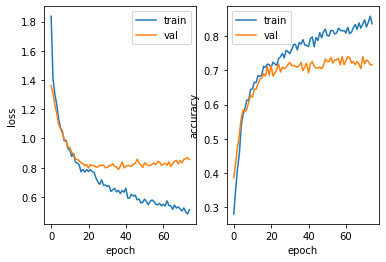

In [27]:
## Training 12

## Wow, best performance now 74%


loss_hist = model.fit(X_train_valid_transformed, y_train_valid_1h, 
                      validation_split=0.2, epochs=75,
                      verbose=True)

hist = loss_hist.history

plt.subplot(1,2,1)
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

plt.subplot(1,2,2)
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

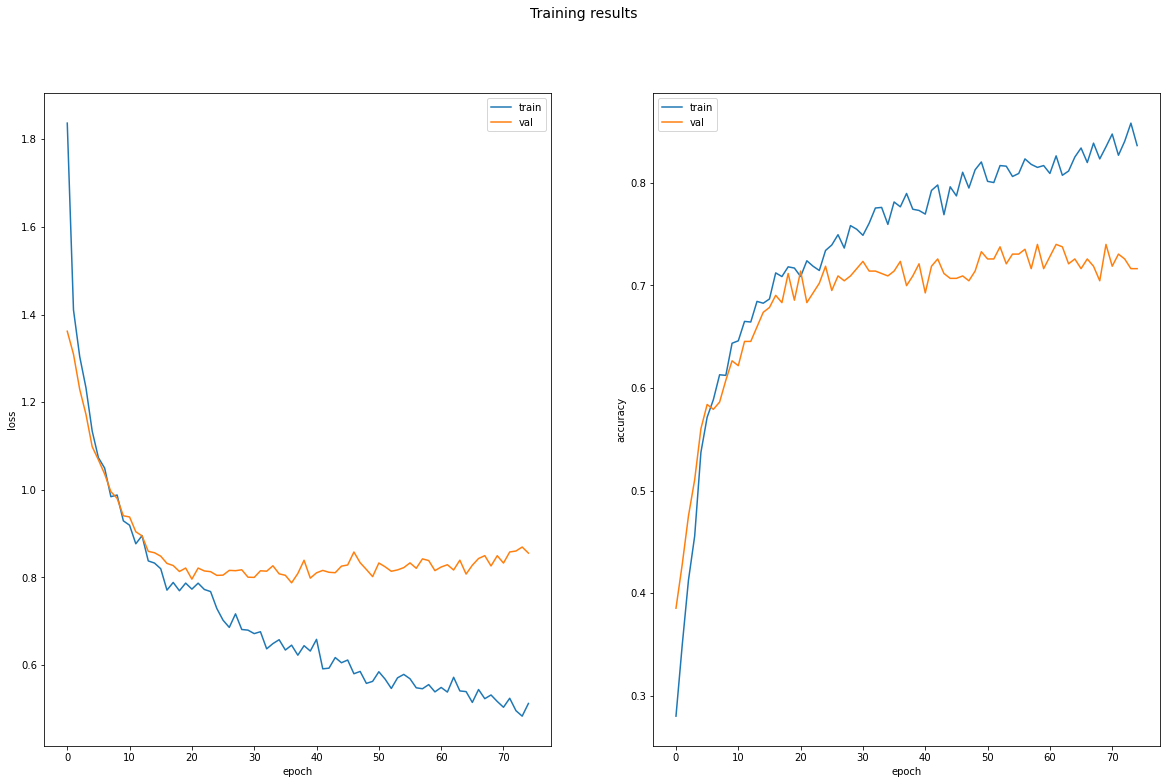

In [41]:
hist = loss_hist.history

fig, axs = plt.subplots(1,2, figsize=(20, 12))

fig.suptitle("Training results", fontsize=14)

axs[0].plot(hist['loss'])
axs[0].plot(hist['val_loss'])
axs[0].set_ylabel('loss')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'val'])

axs[1].plot(hist['acc'])
axs[1].plot(hist['val_acc'])
axs[1].set_ylabel('accuracy')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'val'])